In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reading the features matrix

In [141]:
def get_feature_matrix(file_path):
    df = pd.read_csv(file_path, header=0)
    #the total of 24 valueable features
    #the first 2 are not helpful (serial number and date)
    c = len(df.iloc[0,:])
    df_ = df.iloc[:,1:c]
    df_.iloc[:,0] = pd.to_datetime(df_.iloc[:,0])
    df_['']
    if len(df_.iloc[0,:])==26:
        #print('train')
        res = df_.iloc[:,0:-1].values
    else:
        #print('test')
        res = df_.values
    return res

In [144]:
def setMydateData(data):
    npdates = [np.datetime64(x) for x in data[:,0]]
    data_ = data
    data_[:,0] = (npdates - np.min(npdates))/np.timedelta64(1,'D')
    return data_

In [145]:
withDt = get_feature_matrix('../data/train.csv')
print(withDt[0,0])
#tr = np.datetime64(withDt[:,0] - np.min(withDt[:,0]))/np.timedelta64(1,'D')
data = setMydateData(withDt)
data = np.array(data, dtype=np.float32)
plt.scatter(data[:,0], data[:,4])
plt.show()

KeyError: ''

In [140]:
withDt[:,0]

array([76.86805555555556, 36.083333333333336, 66.45833333333333, ...,
       6.840277777777778, 67.42361111111111, 95.52777777777777], dtype=object)

In [3]:
def get_output(file_path):
    #assuming the last column is the output column
    df = pd.read_csv(file_path,header=0)
    res = np.array(df.iloc[:,len(df.columns)-1])
    return res

In [4]:
X = get_feature_matrix("../data/train.csv")
Y = get_output("../data/train.csv")
###for cross validation
n_samples = len(Y)
train_X = X[0:int(np.floor(n_samples*0.75)), :]
X_ = X[int(np.floor(n_samples*0.75)):n_samples, :]
train_Y = Y[0:int(np.floor(n_samples*0.75))]
Y_ = Y[int(np.floor(n_samples*0.75)):n_samples]

In [5]:
len(X[:,0])

13000

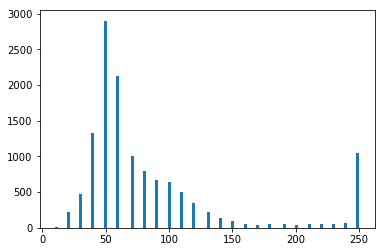

In [13]:
#trying to see distribution of Y
plt.hist(Y, 100)
plt.show()


# Attempt to do feature Engineering

In [7]:
X_egn = X
X_egn[:,-3] = 1/X[:,-3]
#humidity and temp are inversely related
X_egn[:,range(1,17,2)] = 1/X_egn[:,range(1,17,2)]

X_egn1 = X
X_egn1[:,range(1,17,2)] = X_egn1[:,range(1,17,2)]**2

X_egn2 = 1/X_egn

# Costs and other utility functions

In [21]:
def get_cost(W,X,Y):
    n = len(X[0,:])
    m = len(Y)
    cost = 0
    for i in range(0,m):
        cost += (sum(W*X[i,:]) - Y[i])**2
    cost = np.sqrt(cost/(m))
    
    return cost

In [67]:
a = 2*np.ones([3,3],int)
print(a)
b = np.power(a,3)
print(a)
a_ = np.concatenate((a,b,b),axis=1)
print(a_)

[[2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2 8 8 8 8 8 8]
 [2 2 2 8 8 8 8 8 8]
 [2 2 2 8 8 8 8 8 8]]


In [9]:
#some variables which may be standard, and helpful for testing
stdX = np.std(X, axis=0)
maxX = np.max(X, axis=0)
minX = np.min(X, axis=0)
meanX = np.mean(X, axis=0)



In [19]:
def subgrad(X,Y,lam,p,alpha):
    stdX = np.std(X, axis=0)
    maxX = np.max(X, axis=0)
    minX = np.min(X, axis=0)
    meanX = np.mean(X, axis=0)
    
    ###not needed, not much helpful to scale target values###
    stdY = np.std(Y)
    maxY = np.max(Y)
    minY = np.min(Y)
    meanY = np.mean(Y)
    ##################
    
    #The transformed variables used for reg (standardised)
    
    #min max
    ##X_ = (X - minX)/(maxX-minX)
    ##Y_ = (Y - minY)/(maxY-minY)
    
    ##zscore standardisation
    X_ = (X - meanX)/stdX
    #attempt to avoid outliers
    Y[Y>250] = 250
    
    #iterable range
    n_features = len(maxX) #number of features
    n_samples = len(Y) #number of samples
    
    #initialisation of weights to perform grad descent
    W = 0.01*np.ones(n_features+1)
    W_ = np.zeros(n_features+1)
    
    #vars for descent
    eps = 0.0001
    costs = []
    steps = 0
    #norm_diff_w = np.linalg.norm(W-W_)
    norm_grad = 100
    print('size of X_[0,:]={0} and size of W={1}'.format(len(X_[0,:]), len(W)))
    
    #the optimization
    #appending ones in X_ will help simplify calc
    X_1 = np.append(X_, np.ones([len(X_[:,0]),1]), axis=1)
    while(norm_grad > eps):
        steps += 1
        grad = np.zeros(n_features+1)
        
        
        #cooler way to do things
        hypo = np.dot(X_1,W)
        loss = hypo - Y
        cost = get_cost(W, X_1,Y)
        grad = np.dot(X_1.transpose(),loss)/n_samples
        #to make it general
        for i in range(0,n_features):
            if(abs(W[i]) >0):
                grad[i] += lam*p*(abs(W[i])**p)/(W[i])
        
        W_ = W - alpha*grad
        
        temp = W
        W = W_
        W_ = temp
        
        
        costs.append(get_cost(W,X_1,Y))
        prev_norm_grad = norm_grad
        norm_grad = np.linalg.norm(grad)
        #print('X={0}, Y={1}, W={2}'.format(X_1,Y,W))
        
        '''The following to modify step
        if steps>1:
            prev_cost = costs[-2]
            if prev_cost >= costs[-1]:
                alpha += alpha*0.05
            else:
                #overshoot
                print('overshoot!! correcting')
                temp = W
                W = W_
                W_ = temp
                norm_grad = prev_norm_grad
                alpha -= alpha*0.5
            #norm_diff_w = np.linalg.norm(W-W_)
        '''
        
        '''
        for k in range(n_features+1):
            #print(k)
            dJ_dwk = 0
            for i in range(n_samples):
                #lets not use Y_ but Y
                dJ_dwk += (sum(W*X_1[i,:])-Y[i])*X_1[i,k]
            
            if(abs(W[k])>0 and not(k==n_features)):
                dJ_dwk = dJ_dwk/n_samples + ((lam*p*(W[k]**p))/(2*abs(W[k])))
            #elif(abs(W[k])==0):
            #    dJ_dwk = dJ_dwk/m + 0.00001 #a small constant
            else:
                dJ_dwk = dJ_dwk/n_samples
            
            grad[k] = dJ_dwk
        
        print("new_grad={0} | grad={1}".format(np.linalg.norm(new_grad), np.linalg.norm(grad)))
        W_ = W - alpha*grad
        '''
        print('step={0}, cost={1}, norm_grad={2}'.format(steps, costs[-1], norm_grad))
    #now the loop finshes
    return(W, costs, steps, meanX, stdX)

# simple linear regression

## result without removing anamolies

In [15]:
regRes = subgrad(X, Y, 0, 1, 0.01)

size of X_[0,:]=24 and size of W=25
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[ 0.02768293  0.00488426  0.04310758  0.0078597   0.02807366  0.00629345
  0.02622184  0.00915077  0.02673896  0.00863816  0.08537067  0.01204322
  0.02584316  0.00563735  0.02139926  0.02404507  0.01281744 -0.0135442
  0.07060205  0.01210742 -0.05455048  0.00445869  0.00389634  0.01965536
  0.87064615]
step=1, cost=73.85945305514792, norm_grad=87.05671087919953
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  1.69239203e-01  -4.26055272e-02   3.23356696e-01  -1.11686848e-02
   1.71590010e-01  -2.59702845e-02   1.48744725e-01   1.00790874e-03
   1.57442472e-01  -3.40271880e-03   7.49455211e-01   2.99164724e-02
   1.44633997e-01  -3.36985847e-02   1.06186382e-01   1.57743209e-01
   6.52769025e-03  -2.46634903e-01   5.89707411e-01   2.86161755e-02
  -6.46775852e-01  -4.76618485e-02  -5.11768907e-02   6.11089381e-02
   9.01767289e+00]
step=11, cost=69.14569918368586, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  2.55269231e-01  -8.08093896e-02   5.13547534e-01  -2.52143527e-02
   2.57407465e-01  -4.89051174e-02   2.12383926e-01  -6.18199374e-03
   2.32326039e-01  -1.23158070e-02   1.23391267e+00   4.27798155e-02
   2.04905709e-01  -6.35389832e-02   1.49228154e-01   2.67969430e-01
  -3.78478257e-02  -4.47837894e-01   9.47773976e-01   4.01153068e-02
  -1.10567284e+00  -8.99313760e-02  -9.16044224e-02   3.31145348e-02
   1.56817694e+01]
step=20, cost=65.43751942359292, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  3.20854924e-01  -1.19546384e-01   6.76475024e-01  -3.81668547e-02
   3.21754850e-01  -6.92798346e-02   2.49245928e-01  -1.44092823e-02
   2.84943319e-01  -2.06891830e-02   1.67881993e+00   5.44222048e-02
   2.37941334e-01  -9.18919104e-02   1.74302119e-01   3.79938588e-01
  -1.12622448e-01  -6.56844133e-01   1.25660754e+00   5.30391342e-02
  -1.54540386e+00  -1.32401278e-01  -1.27026990e-01  -4.58235483e-02
   2.24125872e+01]
step=30, cost=61.84603072983927, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  3.62137805e-01  -1.51797910e-01   7.91845465e-01  -4.79237807e-02
   3.61662659e-01  -8.40482358e-02   2.62457669e-01  -2.21744415e-02
   3.14557345e-01  -2.71856914e-02   2.01540331e+00   6.30884697e-02
   2.47622744e-01  -1.13949558e-01   1.84467117e-01   4.71927607e-01
  -1.92748790e-01  -8.29748391e-01   1.47449508e+00   6.65333247e-02
  -1.88688881e+00  -1.67049291e-01  -1.51213905e-01  -1.45040581e-01
   2.79182547e+01]
step=39, cost=59.039613643513576, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  3.92494423e-01  -1.82012037e-01   8.85721639e-01  -5.62257902e-02
   3.90762039e-01  -9.61408966e-02   2.63490835e-01  -3.03103658e-02
   3.33562732e-01  -3.29039374e-02   2.30548030e+00   7.04301042e-02
   2.45062204e-01  -1.33332870e-01   1.87878391e-01   5.56236660e-01
  -2.78696782e-01  -9.87585829e-01   1.64930798e+00   8.24884833e-02
  -2.18406249e+00  -1.98686616e-01  -1.69026601e-01  -2.61092619e-01
   3.29477768e+01]
step=48, cost=56.59363976049614, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.41569911  -0.21045345   0.9635825   -0.06332508   0.4130237
  -0.10605714   0.25671554  -0.03878389   0.3459166   -0.03797298
   2.55895655   0.07672217   0.23466181  -0.1504787    0.18762539
   0.63346817  -0.36648572  -1.13051616   1.79082207   0.1010224
  -2.44274675  -0.22762235  -0.18135825  -0.38734741  37.54233205]
step=57, cost=54.469844985300554, norm_grad=49.26181687423571
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]


X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.43612696  -0.24017955   1.03600143  -0.07003877   0.43288881
  -0.11497737   0.24359125  -0.0485154    0.35499892  -0.04294748
   2.80663029   0.08272903   0.21751823  -0.16731254   0.18540763
   0.71167842  -0.4630896   -1.27261631   1.91781472   0.12439962
  -2.69107614  -0.25692895  -0.1896666   -0.53396849  42.18288828]
step=67, cost=52.444881281326346, norm_grad=44.5429758065392
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.45147298  -0.2653635    1.09148074  -0.07519039   0.44819927
  -0.12143017   0.22887136  -0.05747162   0.36082642  -0.04689616
   3.00502293   0.08741494   0.19922982  -0.18075407   0.1829575
   0.77581547  -0.54746053  -1.38645118   2.01081336   0.14754716
  -2.88404404  -0.2809993   -0.19314414  -0.66811429  45.97876565]
step=76, cost=50.887949619286765, norm_grad=40.68677484382553
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.46502205  -0.28913681   1.13978772  -0.07962338   0.46215009
  -0.12662165   0.21271941  -0.0665299    0.36552616  -0.05038764
   3.18454579   0.09153718   0.17959175  -0.19279319   0.18077788
   0.83454904  -0.62843335  -1.48803522   2.08787391   0.17224257
  -3.05188198  -0.30309689  -0.19355468  -0.80203545  49.4463651 ]
step=85, cost=49.55141545315203, norm_grad=37.16647211011766
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.47875622  -0.31396328   1.18673535  -0.08382407   0.47680409
  -0.13112596   0.19408424  -0.07661902   0.37019989  -0.05377008
   3.36577663   0.09556259   0.15721669  -0.20473113   0.1790937
   0.89403221  -0.71382691  -1.5878331    2.15856444   0.20095746
  -3.21271098  -0.3255546   -0.1911524   -0.94875648  52.94868239]
step=95, cost=48.29160196034598, norm_grad=33.61293222980224
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]


X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.49161792  -0.33717801   1.22793121  -0.08736685   0.49102442
  -0.13449065   0.17540074  -0.0866402    0.37478145  -0.05666535
   3.53108545   0.09909392   0.13496745  -0.21534037   0.17837307
   0.94799526  -0.79413589  -1.67525536   2.21667699   0.23046005
  -3.35011153  -0.3460182   -0.18643178  -1.09197435  56.11611537]
step=105, cost=47.23614105143333, norm_grad=30.400727773802753
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.       

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  0.50391062  -0.35883891   1.26437755  -0.09034151   0.50504562
  -0.13687908   0.15708727  -0.09651      0.37952942  -0.05910705
   3.68310474   0.10220432   0.11328976  -0.22478233   0.17863726
   0.99696573  -0.86933617  -1.75166085   2.26470966   0.26023809
  -3.46726467  -0.36468189  -0.17999424  -1.23082602  58.98068498]
step=115, cost=46.35485558214693, norm_grad=27.496841880904753
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.       

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.15790300e-01  -3.79004033e-01   1.29681373e+00  -9.28228785e-02
   5.18953876e-01  -1.38428397e-01   1.39376550e-01  -1.06159300e-01
   3.84549071e-01  -6.11270842e-02   3.82389090e+00   1.04952033e-01
   9.24366960e-02  -2.33194190e-01   1.79808965e-01   1.04142134e+00
  -9.39560558e-01  -1.81830605e+00   2.30459148e+00   2.89854471e-01
  -3.56689802e+00  -3.81718407e-01  -1.72337175e-01  -1.36480145e+00
   6.15713504e+01]
step=125, cost=45.62119190596733, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.26186342e-01  -3.95923611e-01   1.32304228e+00  -9.46867758e-02
   5.31377077e-01  -1.39202483e-01   1.24050126e-01  -1.14609191e-01
   3.89313038e-01  -6.26104372e-02   3.94234590e+00   1.07154081e-01
   7.44835292e-02  -2.39982162e-01   1.81536115e-01   1.07792893e+00
  -9.98690259e-01  -1.87088886e+00   2.33476798e+00   3.16071717e-01
  -3.64353268e+00  -3.95787830e-01  -1.64740546e-01  -1.48098555e+00
   6.36904602e+01]
step=134, cost=45.067918551985734, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.37427312e-01  -4.13415574e-01   1.34929458e+00  -9.63973380e-02
   5.45037775e-01  -1.39467048e-01   1.07745931e-01  -1.23697740e-01
   3.94850340e-01  -6.39151325e-02   4.06600185e+00   1.09335908e-01
   5.54924543e-02  -2.46749880e-01   1.84071155e-01   1.11496109e+00
  -1.06010940e+00  -1.92204385e+00   2.36304846e+00   3.44448886e-01
  -3.71606497e+00  -4.10144141e-01  -1.55820384e-01  -1.60509854e+00
   6.58307867e+01]
step=144, cost=44.55359372670032, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.48335597e-01  -4.29594784e-01   1.37284393e+00  -9.77739560e-02
   5.58488480e-01  -1.39191158e-01   9.22101188e-02  -1.32439145e-01
   4.00589548e-01  -6.48878256e-02   4.18231341e+00   1.11270866e-01
   3.75176113e-02  -2.52790655e-01   1.87115876e-01   1.14861816e+00
  -1.11729800e+00  -1.96644079e+00   2.38673382e+00   3.71814870e-01
  -3.77701644e+00  -4.23277593e-01  -1.46652137e-01  -1.72397441e+00
   6.77664596e+01]
step=154, cost=44.12822627349626, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.58892802e-01  -4.44529072e-01   1.39397924e+00  -9.88576076e-02
   5.71662061e-01  -1.38453661e-01   7.74235494e-02  -1.40810766e-01
   4.06464412e-01  -6.55585582e-02   4.29216092e+00   1.12987147e-01
   2.05400699e-02  -2.58185437e-01   1.90536106e-01   1.17922065e+00
  -1.17054320e+00  -2.00490416e+00   2.40660107e+00   3.98000634e-01
  -3.82791254e+00  -4.35300752e-01  -1.37445733e-01  -1.83769548e+00
   6.95170474e+01]
step=164, cost=43.77700318244212, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.69076995e-01  -4.58287481e-01   1.41294257e+00  -9.96840844e-02
   5.84494461e-01  -1.37324157e-01   6.33538188e-02  -1.48798300e-01
   4.12408238e-01  -6.59565836e-02   4.39627092e+00   1.14508959e-01
   4.52440319e-03  -2.63006041e-01   1.94212273e-01   1.20705766e+00
  -1.22012447e+00  -2.03816298e+00   2.42327884e+00   4.22887291e-01
  -3.87007297e+00  -4.46314985e-01  -1.28363431e-01  -1.94639651e+00
   7.11002477e+01]
step=174, cost=43.487392880007555, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.77906912e-01  -4.69722015e-01   1.42832443e+00  -1.00234075e-01
   5.95705208e-01  -1.36023480e-01   5.12723713e-02  -1.55652483e-01
   4.17765353e-01  -6.61049810e-02   4.48556638e+00   1.15729728e-01
  -9.10346299e-03  -2.66906614e-01   1.97654171e-01   1.22996256e+00
  -1.26183509e+00  -2.06417892e+00   2.43598704e+00   4.44110299e-01
  -3.90149669e+00  -4.55440906e-01  -1.20397701e-01  -2.04007393e+00
   7.23952722e+01]
step=183, cost=43.270671398029556, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.86406071e-01  -4.80310543e-01   1.44224778e+00  -1.00621549e-01
   6.06559695e-01  -1.34495219e-01   3.97115600e-02  -1.62188142e-01
   4.23088083e-01  -6.60750406e-02   4.57107863e+00   1.16823480e-01
  -2.20222046e-02  -2.70435677e-01   2.01156188e-01   1.25101132e+00
  -1.30097618e+00  -2.08691557e+00   2.44683631e+00   4.64186585e-01
  -3.92750076e+00  -4.63884219e-01  -1.12699378e-01  -2.12995823e+00
   7.35782995e+01]
step=192, cost=43.08880277772352, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  5.95451236e-01  -4.91143528e-01   1.45615149e+00  -1.00883495e-01
   6.18169333e-01  -1.32573659e-01   2.74422622e-02  -1.69078563e-01
   4.28920081e-01  -6.58553796e-02   4.66204352e+00   1.17904341e-01
  -3.55871831e-02  -2.73966805e-01   2.05053454e-01   1.27241257e+00
  -1.34166038e+00  -2.10878010e+00   2.45702457e+00   4.85133417e-01
  -3.95081543e+00  -4.72532068e-01  -1.04518853e-01  -2.22555706e+00
   7.47731713e+01]
step=202, cost=42.92092441587072, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.03227972e-01  -5.00107272e-01   1.46737158e+00  -1.00985240e-01
   6.28189881e-01  -1.30677983e-01   1.68888040e-02  -1.74950390e-01
   4.34063537e-01  -6.55092670e-02   4.74056903e+00   1.18767827e-01
  -4.71229317e-02  -2.76830759e-01   2.08519176e-01   1.29004218e+00
  -1.37592493e+00  -2.12575677e+00   2.46475116e+00   5.02764845e-01
  -3.96739300e+00  -4.79709830e-01  -9.75296194e-02  -2.30791297e+00
   7.57505513e+01]
step=211, cost=42.795542031411706, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.11462689e-01  -5.09252704e-01   1.47852318e+00  -1.00967594e-01
   6.38830561e-01  -1.28422557e-01   5.67439069e-03  -1.81116531e-01
   4.39632280e-01  -6.49806041e-02   4.82440412e+00   1.19617844e-01
  -5.92344486e-02  -2.79702168e-01   2.12280145e-01   1.30798097e+00
  -1.41156972e+00  -2.14198121e+00   2.47196172e+00   5.21018999e-01
  -3.98153836e+00  -4.87070098e-01  -9.02060093e-02  -2.39551460e+00
   7.67377169e+01]
step=221, cost=42.67990654429895, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.18510402e-01  -5.16800077e-01   1.48747244e+00  -1.00848216e-01
   6.47954255e-01  -1.26285880e-01  -3.98330397e-03  -1.86352515e-01
   4.44492752e-01  -6.43919291e-02   4.89700703e+00   1.20293754e-01
  -6.95336647e-02  -2.82036512e-01   2.15554875e-01   1.32276989e+00
  -1.44161478e+00  -2.15448701e+00   2.47738128e+00   5.36273383e-01
  -3.99089612e+00  -4.93186344e-01  -8.40257775e-02  -2.47100240e+00
   7.75451976e+01]
step=230, cost=42.59359787744845, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.25218346e-01  -5.23744700e-01   1.49547564e+00  -1.00642797e-01
   6.56645388e-01  -1.24071042e-01  -1.32504913e-02  -1.91300982e-01
   4.49195555e-01  -6.37110472e-02   4.96709803e+00   1.20893243e-01
  -7.92939960e-02  -2.84159432e-01   2.18704136e-01   1.33638527e+00
  -1.46986239e+00  -2.16524060e+00   2.48192142e+00   5.50449748e-01
  -3.99745406e+00  -4.98860725e-01  -7.82393063e-02  -2.54346189e+00
   7.82828451e+01]
step=239, cost=42.52130163350034, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.31593212e-01  -5.30127769e-01   1.50260724e+00  -1.00361731e-01
   6.64904730e-01  -1.21797635e-01  -2.21464297e-02  -1.95971982e-01
   4.53730758e-01  -6.29510273e-02   5.03483561e+00   1.21423279e-01
  -8.85432315e-02  -2.86092876e-01   2.21712981e-01   1.34892468e+00
  -1.49642911e+00  -2.17444148e+00   2.48569216e+00   5.63586900e-01
  -4.00154896e+00  -5.04127954e-01  -7.28447394e-02  -2.61303226e+00
   7.89566988e+01]
step=248, cost=42.460746153764596, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.38296076e-01  -5.36609036e-01   1.50959256e+00  -9.99720641e-02
   6.73580482e-01  -1.19223910e-01  -3.16168086e-02  -2.00849504e-01
   4.58565171e-01  -6.20282920e-02   5.10750994e+00   1.21938418e-01
  -9.82524902e-02  -2.88042887e-01   2.24878780e-01   1.36170363e+00
  -1.52410752e+00  -2.18305855e+00   2.48909358e+00   5.77016858e-01
  -4.00357202e+00  -5.09541521e-01  -6.73024332e-02  -2.68710734e+00
   7.96372992e+01]
step=258, cost=42.4049224879929, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.44611759e-01  -5.42496119e-01   1.51567379e+00  -9.95120382e-02
   6.81737971e-01  -1.16619932e-01  -4.06727620e-02  -2.05412725e-01
   4.63178957e-01  -6.10375732e-02   5.17762306e+00   1.22383441e-01
  -1.07396693e-01  -2.89807561e-01   2.27849159e-01   1.37337542e+00
  -1.54998117e+00  -2.19019189e+00   2.49177118e+00   5.89278681e-01
  -4.00328307e+00  -5.14531507e-01  -6.22219747e-02  -2.75795777e+00
   8.02528221e+01]
step=268, cost=42.359069100207236, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.49977297e-01  -5.47325913e-01   1.52044017e+00  -9.90463440e-02
   6.88647269e-01  -1.14265328e-01  -4.84855614e-02  -2.09263621e-01
   4.67140960e-01  -6.00989282e-02   5.23866049e+00   1.22729861e-01
  -1.15169440e-01  -2.91255141e-01   2.30351516e-01   1.38301689e+00
  -1.57182900e+00  -2.19549955e+00   2.49363947e+00   5.99368759e-01
  -4.00130853e+00  -5.18690338e-01  -5.80297411e-02  -2.81910515e+00
   8.07563068e+01]
step=277, cost=42.32483998102303, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.55599842e-01  -5.52212769e-01   1.52501874e+00  -9.84799108e-02
   6.95857963e-01  -1.11651058e-01  -5.68085555e-02  -2.13272143e-01
   4.71332114e-01  -5.90148527e-02   5.30431047e+00   1.23060535e-01
  -1.23325224e-01  -2.92724939e-01   2.32940861e-01   1.39285483e+00
  -1.59461346e+00  -2.20031384e+00   2.49518689e+00   6.09589260e-01
  -3.99746603e+00  -5.22972588e-01  -5.37752937e-02  -2.88428461e+00
   8.12648324e+01]
step=287, cost=42.293266140283805, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.60881596e-01  -5.56635186e-01   1.52890794e+00  -9.78698111e-02
   7.02594583e-01  -1.09051643e-01  -6.47715683e-02  -2.17011013e-01
   4.75303662e-01  -5.78978795e-02   5.36779441e+00   1.23339708e-01
  -1.31002060e-01  -2.94065303e-01   2.35330691e-01   1.40185246e+00
  -1.61593313e+00  -2.20412968e+00   2.49624401e+00   6.18829871e-01
  -3.99212582e+00  -5.26927516e-01  -4.99241165e-02  -2.94670315e+00
   8.17247339e+01]
step=297, cost=42.26730742061973, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.65839674e-01  -5.60632091e-01   1.53217050e+00  -9.72233413e-02
   7.08875844e-01  -1.06478330e-01  -7.23907514e-02  -2.20495309e-01
   4.79059945e-01  -5.67575564e-02   5.42922194e+00   1.23572616e-01
  -1.38226222e-01  -2.95291370e-01   2.37524834e-01   1.41008549e+00
  -1.63588816e+00  -2.20707616e+00   2.49686938e+00   6.27154769e-01
  -3.98550451e+00  -5.30582662e-01  -4.64528394e-02  -3.00650417e+00
   8.21406605e+01]
step=307, cost=42.245954151888384, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.70491254e-01  -5.64239606e-01   1.53486407e+00  -9.65469862e-02
   7.14721404e-01  -1.03940547e-01  -7.96812210e-02  -2.23739733e-01
   4.82606629e-01  -5.56022798e-02   5.48869223e+00   1.23763990e-01
  -1.45022480e-01  -2.96416515e-01   2.39528825e-01   1.41762258e+00
  -1.65457126e+00  -2.20926663e+00   2.49711324e+00   6.34626537e-01
  -3.97779243e+00  -5.33963112e-01  -4.33375944e-02  -3.06382290e+00
   8.25168171e+01]
step=317, cost=42.22837822371111, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.74853360e-01  -5.67491177e-01   1.53704167e+00  -9.58465034e-02
   7.20151477e-01  -1.01446112e-01  -8.66572027e-02  -2.26758527e-01
   4.85950367e-01  -5.44393902e-02   5.54629542e+00   1.23918108e-01
  -1.51414228e-01  -2.97452542e-01   2.41349457e-01   1.42452603e+00
  -1.67206827e+00  -2.21080063e+00   2.49701882e+00   6.41305675e-01
  -3.96915686e+00  -5.37091722e-01  -4.05544905e-02  -3.11878676e+00
   8.28570064e+01]
step=327, cost=42.213900650441474, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.78942689e-01  -5.70417716e-01   1.53875200e+00  -9.51270002e-02
   7.25186512e-01  -9.90014255e-02  -9.33321498e-02  -2.29565413e-01
   4.89098525e-01  -5.32752651e-02   5.60211389e+00   1.24038836e-01
  -1.57423589e-01  -2.98409857e-01   2.42994420e-01   1.43085234e+00
  -1.68845877e+00  -2.21176561e+00   2.49662349e+00   6.47250264e-01
  -3.95974493e+00  -5.39989330e-01  -3.80799765e-02  -3.17151569e+00
   8.31646675e+01]
step=337, cost=42.20196484707328, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.82403287e-01  -5.72797311e-01   1.53992880e+00  -9.44669349e-02
   7.29397179e-01  -9.68480206e-02  -9.90927907e-02  -2.31921315e-01
   4.91771123e-01  -5.22310616e-02   5.65088722e+00   1.24121841e-01
  -1.62522415e-01  -2.99211737e-01   2.44331532e-01   1.43609508e+00
  -1.70232531e+00  -2.21221125e+00   2.49603728e+00   6.52018223e-01
  -3.95071769e+00  -5.42415415e-01  -3.60977843e-02  -3.21715422e+00
   8.34163278e+01]
step=346, cost=42.19301703570413, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.86018601e-01  -5.75182981e-01   1.54087144e+00  -9.37233238e-02
   7.33737755e-01  -9.45111325e-02  -1.05230477e-01  -2.34361335e-01
   4.94569537e-01  -5.10790976e-02   5.70351825e+00   1.24188492e-01
  -1.67862063e-01  -3.00043820e-01   2.45665864e-01   1.44146229e+00
  -1.71681259e+00  -2.21229895e+00   2.49515602e+00   6.56717555e-01
  -3.94017425e+00  -5.44925105e-01  -3.41470678e-02  -3.26594195e+00
   8.36705077e+01]
step=356, cost=42.18472220345107, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.89406618e-01  -5.77320229e-01   1.54146659e+00  -9.29724182e-02
   7.37741807e-01  -9.22360232e-02  -1.11102584e-01  -2.36625962e-01
   4.97195813e-01  -4.99397500e-02   5.75456840e+00   1.24231007e-01
  -1.72877139e-01  -3.00820813e-01   2.46849409e-01   1.44638852e+00
  -1.73039342e+00  -2.21201559e+00   2.49405685e+00   6.60835293e-01
  -3.92918833e+00  -5.47254455e-01  -3.24407827e-02  -3.31280361e+00
   8.39003835e+01]
step=366, cost=42.177860739781515, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.92581781e-01  -5.79231436e-01   1.54174908e+00  -9.22173723e-02
   7.41428715e-01  -9.00250372e-02  -1.16720311e-01  -2.38726611e-01
   4.99658267e-01  -4.88164484e-02   5.80409827e+00   1.24252006e-01
  -1.77585619e-01  -3.01549003e-01   2.47891027e-01   1.45091259e+00
  -1.74312755e+00  -2.21141393e+00   2.49276177e+00   6.64418579e-01
  -3.91784911e+00  -5.49418057e-01  -3.09587023e-02  -3.35783350e+00
   8.41082791e+01]
step=376, cost=42.17217655139415, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.95268809e-01  -5.80775267e-01   1.54176242e+00  -9.15365912e-02
   7.44491319e-01  -8.80913228e-02  -1.21567662e-01  -2.40485937e-01
   5.01741236e-01  -4.78215678e-02   5.84742217e+00   1.24254473e-01
  -1.81575235e-01  -3.02167213e-01   2.48714394e-01   1.45466963e+00
  -1.75391038e+00  -2.21063868e+00   2.49144476e+00   6.67223224e-01
  -3.90740673e+00  -5.51234627e-01  -2.98006955e-02  -3.39686761e+00
   8.42783332e+01]
step=385, cost=42.16789307961966, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  6.98076820e-01  -5.82312156e-01   1.54153655e+00  -9.07810397e-02
   7.47626881e-01  -8.60060953e-02  -1.26731328e-01  -2.42304302e-01
   5.03915076e-01  -4.67362005e-02   5.89421650e+00   1.24240935e-01
  -1.85747491e-01  -3.02817279e-01   2.49510402e-01   1.45852413e+00
  -1.76518582e+00  -2.20955515e+00   2.48982904e+00   6.69910668e-01
  -3.89560430e+00  -5.53119086e-01  -2.86928523e-02  -3.43865695e+00
   8.44500900e+01]
step=395, cost=42.16389896830698, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.00709865e-01  -5.83677946e-01   1.54108334e+00  -9.00284844e-02
   7.50497937e-01  -8.39880114e-02  -1.31670642e-01  -2.43988392e-01
   5.05948635e-01  -4.56738084e-02   5.93964524e+00   1.24212152e-01
  -1.89660311e-01  -3.03432685e-01   2.50189427e-01   1.46207018e+00
  -1.77576553e+00  -2.20827265e+00   2.48806785e+00   6.72184318e-01
  -3.88365057e+00  -5.54873387e-01  -2.77568782e-02  -3.47885724e+00
   8.46054238e+01]
step=405, cost=42.160572143633765, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.03179624e-01  -5.84888546e-01   1.54042748e+00  -8.92808067e-02
   7.53121247e-01  -8.20370980e-02  -1.36395194e-01  -2.45547318e-01
   5.07849643e-01  -4.46359285e-02   5.98375574e+00   1.24169898e-01
  -1.93328384e-01  -3.04017157e-01   2.50759591e-01   1.46533455e+00
  -1.78569479e+00  -2.20682291e+00   2.48617504e+00   6.74080483e-01
  -3.87159925e+00  -5.56507813e-01  -2.69769347e-02  -3.51754267e+00
   8.47459048e+01]
step=415, cost=42.15779470228722, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.05497081e-01  -5.85958502e-01   1.53959157e+00  -8.85396406e-02
   7.55512813e-01  -8.01529863e-02  -1.40914216e-01  -2.46989647e-01
   5.09625572e-01  -4.36237450e-02   6.02659278e+00   1.24115777e-01
  -1.96765656e-01  -3.04573946e-01   2.51228699e-01   1.46834160e+00
  -1.79501583e+00  -2.20523375e+00   2.48416304e+00   6.75632926e-01
  -3.85949737e+00  -5.58031776e-01  -2.63382873e-02  -3.55478305e+00
   8.48729534e+01]
step=425, cost=42.155469965328386, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.07672550e-01  -5.86901096e-01   1.53859621e+00  -8.78063988e-02
   7.57687872e-01  -7.83349748e-02  -1.45236590e-01  -2.48323414e-01
   5.11283608e-01  -4.26381338e-02   6.06819884e+00   1.24051241e-01
  -1.99985362e-01  -3.05105881e-01   2.51604214e-01   1.47111350e+00
  -1.80376806e+00  -2.20352956e+00   2.48204309e+00   6.76872979e-01
  -3.84738608e+00  -5.59453893e-01  -2.58272708e-02  -3.59064415e+00
   8.49878538e+01]
step=435, cost=42.15351863654083, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.09715692e-01  -5.87728454e-01   1.53746025e+00  -8.70822959e-02
   7.59660900e-01  -7.65820854e-02  -1.49370864e-01  -2.49556155e-01
   5.12830641e-01  -4.16797025e-02   6.10861432e+00   1.23977602e-01
  -2.03000059e-01  -3.05615425e-01   2.51893244e-01   1.47367042e+00
  -1.81198823e+00  -2.20173172e+00   2.47982534e+00   6.77829667e-01
  -3.83530126e+00  -5.60782055e-01  -2.54312470e-02  -3.62518790e+00
   8.50917677e+01]
step=445, cost=42.15187565649638, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.11635549e-01  -5.88451635e-01   1.53620086e+00  -8.63683694e-02
   7.61445621e-01  -7.48931123e-02  -1.53325261e-01  -2.50694923e-01
   5.14273255e-01  -4.07488267e-02   6.14787770e+00   1.23896047e-01
  -2.05821654e-01  -3.06104718e-01   2.52102532e-01   1.47603072e+00
  -1.81971065e+00  -2.19985889e+00   2.47751904e+00   6.78529835e-01
  -3.82327417e+00  -5.62023493e-01  -2.51385569e-02  -3.65847270e+00
   8.51857455e+01]
step=455, cost=42.15048762662269, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.13440568e-01  -5.89080718e-01   1.53483371e+00  -8.56654986e-02
   7.63055017e-01  -7.32666650e-02  -1.57107689e-01  -2.51746315e-01
   5.15617726e-01  -3.98456821e-02   6.18602571e+00   1.23807646e-01
  -2.08461436e-01  -3.06575618e-01   2.52238459e-01   1.47821113e+00
  -1.82696734e+00  -2.19792741e+00   2.47513265e+00   6.78998274e-01
  -3.81133194e+00  -5.63184834e-01  -2.49384700e-02  -3.69055367e+00
   8.52707374e+01]
step=465, cost=42.1493107001593, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.15138631e-01  -5.89624885e-01   1.53337307e+00  -8.49744219e-02
   7.64501351e-01  -7.17012061e-02  -1.60725746e-01  -2.52716496e-01
   5.16870022e-01  -3.89702733e-02   6.22309349e+00   1.23713365e-01
  -2.10930100e-01  -3.07029735e-01   2.52307044e-01   1.48022690e+00
  -1.83378821e+00  -2.19595154e+00   2.47267390e+00   6.79257844e-01
  -3.79949803e+00  -5.64272157e-01  -2.48211316e-02  -3.72148281e+00
   8.53476026e+01]
step=475, cost=42.14830885545896, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.16737086e-01  -5.90092493e-01   1.53183193e+00  -8.42957516e-02
   7.65796190e-01  -7.01950841e-02  -1.64186732e-01  -2.53611224e-01
   5.18035809e-01  -3.81224599e-02   6.25911471e+00   1.23614078e-01
  -2.13237774e-01  -3.07468467e-01   2.52313952e-01   1.48209190e+00
  -1.84020119e+00  -2.19394369e+00   2.47014991e+00   6.79329601e-01
  -3.78779267e+00  -5.65291037e-01  -2.47775099e-02  -3.75130927e+00
   8.54171180e+01]
step=485, cost=42.1474524823561, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.18242780e-01  -5.90491148e-01   1.53022209e+00  -8.36299878e-02
   7.66950428e-01  -6.87465615e-02  -1.67497657e-01  -2.54435870e-01
   5.19120451e-01  -3.73019789e-02   6.29412164e+00   1.23510570e-01
  -2.15394043e-01  -3.07893022e-01   2.52264505e-01   1.48381878e+00
  -1.84623236e+00  -2.19191467e+00   2.46756725e+00   6.79232912e-01
  -3.77623319e+00  -5.66246590e-01  -2.47993429e-02  -3.78007951e+00
   8.54799866e+01]
step=495, cost=42.14671722483833, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.19523866e-01  -5.90796710e-01   1.52872339e+00  -8.30421684e-02
   7.67877509e-01  -6.74906528e-02  -1.70354749e-01  -2.55122279e-01
   5.20031454e-01  -3.65866150e-02   6.32478633e+00   1.23414392e-01
  -2.17212742e-01  -3.08263868e-01   2.52175950e-01   1.48526444e+00
  -1.85135416e+00  -2.19007823e+00   2.46519773e+00   6.79016605e-01
  -3.76596664e+00  -5.67056336e-01  -2.48687074e-02  -3.80510606e+00
   8.55314117e+01]
step=504, cost=42.14614240004919, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.20870493e-01  -5.91082881e-01   1.52701176e+00  -8.24019567e-02
   7.68792320e-01  -6.61465797e-02  -1.73398852e-01  -2.55827288e-01
   5.20975681e-01  -3.58169885e-02   6.35795059e+00   1.23304758e-01
  -2.19105921e-01  -3.08664255e-01   2.52032910e-01   1.48675983e+00
  -1.85672572e+00  -2.18803379e+00   2.46251997e+00   6.78647668e-01
  -3.75472315e+00  -5.67904195e-01  -2.49946738e-02  -3.83198869e+00
   8.55833517e+01]
step=514, cost=42.14558495808028, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.22141629e-01  -5.91318460e-01   1.52525988e+00  -8.17755767e-02
   7.69594561e-01  -6.48547937e-02  -1.76311638e-01  -2.56475820e-01
   5.21852726e-01  -3.50734145e-02   6.39018727e+00   1.23192767e-01
  -2.20872654e-01  -3.09053127e-01   2.51847117e-01   1.48814783e+00
  -1.86178184e+00  -2.18599204e+00   2.45979999e+00   6.78157930e-01
  -3.74366230e+00  -5.68701324e-01  -2.51660169e-02  -3.85793630e+00
   8.56303253e+01]
step=524, cost=42.14509968862552, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.23342427e-01  -5.91508680e-01   1.52347583e+00  -8.11631985e-02
   7.70292758e-01  -6.36134267e-02  -1.79099050e-01  -2.57071954e-01
   5.22666883e-01  -3.43553237e-02   6.42152415e+00   1.23078941e-01
  -2.22520638e-01  -3.09431175e-01   2.51622672e-01   1.48943727e+00
  -1.86654252e+00  -2.18395913e+00   2.45704269e+00   6.77561212e-01
  -3.73279295e+00  -5.69451398e-01  -2.53769975e-02  -3.88298652e+00
   8.56728074e+01]
step=534, cost=42.14467512746648, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.24366973e-01  -5.91645031e-01   1.52184871e+00  -8.06241197e-02
   7.70838792e-01  -6.25377646e-02  -1.81505234e-01  -2.57566816e-01
   5.23349204e-01  -3.37303232e-02   6.44898014e+00   1.22975313e-01
  -2.23908310e-01  -3.09762658e-01   2.51390788e-01   1.49052017e+00
  -1.87059002e+00  -2.18214142e+00   2.45453302e+00   6.76943170e-01
  -3.72318028e+00  -5.70089033e-01  -2.55964570e-02  -3.90479399e+00
   8.57075569e+01]
step=543, cost=42.14433706117747, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.25447039e-01  -5.91761785e-01   1.52002304e+00  -8.00385957e-02
   7.71360892e-01  -6.13870742e-02  -1.84069906e-01  -2.58073629e-01
   5.24054822e-01  -3.30589303e-02   6.47868032e+00   1.22859241e-01
  -2.25350357e-01  -3.10121717e-01   2.51103218e-01   1.49164396e+00
  -1.87483990e+00  -2.18013914e+00   2.45171721e+00   6.76177120e-01
  -3.71269350e+00  -5.70758792e-01  -2.58688135e-02  -3.92823603e+00
   8.57426542e+01]
step=553, cost=42.14400309577039, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.26469728e-01  -5.91845768e-01   1.51818445e+00  -7.94672394e-02
   7.71800730e-01  -6.02814518e-02  -1.86525032e-01  -2.58538337e-01
   5.24708640e-01  -3.24111533e-02   6.50755574e+00   1.22742556e-01
  -2.26693620e-01  -3.10471472e-01   2.50787368e-01   1.49269068e+00
  -1.87884529e+00  -2.17815891e+00   2.44887657e+00   6.75337817e-01
  -3.70241538e+00  -5.71390572e-01  -2.61670317e-02  -3.95087936e+00
   8.57743957e+01]
step=563, cost=42.14370661476731, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.27438898e-01  -5.91900551e-01   1.51633836e+00  -7.89100167e-02
   7.72164885e-01  -5.92191046e-02  -1.88875609e-01  -2.58964014e-01
   5.25314044e-01  -3.17863035e-02   6.53563057e+00   1.22625593e-01
  -2.27944235e-01  -3.10812321e-01   2.50446335e-01   1.49366652e+00
  -1.88262157e+00  -2.17620401e+00   2.44601488e+00   6.74434961e-01
  -3.69234942e+00  -5.71987031e-01  -2.64872247e-02  -3.97275480e+00
   8.58031021e+01]
step=573, cost=42.143442117564625, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.28358126e-01  -5.91929370e-01   1.51448962e+00  -7.83668556e-02
   7.72459501e-01  -5.81982785e-02  -1.91126411e-01  -2.59353521e-01
   5.25874218e-01  -3.11836807e-02   6.56292817e+00   1.22508653e-01
  -2.29107981e-01  -3.11144611e-01   2.50082993e-01   1.49457714e+00
  -1.88618313e+00  -2.17427719e+00   2.44313569e+00   6.73477387e-01
  -3.68249813e+00  -5.72550617e-01  -2.68258895e-02  -3.99389169e+00
   8.58290636e+01]
step=583, cost=42.14320502794306, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.29230731e-01  -5.91935152e-01   1.51264258e+00  -7.78376514e-02
   7.72690313e-01  -5.72172625e-02  -1.93281995e-01  -2.59709513e-01
   5.26392151e-01  -3.06025796e-02   6.58947111e+00   1.22392004e-01
  -2.30190303e-01  -3.11468646e-01   2.49700005e-01   1.49542769e+00
  -1.88954339e+00  -2.17238075e+00   2.44024232e+00   6.72473131e-01
  -3.67286311e+00  -5.73083585e-01  -2.71798751e-02  -4.01431796e+00
   8.58525428e+01]
step=593, cost=42.142991530441016, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.30059794e-01  -5.91920548e-01   1.51080115e+00  -7.73222708e-02
   7.72862669e-01  -5.62743930e-02  -1.95346712e-01  -2.60034460e-01
   5.26870649e-01  -3.00422947e-02   6.61528125e+00   1.22275881e-01
  -2.31196329e-01  -3.11784695e-01   2.49299840e-01   1.49622291e+00
  -1.89271492e+00  -2.17051654e+00   2.43733789e+00   6.71429491e-01
  -3.66344520e+00  -5.73588016e-01  -2.75463520e-02  -4.03406027e+00
   8.58737769e+01]
step=603, cost=42.14279843621198, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.30848168e-01  -5.91887952e-01   1.50896880e+00  -7.68205559e-02
   7.72981550e-01  -5.53680567e-02  -1.97324715e-01  -2.60330654e-01
   5.27312344e-01  -2.95021240e-02   6.64037972e+00   1.22160494e-01
  -2.32130884e-01  -3.12092995e-01   2.48884776e-01   1.49696712e+00
  -1.89570947e+00  -2.16868609e+00   2.43442533e+00   6.70353092e-01
  -3.65424453e+00  -5.74065829e-01  -2.79227844e-02  -4.05314401e+00
   8.58929806e+01]
step=613, cost=42.14262307302408, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.31598504e-01  -5.91839527e-01   1.50714863e+00  -7.63323279e-02
   7.73051598e-01  -5.44966928e-02  -1.99219962e-01  -2.60600226e-01
   5.27719704e-01  -2.89813730e-02   6.66478699e+00   1.22046028e-01
  -2.32998506e-01  -3.12393759e-01   2.48456923e-01   1.49766428e+00
  -1.89853803e+00  -2.16689061e+00   2.43150739e+00   6.69249932e-01
  -3.64526062e+00  -5.74518795e-01  -2.83069043e-02  -4.07159346e+00
   8.59103482e+01]
step=623, cost=42.142463195025385, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.32313256e-01  -5.91777227e-01   1.50534337e+00  -7.58573896e-02
   7.73077131e-01  -5.36587942e-02  -2.01036229e-01  -2.60845153e-01
   5.28095044e-01  -2.84793574e-02   6.68852290e+00   1.21932643e-01
  -2.33803465e-01  -3.12687177e-01   2.48018225e-01   1.49831799e+00
  -1.90121087e+00  -2.16513102e+00   2.42858666e+00   6.68125443e-01
  -3.63649246e+00  -5.74948549e-01  -2.86966879e-02  -4.08943179e+00
   8.59260551e+01]
step=633, cost=42.142316908696316, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.32994703e-01  -5.91702815e-01   1.50355547e+00  -7.53955289e-02
   7.73062165e-01  -5.28529088e-02  -2.02777114e-01  -2.61067271e-01
   5.28440533e-01  -2.79954052e-02   6.71160662e+00   1.21820482e-01
  -2.34549773e-01  -3.12973424e-01   2.47570475e-01   1.49893157e+00
  -1.90373759e+00  -2.16340800e+00   2.42566557e+00   6.66984526e-01
  -3.62793859e+00  -5.75356602e-01  -2.90903334e-02  -4.10668116e+00
   8.59402601e+01]
step=643, cost=42.1421826120568, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.33644959e-01  -5.91617880e-01   1.50178704e+00  -7.49465207e-02
   7.73010432e-01  -5.20776393e-02  -2.04446047e-01  -2.61268284e-01
   5.28758203e-01  -2.75288591e-02   6.73405678e+00   1.21709668e-01
  -2.35241202e-01  -3.13252657e-01   2.47115324e-01   1.49950805e+00
  -1.90612717e+00  -2.16172203e+00   2.42274640e+00   6.65831607e-01
  -3.61959712e+00  -5.75744351e-01  -2.94862406e-02  -4.12336275e+00
   8.59531069e+01]
step=653, cost=42.142058944734664, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.34265983e-01  -5.91523853e-01   1.50003996e+00  -7.45101296e-02
   7.72925399e-01  -5.13316439e-02  -2.06046296e-01  -2.61449776e-01
   5.29049957e-01  -2.70790776e-02   6.75589139e+00   1.21600305e-01
  -2.35881294e-01  -3.13525024e-01   2.46654290e-01   1.50005022e+00
  -1.90838803e+00  -2.16007341e+00   2.41983129e+00   6.64670665e-01
  -3.61146582e+00  -5.76113087e-01  -2.98829926e-02  -4.13949685e+00
   8.59647253e+01]
step=663, cost=42.14194474692707, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.34801419e-01  -5.91432525e-01   1.49848718e+00  -7.41279636e-02
   7.72823061e-01  -5.06842120e-02  -2.07430369e-01  -2.61597644e-01
   5.29291852e-01  -2.66880914e-02   6.77503071e+00   1.21503196e-01
  -2.36416238e-01  -3.13764396e-01   2.46235483e-01   1.50051093e+00
  -1.91031924e+00  -2.15862170e+00   2.41721284e+00   6.63621923e-01
  -3.60432526e+00  -5.76429682e-01  -3.02397548e-02  -4.15356550e+00
   8.59742289e+01]
step=672, cost=42.141849241653446, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.35315887e-01  -5.91335727e-01   1.49695405e+00  -7.37556372e-02
   7.72698542e-01  -5.00585472e-02  -2.08763496e-01  -2.61731887e-01
   5.29515421e-01  -2.63097356e-02   6.79369798e+00   1.21407394e-01
  -2.36914580e-01  -3.13998411e-01   2.45813977e-01   1.50094762e+00
  -1.91215793e+00  -2.15720036e+00   2.41460069e+00   6.62571936e-01
  -3.59735084e+00  -5.76732657e-01  -3.05953788e-02  -4.16722002e+00
   8.59829106e+01]
step=681, cost=42.14175997383353, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.35864329e-01  -5.91222696e-01   1.49527470e+00  -7.33532550e-02
   7.72536647e-01  -4.93878407e-02  -2.10187515e-01  -2.61866198e-01
   5.29743731e-01  -2.59036302e-02   6.81390036e+00   1.21302539e-01
  -2.37427986e-01  -3.14252254e-01   2.45343519e-01   1.50140658e+00
  -1.91409855e+00  -2.15565661e+00   2.41170729e+00   6.61406402e-01
  -3.58979370e+00  -5.77054236e-01  -3.09883124e-02  -4.18192190e+00
   8.59916792e+01]
step=691, cost=42.141667437149, norm_gra

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.36389786e-01  -5.91104819e-01   1.49362176e+00  -7.29625313e-02
   7.72352483e-01  -4.87417991e-02  -2.11553908e-01  -2.61986030e-01
   5.29952313e-01  -2.55120137e-02   6.83355085e+00   1.21199414e-01
  -2.37901652e-01  -3.14499713e-01   2.44871884e-01   1.50183982e+00
  -1.91593771e+00  -2.15415005e+00   2.40882496e+00   6.60244570e-01
  -3.58243582e+00  -5.77360895e-01  -3.13780923e-02  -4.19614591e+00
   8.59996094e+01]
step=701, cost=42.141581265962664, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.36893628e-01  -5.90982954e-01   1.49199613e+00  -7.25832041e-02
   7.72148456e-01  -4.81193337e-02  -2.12865259e-01  -2.62092488e-01
   5.30142550e-01  -2.51343321e-02   6.85266499e+00   1.21098065e-01
  -2.38338191e-01  -3.14740903e-01   2.44400064e-01   1.50224919e+00
  -1.91768151e+00  -2.15268038e+00   2.40595527e+00   6.59088769e-01
  -3.57527386e+00  -5.77653529e-01  -3.17639667e-02  -4.20990861e+00
   8.60067813e+01]
step=711, cost=42.14150088634296, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.37377129e-01  -5.90857867e-01   1.49039855e+00  -7.22150098e-02
   7.71926793e-01  -4.75194052e-02  -2.14124028e-01  -2.62186598e-01
   5.30315739e-01  -2.47700510e-02   6.87125787e+00   1.20998527e-01
  -2.38740055e-01  -3.14975933e-01   2.43928965e-01   1.50263637e+00
  -1.91933566e+00  -2.15124724e+00   2.40309971e+00   6.57941067e-01
  -3.56830434e+00  -5.77932967e-01  -3.21452856e-02  -4.22322588e+00
   8.60132675e+01]
step=721, cost=42.14142579563004, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.37795866e-01  -5.90743104e-01   1.48898519e+00  -7.18929350e-02
   7.71713920e-01  -4.69979180e-02  -2.15213900e-01  -2.62261526e-01
   5.30458033e-01  -2.44532289e-02   6.88755790e+00   1.20910517e-01
  -2.39073986e-01  -3.15182284e-01   2.43506275e-01   1.50296715e+00
  -1.92075217e+00  -2.14998828e+00   2.40054293e+00   6.56916576e-01
  -3.56219335e+00  -5.78173816e-01  -3.24841148e-02  -4.23484323e+00
   8.60185730e+01]
step=730, cost=42.14136236923737, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.38155702e-01  -5.90639733e-01   1.48774863e+00  -7.16138810e-02
   7.71515233e-01  -4.65484648e-02  -2.16149831e-01  -2.62320903e-01
   5.30574418e-01  -2.41800773e-02   6.90171071e+00   1.20833550e-01
  -2.39350075e-01  -3.15361655e-01   2.43132045e-01   1.50324798e+00
  -1.92195693e+00  -2.14889345e+00   2.39828153e+00   6.56013628e-01
  -3.55688763e+00  -5.78379881e-01  -3.27815348e-02  -4.24488594e+00
   8.60229026e+01]
step=738, cost=42.14130905267182, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.38589954e-01  -5.90509174e-01   1.48622940e+00  -7.12744253e-02
   7.71255783e-01  -4.60045620e-02  -2.17278007e-01  -2.62386232e-01
   5.30707399e-01  -2.38494560e-02   6.91896811e+00   1.20739027e-01
  -2.39669389e-01  -3.15580593e-01   2.42666793e-01   1.50358264e+00
  -1.92339475e+00  -2.14755659e+00   2.39547073e+00   6.54896315e-01
  -3.55041957e+00  -5.78627388e-01  -3.31479964e-02  -4.25707517e+00
   8.60278472e+01]
step=748, cost=42.1412461727846, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.39007841e-01  -5.90377586e-01   1.48473982e+00  -7.09451270e-02
   7.70985550e-01  -4.54797524e-02  -2.18361718e-01  -2.62442403e-01
   5.30827429e-01  -2.35304218e-02   6.93575630e+00   1.20646387e-01
  -2.39961837e-01  -3.15793766e-01   2.42204941e-01   1.50390026e+00
  -1.92476105e+00  -2.14625439e+00   2.39267871e+00   6.53792827e-01
  -3.54413031e+00  -5.78864289e-01  -3.35082271e-02  -4.26887258e+00
   8.60323191e+01]
step=758, cost=42.14118717902476, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.39410267e-01  -5.90245418e-01   1.48328010e+00  -7.06257256e-02
   7.70706055e-01  -4.49732063e-02  -2.19402913e-01  -2.62490137e-01
   5.30935450e-01  -2.32225276e-02   6.95208838e+00   1.20555634e-01
  -2.40229223e-01  -3.16001278e-01   2.41747056e-01   1.50420196e+00
  -1.92606001e+00  -2.14498626e+00   2.38990654e+00   6.52704275e-01
  -3.53801603e+00  -5.79091175e-01  -3.38619348e-02  -4.28029136e+00
   8.60363634e+01]
step=768, cost=42.14113178349154, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.39721642e-01  -5.90139534e-01   1.48213390e+00  -7.03771570e-02
   7.70476738e-01  -4.45805872e-02  -2.20206510e-01  -2.62522700e-01
   5.31013814e-01  -2.29839442e-02   6.96483421e+00   1.20484390e-01
  -2.40426230e-01  -3.16163281e-01   2.41383948e-01   1.50443257e+00
  -1.92705333e+00  -2.14399585e+00   2.38770375e+00   6.51844836e-01
  -3.53324803e+00  -5.79265842e-01  -3.41400431e-02  -4.28916233e+00
   8.60393186e+01]
step=776, cost=42.141089882774374, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.40061258e-01  -5.90020503e-01   1.48086736e+00  -7.01047285e-02
   7.70213574e-01  -4.41517766e-02  -2.21080587e-01  -2.62553788e-01
   5.31093987e-01  -2.27234677e-02   6.97884199e+00   1.20405682e-01
  -2.40631004e-01  -3.16341348e-01   2.40979167e-01   1.50468126e+00
  -1.92812466e+00  -2.14290681e+00   2.38524214e+00   6.50890655e-01
  -3.52801250e+00  -5.79455428e-01  -3.44476201e-02  -4.29887006e+00
   8.60423711e+01]
step=785, cost=42.141045147906475, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.40390083e-01  -5.89901788e-01   1.47962509e+00  -6.98397583e-02
   7.69945769e-01  -4.37361024e-02  -2.21924127e-01  -2.62579415e-01
   5.31166251e-01  -2.24711075e-02   6.99250748e+00   1.20328494e-01
  -2.40818985e-01  -3.16515055e-01   2.40578614e-01   1.50491921e+00
  -1.92914955e+00  -2.14184395e+00   2.38279863e+00   6.49950414e-01
  -3.52291029e+00  -5.79638033e-01  -3.47494829e-02  -4.30829803e+00
   8.60451597e+01]
step=794, cost=42.14100280539713, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.40673725e-01  -5.89796699e-01   1.47854119e+00  -6.96103436e-02
   7.69704484e-01  -4.33772338e-02  -2.22649265e-01  -2.62597934e-01
   5.31224278e-01  -2.22533738e-02   7.00437416e+00   1.20261153e-01
  -2.40972821e-01  -3.16665862e-01   2.40226335e-01   1.50512221e+00
  -1.93002355e+00  -2.14092078e+00   2.38064229e+00   6.49126709e-01
  -3.51848467e+00  -5.79794757e-01  -3.50129381e-02  -4.31645035e+00
   8.60474353e+01]
step=802, cost=42.140967057860784, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.40949579e-01  -5.89692156e-01   1.47747635e+00  -6.93865524e-02
   7.69460708e-01  -4.30280060e-02  -2.23352016e-01  -2.62612716e-01
   5.31276832e-01  -2.20416409e-02   7.01598304e+00   1.20195001e-01
  -2.41114896e-01  -3.16813336e-01   2.39877783e-01   1.50531761e+00
  -1.93086435e+00  -2.14001757e+00   2.37850110e+00   6.48314639e-01
  -3.51416021e+00  -5.79946448e-01  -3.52717650e-02  -4.32439393e+00
   8.60495351e+01]
step=810, cost=42.14093299042974, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.41283928e-01  -5.89562424e-01   1.47617198e+00  -6.91145325e-02
   7.69153235e-01  -4.26045329e-02  -2.24200143e-01  -2.62626314e-01
   5.31335337e-01  -2.17851338e-02   7.03014034e+00   1.20113968e-01
  -2.41276941e-01  -3.16993071e-01   2.39447569e-01   1.50555175e+00
  -1.93187099e+00  -2.13891607e+00   2.37584647e+00   6.47316256e-01
  -3.50889395e+00  -5.80129302e-01  -3.55887436e-02  -4.33403831e+00
   8.60519332e+01]
step=820, cost=42.14089263479412, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.41607186e-01  -5.89433931e-01   1.47489705e+00  -6.88508665e-02
   7.68843532e-01  -4.21950059e-02  -2.25015931e-01  -2.62634911e-01
   5.31386426e-01  -2.15373703e-02   7.04391471e+00   1.20034763e-01
  -2.41422827e-01  -3.17167782e-01   2.39023688e-01   1.50577531e+00
  -1.93283093e+00  -2.13784453e+00   2.37321671e+00   6.46336763e-01
  -3.50377892e+00  -5.80305000e-01  -3.58984077e-02  -4.34337563e+00
   8.60541021e+01]
step=830, cost=42.14085460691767, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.41919899e-01  -5.89306855e-01   1.47365130e+00  -6.85953202e-02
   7.68532413e-01  -4.17988460e-02  -2.25800751e-01  -2.62638925e-01
   5.31430672e-01  -2.12980190e-02   7.05731676e+00   1.19957363e-01
  -2.41553677e-01  -3.17337573e-01   2.38606372e-01   1.50598893e+00
  -1.93374679e+00  -2.13680224e+00   2.37061244e+00   6.45376437e-01
  -3.49881140e+00  -5.80473901e-01  -3.62007488e-02  -4.35241599e+00
   8.60560635e+01]
step=840, cost=42.14081875965117, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.42162819e-01  -5.89206317e-01   1.47267552e+00  -6.83965747e-02
   7.68282997e-01  -4.14911713e-02  -2.26407190e-01  -2.62639098e-01
   5.31461501e-01  -2.11123809e-02   7.06777725e+00   1.19896729e-01
  -2.41648241e-01  -3.17469931e-01   2.38277380e-01   1.50615307e+00
  -1.93444939e+00  -2.13598901e+00   2.36854772e+00   6.44622114e-01
  -3.49494108e+00  -5.80604355e-01  -3.64373583e-02  -4.35944101e+00
   8.60574967e+01]
step=848, cost=42.140791560238895, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.42457808e-01  -5.89082160e-01   1.47148153e+00  -6.81550677e-02
   7.67971150e-01  -4.11177026e-02  -2.27139520e-01  -2.62635821e-01
   5.31494750e-01  -2.08873801e-02   7.08053488e+00   1.19822523e-01
  -2.41754630e-01  -3.17631121e-01   2.37872360e-01   1.50635026e+00
  -1.93529198e+00  -2.13499764e+00   2.36599064e+00   6.43696753e-01
  -3.49022973e+00  -5.80761855e-01  -3.67265683e-02  -4.36797110e+00
   8.60591336e+01]
step=858, cost=42.14075930257364, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.42743593e-01  -5.88959794e-01   1.47031582e+00  -6.79210489e-02
   7.67659795e-01  -4.07561263e-02  -2.27844388e-01  -2.62628977e-01
   5.31522560e-01  -2.06699352e-02   7.09294829e+00   1.19750057e-01
  -2.41848757e-01  -3.17787675e-01   2.37474386e-01   1.50653905e+00
  -1.93609699e+00  -2.13403362e+00   2.36346043e+00   6.42790958e-01
  -3.48565560e+00  -5.80913445e-01  -3.70085454e-02  -4.37623061e+00
   8.60606139e+01]
step=868, cost=42.14072886997499, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.42993280e-01  -5.88851277e-01   1.46929054e+00  -6.77166553e-02
   7.67380464e-01  -4.04404800e-02  -2.28456234e-01  -2.62620027e-01
   5.31543301e-01  -2.04804621e-02   7.10383391e+00   1.19686304e-01
  -2.41923708e-01  -3.17924694e-01   2.37122333e-01   1.50670219e+00
  -1.93679105e+00  -2.13318881e+00   2.36120655e+00   6.41992498e-01
  -3.48165326e+00  -5.81045057e-01  -3.72561937e-02  -4.38344008e+00
   8.60618248e+01]
step=877, cost=42.14070295002756, norm_g

step=886, cost=42.14067834436056, norm_grad=0.15015453882743174
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.43262717e-01  -5.88732567e-01   1.46817750e+00  -6.74962717e-02
   7.67071556e-01  -4.01002010e-02  -2.29112027e-01  -2.62607251e-01
   5.31561958e-01  -2.02766070e-02   7.11561925e+00   1.19617071e-01
  -2.41996891e-01  -3.18072719e-01   2.36738054e-01   1.50687633e+00
  -1.93753019e+00  -2.13227486e+00   2.35872848e+00   6.41123923e-01
  -3.47733008e+00  -5.81186180e-01  -3.75246176e-02  -4.39120944

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.43472451e-01  -5.88639058e-01   1.46730661e+00  -6.73249238e-02
   7.66825837e-01  -3.98356074e-02  -2.29619122e-01  -2.62595059e-01
   5.31573806e-01  -2.01184101e-02   7.12481856e+00   1.19562883e-01
  -2.42048282e-01  -3.18188007e-01   2.36435902e-01   1.50701052e+00
  -1.93809840e+00  -2.13156203e+00   2.35676613e+00   6.40443124e-01
  -3.47396316e+00  -5.81295364e-01  -3.77343055e-02  -4.39724750e+00
   8.60639415e+01]
step=895, cost=42.140654982703495, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.43677211e-01  -5.88546877e-01   1.46645287e+00  -6.71578713e-02
   7.66581606e-01  -3.95775645e-02  -2.30111180e-01  -2.62581257e-01
   5.31583117e-01  -1.99644182e-02   7.13381923e+00   1.19509742e-01
  -2.42093714e-01  -3.18300567e-01   2.36138469e-01   1.50714037e+00
  -1.93864701e+00  -2.13086511e+00   2.35482181e+00   6.39774772e-01
  -3.47067579e+00  -5.81401380e-01  -3.79395576e-02  -4.40313225e+00
   8.60647661e+01]
step=903, cost=42.14063520766137, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.43926427e-01  -5.88433555e-01   1.46540945e+00  -6.69549415e-02
   7.66278708e-01  -3.92639117e-02  -2.30705859e-01  -2.62561925e-01
   5.31591451e-01  -1.97776536e-02   7.14479737e+00   1.19444768e-01
  -2.42142655e-01  -3.18437507e-01   2.35773342e-01   1.50729686e+00
  -1.93930652e+00  -2.13001585e+00   2.35241696e+00   6.38956736e-01
  -3.46667584e+00  -5.81529616e-01  -3.81899673e-02  -4.41027866e+00
   8.60657079e+01]
step=913, cost=42.14061173115562, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.44168453e-01  -5.88322381e-01   1.46439200e+00  -6.67583701e-02
   7.65978792e-01  -3.89597930e-02  -2.31278736e-01  -2.62540488e-01
   5.31596407e-01  -1.95970339e-02   7.15548031e+00   1.19381379e-01
  -2.42183474e-01  -3.18570360e-01   2.35415644e-01   1.50744720e+00
  -1.93993827e+00  -2.12919031e+00   2.35004074e+00   6.38157895e-01
  -3.46279421e+00  -5.81653291e-01  -3.84336427e-02  -4.41719925e+00
   8.60665596e+01]
step=923, cost=42.140589560055616, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.44357097e-01  -5.88235009e-01   1.46359643e+00  -6.66055637e-02
   7.65741216e-01  -3.87231172e-02  -2.31721934e-01  -2.62521963e-01
   5.31598139e-01  -1.94568121e-02   7.16381956e+00   1.19331789e-01
  -2.42210685e-01  -3.18673768e-01   2.35134840e-01   1.50756327e+00
  -1.94042466e+00  -2.12854654e+00   2.34816049e+00   6.37532520e-01
  -3.45977193e+00  -5.81749082e-01  -3.86238140e-02  -4.42257803e+00
   8.60671819e+01]
step=931, cost=42.1405727122192, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.44586918e-01  -5.88127767e-01   1.46262456e+00  -6.64199635e-02
   7.65447429e-01  -3.84352541e-02  -2.32257760e-01  -2.62497247e-01
   5.31597743e-01  -1.92866972e-02   7.17399140e+00   1.19271177e-01
  -2.42238369e-01  -3.18799513e-01   2.34790524e-01   1.50770336e+00
  -1.94101006e+00  -2.12776214e+00   2.34583624e+00   6.36767753e-01
  -3.45609518e+00  -5.81865046e-01  -3.88556703e-02  -4.42911029e+00
   8.60678927e+01]
step=941, cost=42.14055270396206, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.44810335e-01  -5.88022730e-01   1.46167735e+00  -6.62402035e-02
   7.65157408e-01  -3.81559491e-02  -2.32774151e-01  -2.62470966e-01
   5.31594742e-01  -1.91221255e-02   7.18389016e+00   1.19212065e-01
  -2.42259513e-01  -3.18921443e-01   2.34453623e-01   1.50783815e+00
  -1.94157154e+00  -2.12699974e+00   2.34354108e+00   6.36021609e-01
  -3.45252788e+00  -5.81976981e-01  -3.90811370e-02  -4.43543645e+00
   8.60685355e+01]
step=951, cost=42.14053380158837, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.45027599e-01  -5.87919903e-01   1.46075431e+00  -6.60661077e-02
   7.64871374e-01  -3.78848847e-02  -2.33271880e-01  -2.62443285e-01
   5.31589375e-01  -1.89628990e-02   7.19352332e+00   1.19154422e-01
  -2.42274615e-01  -3.19039654e-01   2.34124108e-01   1.50796790e+00
  -1.94211034e+00  -2.12625876e+00   2.34127511e+00   6.35293843e-01
  -3.44906696e+00  -5.82085059e-01  -3.93003449e-02  -4.44156310e+00
   8.60691169e+01]
step=961, cost=42.140515942040636, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.45197138e-01  -5.87839232e-01   1.46003297e+00  -6.59307941e-02
   7.64645545e-01  -3.76737624e-02  -2.33657124e-01  -2.62420235e-01
   5.31583528e-01  -1.88392381e-02   7.20104352e+00   1.19109346e-01
  -2.42282656e-01  -3.19131607e-01   2.33865787e-01   1.50806825e+00
  -1.94252582e+00  -2.12568101e+00   2.33948341e+00   6.34724686e-01
  -3.44637283e+00  -5.82168853e-01  -3.94712946e-02  -4.44632508e+00
   8.60695416e+01]
step=969, cost=42.14050236531047, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.45363006e-01  -5.87759973e-01   1.45932654e+00  -6.57989103e-02
   7.64422477e-01  -3.74675717e-02  -2.34031261e-01  -2.62396461e-01
   5.31576415e-01  -1.87187824e-02   7.20840202e+00   1.19065175e-01
  -2.42287351e-01  -3.19221286e-01   2.33612140e-01   1.50816565e+00
  -1.94292807e+00  -2.12511629e+00   2.33771047e+00   6.34166984e-01
  -3.44374339e+00  -5.82250360e-01  -3.96383932e-02  -4.45096662e+00
   8.60699336e+01]
step=977, cost=42.1404893893342, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.45565343e-01  -5.87662876e-01   1.45846409e+00  -6.56387514e-02
   7.64147635e-01  -3.72165511e-02  -2.34483845e-01  -2.62365829e-01
   5.31565896e-01  -1.85725821e-02   7.21737816e+00   1.19011210e-01
  -2.42288831e-01  -3.19330260e-01   2.33301611e-01   1.50828344e+00
  -1.94341308e+00  -2.12442831e+00   2.33552072e+00   6.33485738e-01
  -3.44054533e+00  -5.82349141e-01  -3.98419572e-02  -4.45660389e+00
   8.60703813e+01]
step=987, cost=42.14047397270967, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.45742854e-01  -5.87577355e-01   1.45770708e+00  -6.54989468e-02
   7.63904171e-01  -3.69968088e-02  -2.34877341e-01  -2.62337488e-01
   5.31555022e-01  -1.84450215e-02   7.22525100e+00   1.18963805e-01
  -2.42286292e-01  -3.19425437e-01   2.33028286e-01   1.50838584e+00
  -1.94383344e+00  -2.12382573e+00   2.33357505e+00   6.32887479e-01
  -3.43774923e+00  -5.82435205e-01  -4.00202266e-02  -4.46152548e+00
   8.60707475e+01]
step=996, cost=42.14046082214632, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.45897107e-01  -5.87502812e-01   1.45704915e+00  -6.53780314e-02
   7.63690922e-01  -3.68062376e-02  -2.35216504e-01  -2.62311752e-01
   5.31544342e-01  -1.83347303e-02   7.23208951e+00   1.18922575e-01
  -2.42281180e-01  -3.19507787e-01   2.32790178e-01   1.50847412e+00
  -1.94419481e+00  -2.12330297e+00   2.33186554e+00   6.32367327e-01
  -3.43532746e+00  -5.82509530e-01  -4.01748449e-02  -4.46578285e+00
   8.60710463e+01]
step=1004, cost=42.14044967963947, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46048133e-01  -5.87429646e-01   1.45640505e+00  -6.52601932e-02
   7.63480697e-01  -3.66200104e-02  -2.35546002e-01  -2.62285563e-01
   5.31532792e-01  -1.82272683e-02   7.23878127e+00   1.18882181e-01
  -2.42273563e-01  -3.19588065e-01   2.32556591e-01   1.50855991e+00
  -1.94454510e+00  -2.12279204e+00   2.33017481e+00   6.31857958e-01
  -3.43296418e+00  -5.82581874e-01  -4.03259191e-02  -4.46993268e+00
   8.60713220e+01]
step=1012, cost=42.14043902767016, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46196020e-01  -5.87357846e-01   1.45577452e+00  -6.51453562e-02
   7.63273538e-01  -3.64380061e-02  -2.35866134e-01  -2.62258972e-01
   5.31520449e-01  -1.81225569e-02   7.24532949e+00   1.18842611e-01
  -2.42263607e-01  -3.19666315e-01   2.32327482e-01   1.50864330e+00
  -1.94488472e+00  -2.12229269e+00   2.32850284e+00   6.31359211e-01
  -3.43065803e+00  -5.82652300e-01  -4.04735193e-02  -4.47397772e+00
   8.60715764e+01]
step=1020, cost=42.14042884415134, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46340856e-01  -5.87287398e-01   1.45515734e+00  -6.50334464e-02
   7.63069476e-01  -3.62601075e-02  -2.36177190e-01  -2.62232029e-01
   5.31507384e-01  -1.80205199e-02   7.25173731e+00   1.18803847e-01
  -2.42251468e-01  -3.19742581e-01   2.32102804e-01   1.50872438e+00
  -1.94521410e+00  -2.12180465e+00   2.32684960e+00   6.30870922e-01
  -3.42840769e+00  -5.82720867e-01  -4.06177154e-02  -4.47792062e+00
   8.60718112e+01]
step=1028, cost=42.14041910802755, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46482722e-01  -5.87218290e-01   1.45455324e+00  -6.49243914e-02
   7.62868537e-01  -3.60862018e-02  -2.36479447e-01  -2.62204778e-01
   5.31493664e-01  -1.79210834e-02   7.25800780e+00   1.18765876e-01
  -2.42237295e-01  -3.19816906e-01   2.31882512e-01   1.50880323e+00
  -1.94553362e+00  -2.12132767e+00   2.32521506e+00   6.30392925e-01
  -3.42621188e+00  -5.82787633e-01  -4.07585768e-02  -4.48176400e+00
   8.60720278e+01]
step=1036, cost=42.140409799222105, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46638871e-01  -5.87142125e-01   1.45388898e+00  -6.48050289e-02
   7.62646239e-01  -3.58951954e-02  -2.36809305e-01  -2.62173809e-01
   5.31477527e-01  -1.78122369e-02   7.26490168e+00   1.18724087e-01
  -2.42219092e-01  -3.19898255e-01   2.31639862e-01   1.50888937e+00
  -1.94588176e+00  -2.12080399e+00   2.32339850e+00   6.29867273e-01
  -3.42380518e+00  -5.82860660e-01  -4.09131456e-02  -4.48597198e+00
   8.60722516e+01]
step=1045, cost=42.14039981379012, norm_

step=1052, cost=42.14039238786483, norm_grad=0.09382855763936117
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46774688e-01  -5.87075812e-01   1.45331191e+00  -6.47018076e-02
   7.62451998e-01  -3.57294181e-02  -2.37093749e-01  -2.62146045e-01
   5.31462622e-01  -1.77180921e-02   7.27089022e+00   1.18687751e-01
  -2.42201051e-01  -3.19968596e-01   2.31428720e-01   1.50896374e+00
  -1.94618154e+00  -2.12034971e+00   2.32180353e+00   6.29410591e-01
  -3.42172106e+00  -5.82923779e-01  -4.10471489e-02  -4.4896121

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.46907773e-01  -5.87010790e-01   1.45274718e+00  -6.46012255e-02
   7.62260924e-01  -3.55673062e-02  -2.37370206e-01  -2.62118101e-01
   5.31447249e-01  -1.76263317e-02   7.27675058e+00   1.18652162e-01
  -2.42181389e-01  -3.20037128e-01   2.31221802e-01   1.50903611e+00
  -1.94647258e+00  -2.11990573e+00   2.32022710e+00   6.28963676e-01
  -3.41968758e+00  -5.82985263e-01  -4.11780307e-02  -4.49316054e+00
   8.60726027e+01]
step=1061, cost=42.14038325770472, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47038196e-01  -5.86947042e-01   1.45219456e+00  -6.45032168e-02
   7.62073023e-01  -3.54087621e-02  -2.37638916e-01  -2.62090010e-01
   5.31431457e-01  -1.75368911e-02   7.28248557e+00   1.18617305e-01
  -2.42160223e-01  -3.20103891e-01   2.31019055e-01   1.50910656e+00
  -1.94675519e+00  -2.11947184e+00   2.31866915e+00   6.28526360e-01
  -3.41770357e+00  -5.83045160e-01  -4.13058580e-02  -4.49661939e+00
   8.60727582e+01]
step=1069, cost=42.14037551868984, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47166025e-01  -5.86884551e-01   1.45165381e+00  -6.44077174e-02
   7.61888294e-01  -3.52536920e-02  -2.37900115e-01  -2.62061804e-01
   5.31415297e-01  -1.74497074e-02   7.28809791e+00   1.18583167e-01
  -2.42137664e-01  -3.20168925e-01   2.30820423e-01   1.50917514e+00
  -1.94702969e+00  -2.11904779e+00   2.31712960e+00   6.28098473e-01
  -3.41576787e+00  -5.83103517e-01  -4.14306968e-02  -4.49999101e+00
   8.60729017e+01]
step=1077, cost=42.14036811775154, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47291324e-01  -5.86823299e-01   1.45112471e+00  -6.43146648e-02
   7.61706734e-01  -3.51020048e-02  -2.38154026e-01  -2.62033516e-01
   5.31398813e-01  -1.73647199e-02   7.29359028e+00   1.18549733e-01
  -2.42113818e-01  -3.20232269e-01   2.30625849e-01   1.50924191e+00
  -1.94729636e+00  -2.11863336e+00   2.31560838e+00   6.27679848e-01
  -3.41387933e+00  -5.83160379e-01  -4.15526121e-02  -4.50327760e+00
   8.60730341e+01]
step=1085, cost=42.140361039842375, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47414156e-01  -5.86763269e-01   1.45060704e+00  -6.42239976e-02
   7.61528333e-01  -3.49536128e-02  -2.38400868e-01  -2.62005172e-01
   5.31382048e-01  -1.72818693e-02   7.29896530e+00   1.18516990e-01
  -2.42088783e-01  -3.20293962e-01   2.30435276e-01   1.50930695e+00
  -1.94755549e+00  -2.11822835e+00   2.31410540e+00   6.27270315e-01
  -3.41203685e+00  -5.83215791e-01  -4.16716683e-02  -4.50648131e+00
   8.60731563e+01]
step=1093, cost=42.14035427060089, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47534580e-01  -5.86704441e-01   1.45010055e+00  -6.41356563e-02
   7.61353080e-01  -3.48084312e-02  -2.38640851e-01  -2.61976801e-01
   5.31365041e-01  -1.72010987e-02   7.30422551e+00   1.18484924e-01
  -2.42062653e-01  -3.20354042e-01   2.30248645e-01   1.50937029e+00
  -1.94780734e+00  -2.11783253e+00   2.31262058e+00   6.26869708e-01
  -3.41023933e+00  -5.83269793e-01  -4.17879285e-02  -4.50960425e+00
   8.60732690e+01]
step=1101, cost=42.140347796319084, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47652654e-01  -5.86646798e-01   1.44960505e+00  -6.40495825e-02
   7.61180961e-01  -3.46663778e-02  -2.38874178e-01  -2.61948426e-01
   5.31347829e-01  -1.71223523e-02   7.30937342e+00   1.18453523e-01
  -2.42035517e-01  -3.20412546e-01   2.30065899e-01   1.50943200e+00
  -1.94805218e+00  -2.11744571e+00   2.31115383e+00   6.26477860e-01
  -3.40848571e+00  -5.83322427e-01  -4.19014553e-02  -4.51264846e+00
   8.60733730e+01]
step=1109, cost=42.14034160391138, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47768434e-01  -5.86590320e-01   1.44912029e+00  -6.39657193e-02
   7.61011959e-01  -3.45273733e-02  -2.39101048e-01  -2.61920071e-01
   5.31330448e-01  -1.70455763e-02   7.31441146e+00   1.18422772e-01
  -2.42007458e-01  -3.20469511e-01   2.29886978e-01   1.50949213e+00
  -1.94829025e+00  -2.11706767e+00   2.30970506e+00   6.26094606e-01
  -3.40677496e+00  -5.83373732e-01  -4.20123098e-02  -4.51561592e+00
   8.60734690e+01]
step=1117, cost=42.140335680884924, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47881974e-01  -5.86534989e-01   1.44864608e+00  -6.38840113e-02
   7.60846053e-01  -3.43913409e-02  -2.39321650e-01  -2.61891757e-01
   5.31312929e-01  -1.69707186e-02   7.31934203e+00   1.18392660e-01
  -2.41978556e-01  -3.20524974e-01   2.29711823e-01   1.50955073e+00
  -1.94852178e+00  -2.11669821e+00   2.30827416e+00   6.25719781e-01
  -3.40510605e+00  -5.83423745e-01  -4.21205525e-02  -4.51850859e+00
   8.60735575e+01]
step=1125, cost=42.140330015312585, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.47993326e-01  -5.86480786e-01   1.44818220e+00  -6.38044043e-02
   7.60683220e-01  -3.42582065e-02  -2.39536168e-01  -2.61863506e-01
   5.31295302e-01  -1.68977283e-02   7.32416747e+00   1.18363172e-01
  -2.41948884e-01  -3.20578968e-01   2.29540373e-01   1.50960783e+00
  -1.94874701e+00  -2.11633714e+00   2.30686102e+00   6.25353224e-01
  -3.40347799e+00  -5.83472502e-01  -4.22262425e-02  -4.52132835e+00
   8.60736393e+01]
step=1133, cost=42.14032459580589, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48102540e-01  -5.86427691e-01   1.44772844e+00  -6.37268454e-02
   7.60523436e-01  -3.41278979e-02  -2.39744780e-01  -2.61835335e-01
   5.31277595e-01  -1.68265562e-02   7.32889005e+00   1.18334298e-01
  -2.41918513e-01  -3.20631530e-01   2.29372568e-01   1.50966350e+00
  -1.94896614e+00  -2.11598428e+00   2.30546555e+00   6.24994772e-01
  -3.40188980e+00  -5.83520039e-01  -4.23294381e-02  -4.52407704e+00
   8.60737147e+01]
step=1141, cost=42.14031941149054, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48222911e-01  -5.86369262e-01   1.44722979e+00  -6.36419755e-02
   7.60347290e-01  -3.39845921e-02  -2.39972625e-01  -2.61803761e-01
   5.31257613e-01  -1.67486016e-02   7.33408279e+00   1.18302532e-01
  -2.41883593e-01  -3.20688992e-01   2.29188071e-01   1.50972447e+00
  -1.94920563e+00  -2.11559688e+00   2.30391662e+00   6.24601004e-01
  -3.40014956e+00  -5.83572102e-01  -4.24426226e-02  -4.52708659e+00
   8.60737926e+01]
step=1150, cost=42.14031384735073, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48327741e-01  -5.86318461e-01   1.44679685e+00  -6.35685990e-02
   7.60193894e-01  -3.38600601e-02  -2.40169253e-01  -2.61775817e-01
   5.31239822e-01  -1.66811365e-02   7.33859416e+00   1.18274920e-01
  -2.41851952e-01  -3.20738622e-01   2.29027813e-01   1.50977722e+00
  -1.94941249e+00  -2.11526082e+00   2.30255830e+00   6.24259250e-01
  -3.39864297e+00  -5.83617157e-01  -4.25407060e-02  -4.52969016e+00
   8.60738561e+01]
step=1158, cost=42.14030912891714, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48443296e-01  -5.86262564e-01   1.44632112e+00  -6.34883085e-02
   7.60024858e-01  -3.37230849e-02  -2.40384031e-01  -2.61744538e-01
   5.31219803e-01  -1.66072364e-02   7.34355476e+00   1.18244542e-01
  -2.41815756e-01  -3.20792869e-01   2.28851653e-01   1.50983500e+00
  -1.94963866e+00  -2.11489188e+00   2.30105087e+00   6.23883868e-01
  -3.39699219e+00  -5.83666509e-01  -4.26482802e-02  -4.53254083e+00
   8.60739218e+01]
step=1167, cost=42.14030406438569, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48543947e-01  -5.86213971e-01   1.44590811e+00  -6.34188934e-02
   7.59877710e-01  -3.36040355e-02  -2.40569402e-01  -2.61716889e-01
   5.31202027e-01  -1.65432754e-02   7.34786453e+00   1.18218138e-01
  -2.41783110e-01  -3.20839714e-01   2.28698671e-01   1.50988502e+00
  -1.94983410e+00  -2.11457184e+00   2.29972918e+00   6.23558108e-01
  -3.39556310e+00  -5.83709225e-01  -4.27414992e-02  -4.53500695e+00
   8.60739754e+01]
step=1175, cost=42.140299769281356, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48654909e-01  -5.86160510e-01   1.44545430e+00  -6.33429399e-02
   7.59715622e-01  -3.34730709e-02  -2.40771904e-01  -2.61685975e-01
   5.31182076e-01  -1.64732086e-02   7.35260356e+00   1.18189091e-01
  -2.41745919e-01  -3.20890909e-01   2.28530544e-01   1.50993982e+00
  -1.95004787e+00  -2.11422046e+00   2.29826263e+00   6.23200332e-01
  -3.39399729e+00  -5.83756021e-01  -4.28437358e-02  -4.53770713e+00
   8.60740307e+01]
step=1184, cost=42.140295158765404, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48751571e-01  -5.86114041e-01   1.44506034e+00  -6.32772765e-02
   7.59574573e-01  -3.33592290e-02  -2.40946695e-01  -2.61658678e-01
   5.31164402e-01  -1.64125612e-02   7.35672091e+00   1.18163844e-01
  -2.41712501e-01  -3.20935111e-01   2.28384568e-01   1.50998727e+00
  -1.95023266e+00  -2.11391567e+00   2.29697699e+00   6.22889882e-01
  -3.39264179e+00  -5.83796530e-01  -4.29323279e-02  -4.54004305e+00
   8.60740759e+01]
step=1192, cost=42.14029124839182, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48858149e-01  -5.86062922e-01   1.44462749e+00  -6.32054302e-02
   7.59419256e-01  -3.32339753e-02  -2.41137656e-01  -2.61628189e-01
   5.31144608e-01  -1.63461200e-02   7.36124843e+00   1.18136070e-01
  -2.41674560e-01  -3.20983410e-01   2.28224171e-01   1.51003927e+00
  -1.95043486e+00  -2.11358103e+00   2.29555069e+00   6.22548952e-01
  -3.39115666e+00  -5.83840914e-01  -4.30294886e-02  -4.54260069e+00
   8.60741226e+01]
step=1201, cost=42.14028705053011, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.48951001e-01  -5.86018493e-01   1.44425175e+00  -6.31433194e-02
   7.59284144e-01  -3.31250829e-02  -2.41302502e-01  -2.61601292e-01
   5.31127108e-01  -1.62886070e-02   7.36518210e+00   1.18111930e-01
  -2.41640575e-01  -3.21025105e-01   2.28084934e-01   1.51008430e+00
  -1.95060972e+00  -2.11329075e+00   2.29430052e+00   6.22253147e-01
  -3.38987103e+00  -5.83879340e-01  -4.31136811e-02  -4.54481330e+00
   8.60741606e+01]
step=1209, cost=42.14028348986713, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49042119e-01  -5.85974996e-01   1.44388429e+00  -6.30828145e-02
   7.59151767e-01  -3.30184350e-02  -2.41462873e-01  -2.61574598e-01
   5.31109711e-01  -1.62325101e-02   7.36903224e+00   1.18088294e-01
  -2.41606387e-01  -3.21065665e-01   2.27948776e-01   1.51012824e+00
  -1.95078013e+00  -2.11300705e+00   2.29306684e+00   6.21964009e-01
  -3.38861706e+00  -5.83916825e-01  -4.31958790e-02  -4.54697015e+00
   8.60741958e+01]
step=1217, cost=42.14028008259156, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49131539e-01  -5.85932412e-01   1.44352496e+00  -6.30238748e-02
   7.59022088e-01  -3.29139796e-02  -2.41618899e-01  -2.61548114e-01
   5.31092430e-01  -1.61777928e-02   7.37280066e+00   1.18065152e-01
  -2.41572035e-01  -3.21105119e-01   2.27815640e-01   1.51017113e+00
  -1.95094624e+00  -2.11272979e+00   2.29184950e+00   6.21681398e-01
  -3.38739398e+00  -5.83953396e-01  -4.32761293e-02  -4.54907265e+00
   8.60742282e+01]
step=1225, cost=42.140276821983534, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49219296e-01  -5.85890725e-01   1.44317356e+00  -6.29664606e-02
   7.58895068e-01  -3.28116662e-02  -2.41770701e-01  -2.61521849e-01
   5.31075277e-01  -1.61244201e-02   7.37648912e+00   1.18042493e-01
  -2.41537552e-01  -3.21143493e-01   2.27685468e-01   1.51021299e+00
  -1.95110817e+00  -2.11245882e+00   2.29064837e+00   6.21405177e-01
  -3.38620103e+00  -5.83989077e-01  -4.33544780e-02  -4.55112216e+00
   8.60742581e+01]
step=1233, cost=42.14027370162288, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49305424e-01  -5.85849917e-01   1.44282994e+00  -6.29105330e-02
   7.58770666e-01  -3.27114456e-02  -2.41918399e-01  -2.61495809e-01
   5.31058261e-01  -1.60723575e-02   7.38009936e+00   1.18020309e-01
  -2.41502973e-01  -3.21180816e-01   2.27558205e-01   1.51025385e+00
  -1.95126607e+00  -2.11219400e+00   2.28946331e+00   6.21135209e-01
  -3.38503749e+00  -5.84023889e-01  -4.34309703e-02  -4.55312001e+00
   8.60742857e+01]
step=1241, cost=42.14027071537505, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49389957e-01  -5.85809970e-01   1.44249394e+00  -6.28560544e-02
   7.58648845e-01  -3.26132703e-02  -2.42062109e-01  -2.61470000e-01
   5.31041391e-01  -1.60215717e-02   7.38363305e+00   1.17998588e-01
  -2.41468328e-01  -3.21217112e-01   2.27433793e-01   1.51029374e+00
  -1.95142004e+00  -2.11193519e+00   2.28829418e+00   6.20871361e-01
  -3.38390265e+00  -5.84057857e-01  -4.35056501e-02  -4.55506752e+00
   8.60743112e+01]
step=1249, cost=42.14026785737851, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49472926e-01  -5.85770868e-01   1.44216537e+00  -6.28029878e-02
   7.58529563e-01  -3.25170939e-02  -2.42201942e-01  -2.61444428e-01
   5.31024677e-01  -1.59720302e-02   7.38709186e+00   1.17977322e-01
  -2.41433647e-01  -3.21252409e-01   2.27312177e-01   1.51033269e+00
  -1.95157021e+00  -2.11168224e+00   2.28714083e+00   6.20613501e-01
  -3.38279580e+00  -5.84091001e-01  -4.35785606e-02  -4.55696593e+00
   8.60743347e+01]
step=1257, cost=42.14026512203183, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49554363e-01  -5.85732594e-01   1.44184409e+00  -6.27512972e-02
   7.58412780e-01  -3.24228713e-02  -2.42338008e-01  -2.61419098e-01
   5.31008127e-01  -1.59237015e-02   7.39047739e+00   1.17956501e-01
  -2.41398957e-01  -3.21286731e-01   2.27193302e-01   1.51037071e+00
  -1.95171669e+00  -2.11143503e+00   2.28600313e+00   6.20361501e-01
  -3.38171628e+00  -5.84123344e-01  -4.36497437e-02  -4.55881650e+00
   8.60743564e+01]
step=1265, cost=42.140262503982875, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49634300e-01  -5.85695130e-01   1.44152995e+00  -6.27009478e-02
   7.58298457e-01  -3.23305586e-02  -2.42470411e-01  -2.61394014e-01
   5.30991746e-01  -1.58765549e-02   7.39379123e+00   1.17936115e-01
  -2.41364284e-01  -3.21320104e-01   2.27077114e-01   1.51040784e+00
  -1.95185960e+00  -2.11119343e+00   2.28488092e+00   6.20115234e-01
  -3.38066340e+00  -5.84154905e-01  -4.37192407e-02  -4.56062041e+00
   8.60743764e+01]
step=1273, cost=42.140259998116655, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49712764e-01  -5.85658462e-01   1.44122277e+00  -6.26519052e-02
   7.58186553e-01  -3.22401133e-02  -2.42599253e-01  -2.61369180e-01
   5.30975542e-01  -1.58305605e-02   7.39703493e+00   1.17916157e-01
  -2.41329652e-01  -3.21352550e-01   2.26963558e-01   1.51044409e+00
  -1.95199903e+00  -2.11095730e+00   2.28377406e+00   6.19874574e-01
  -3.37963654e+00  -5.84185705e-01  -4.37870917e-02  -4.56237886e+00
   8.60743948e+01]
step=1281, cost=42.14025759954478, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49789787e-01  -5.85622573e-01   1.44092242e+00  -6.26041362e-02
   7.58077026e-01  -3.21514940e-02  -2.42724635e-01  -2.61344600e-01
   5.30959520e-01  -1.57856892e-02   7.40020999e+00   1.17896615e-01
  -2.41295084e-01  -3.21384094e-01   2.26852583e-01   1.51047950e+00
  -1.95213509e+00  -2.11072652e+00   2.28268240e+00   6.19639401e-01
  -3.37863504e+00  -5.84215764e-01  -4.38533361e-02  -4.56409297e+00
   8.60744119e+01]
step=1289, cost=42.14025530359579, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49865395e-01  -5.85587446e-01   1.44062875e+00  -6.25576083e-02
   7.57969838e-01  -3.20646601e-02  -2.42846652e-01  -2.61320277e-01
   5.30943685e-01  -1.57419129e-02   7.40331789e+00   1.17877483e-01
  -2.41260600e-01  -3.21414758e-01   2.26744135e-01   1.51051408e+00
  -1.95226788e+00  -2.11050096e+00   2.28160580e+00   6.19409594e-01
  -3.37765831e+00  -5.84245100e-01  -4.39180121e-02  -4.56576386e+00
   8.60744276e+01]
step=1297, cost=42.14025310580446, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.49939617e-01  -5.85553067e-01   1.44034161e+00  -6.25122898e-02
   7.57864947e-01  -3.19795725e-02  -2.42965396e-01  -2.61296214e-01
   5.30928041e-01  -1.56992039e-02   7.40636008e+00   1.17858752e-01
  -2.41226221e-01  -3.21444566e-01   2.26638163e-01   1.51054786e+00
  -1.95239749e+00  -2.11028052e+00   2.28054411e+00   6.19185035e-01
  -3.37670572e+00  -5.84273731e-01  -4.39811572e-02  -4.56739262e+00
   8.60744421e+01]
step=1305, cost=42.14025100190347, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50012479e-01  -5.85519421e-01   1.44006086e+00  -6.24681498e-02
   7.57762314e-01  -3.18961930e-02  -2.43080960e-01  -2.61272413e-01
   5.30912593e-01  -1.56575355e-02   7.40933797e+00   1.17840412e-01
  -2.41191965e-01  -3.21473540e-01   2.26534616e-01   1.51058085e+00
  -1.95252401e+00  -2.11006507e+00   2.27949718e+00   6.18965609e-01
  -3.37577670e+00  -5.84301676e-01  -4.40428081e-02  -4.56898031e+00
   8.60744555e+01]
step=1313, cost=42.14024898781419, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50084009e-01  -5.85486491e-01   1.43978636e+00  -6.24251583e-02
   7.57661897e-01  -3.18144842e-02  -2.43193430e-01  -2.61248876e-01
   5.30897343e-01  -1.56168817e-02   7.41225295e+00   1.17822457e-01
  -2.41157849e-01  -3.21501700e-01   2.26433444e-01   1.51061308e+00
  -1.95264754e+00  -2.10985450e+00   2.27846485e+00   6.18751202e-01
  -3.37487066e+00  -5.84328951e-01  -4.41030006e-02  -4.57052796e+00
   8.60744678e+01]
step=1321, cost=42.14024705963772, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50154231e-01  -5.85454264e-01   1.43951798e+00  -6.23832859e-02
   7.57563658e-01  -3.17344099e-02  -2.43302892e-01  -2.61225605e-01
   5.30882295e-01  -1.55772170e-02   7.41510636e+00   1.17804877e-01
  -2.41123889e-01  -3.21529068e-01   2.26334597e-01   1.51064456e+00
  -1.95276815e+00  -2.10964869e+00   2.27744699e+00   6.18541704e-01
  -3.37398705e+00  -5.84355575e-01  -4.41617695e-02  -4.57203658e+00
   8.60744792e+01]
step=1329, cost=42.14024521364739, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50223170e-01  -5.85422725e-01   1.43925557e+00  -6.23425039e-02
   7.57467556e-01  -3.16559347e-02  -2.43409428e-01  -2.61202601e-01
   5.30867450e-01  -1.55385167e-02   7.41789954e+00   1.17787665e-01
  -2.41090100e-01  -3.21555664e-01   2.26238028e-01   1.51067532e+00
  -1.95288592e+00  -2.10944754e+00   2.27644344e+00   6.18337006e-01
  -3.37312531e+00  -5.84381561e-01  -4.42191489e-02  -4.57350715e+00
   8.60744898e+01]
step=1337, cost=42.14024344628097, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50290852e-01  -5.85391859e-01   1.43899901e+00  -6.23027846e-02
   7.57373553e-01  -3.15790243e-02  -2.43513119e-01  -2.61179866e-01
   5.30852812e-01  -1.55007569e-02   7.42063377e+00   1.17770814e-01
  -2.41056496e-01  -3.21581509e-01   2.26143687e-01   1.51070536e+00
  -1.95300094e+00  -2.10925095e+00   2.27545405e+00   6.18137000e-01
  -3.37228492e+00  -5.84406928e-01  -4.42751721e-02  -4.57494062e+00
   8.60744995e+01]
step=1345, cost=42.140241754132965, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50357300e-01  -5.85361653e-01   1.43874818e+00  -6.22641006e-02
   7.57281609e-01  -3.15036450e-02  -2.43614043e-01  -2.61157399e-01
   5.30838382e-01  -1.54639140e-02   7.42331032e+00   1.17754315e-01
  -2.41023090e-01  -3.21606621e-01   2.26051529e-01   1.51073473e+00
  -1.95311328e+00  -2.10905879e+00   2.27447867e+00   6.17941582e-01
  -3.37146534e+00  -5.84431690e-01  -4.43298716e-02  -4.57633792e+00
   8.60745084e+01]
step=1353, cost=42.14024013394799, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50422537e-01  -5.85332093e-01   1.43850294e+00  -6.22264254e-02
   7.57191685e-01  -3.14297642e-02  -2.43712275e-01  -2.61135201e-01
   5.30824160e-01  -1.54279654e-02   7.42593044e+00   1.17738162e-01
  -2.40989894e-01  -3.21631021e-01   2.25961505e-01   1.51076341e+00
  -1.95322302e+00  -2.10887099e+00   2.27351715e+00   6.17750650e-01
  -3.37066608e+00  -5.84455863e-01  -4.43832792e-02  -4.57769997e+00
   8.60745167e+01]
step=1361, cost=42.14023858261382, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50486587e-01  -5.85303165e-01   1.43826317e+00  -6.21897334e-02
   7.57103743e-01  -3.13573499e-02  -2.43807889e-01  -2.61113274e-01
   5.30810148e-01  -1.53928886e-02   7.42849532e+00   1.17722347e-01
  -2.40956919e-01  -3.21654727e-01   2.25873572e-01   1.51079145e+00
  -1.95333022e+00  -2.10868743e+00   2.27256934e+00   6.17564102e-01
  -3.36988662e+00  -5.84479460e-01  -4.44354258e-02  -4.57902766e+00
   8.60745243e+01]
step=1369, cost=42.140237097155115, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50549472e-01  -5.85274856e-01   1.43802875e+00  -6.21539991e-02
   7.57017744e-01  -3.12863710e-02  -2.43900956e-01  -2.61091616e-01
   5.30796346e-01  -1.53586623e-02   7.43100616e+00   1.17706862e-01
  -2.40924175e-01  -3.21677756e-01   2.25787683e-01   1.51081884e+00
  -1.95343495e+00  -2.10850802e+00   2.27163509e+00   6.17381842e-01
  -3.36912650e+00  -5.84502497e-01  -4.44863416e-02  -4.58032183e+00
   8.60745313e+01]
step=1377, cost=42.14023567472684, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50611213e-01  -5.85247153e-01   1.43779957e+00  -6.21191982e-02
   7.56933652e-01  -3.12167972e-02  -2.43991546e-01  -2.61070228e-01
   5.30782755e-01  -1.53252652e-02   7.43346411e+00   1.17691702e-01
  -2.40891671e-01  -3.21700128e-01   2.25703796e-01   1.51084561e+00
  -1.95353728e+00  -2.10833266e+00   2.27071425e+00   6.17203772e-01
  -3.36838522e+00  -5.84524986e-01  -4.45360561e-02  -4.58158334e+00
   8.60745378e+01]
step=1385, cost=42.14023431260972, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50671832e-01  -5.85220043e-01   1.43757551e+00  -6.20853066e-02
   7.56851429e-01  -3.11485989e-02  -2.44079725e-01  -2.61049109e-01
   5.30769376e-01  -1.52926769e-02   7.43587031e+00   1.17676859e-01
  -2.40859417e-01  -3.21721858e-01   2.25621865e-01   1.51087177e+00
  -1.95363728e+00  -2.10816127e+00   2.26980667e+00   6.17029797e-01
  -3.36766233e+00  -5.84546942e-01  -4.45845982e-02  -4.58281301e+00
   8.60745438e+01]
step=1393, cost=42.14023300820276, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50731350e-01  -5.85193514e-01   1.43735645e+00  -6.20523011e-02
   7.56771039e-01  -3.10817472e-02  -2.44165560e-01  -2.61028259e-01
   5.30756206e-01  -1.52608774e-02   7.43822587e+00   1.17662326e-01
  -2.40827420e-01  -3.21742965e-01   2.25541850e-01   1.51089734e+00
  -1.95373500e+00  -2.10799374e+00   2.26891220e+00   6.16859826e-01
  -3.36695739e+00  -5.84568378e-01  -4.46319959e-02  -4.58401164e+00
   8.60745494e+01]
step=1401, cost=42.140231759019706, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50789787e-01  -5.85167553e-01   1.43714228e+00  -6.20201588e-02
   7.56692444e-01  -3.10162139e-02  -2.44249113e-01  -2.61007677e-01
   5.30743247e-01  -1.52298471e-02   7.44053187e+00   1.17648098e-01
  -2.40795688e-01  -3.21763464e-01   2.25463708e-01   1.51092233e+00
  -1.95383050e+00  -2.10783000e+00   2.26803069e+00   6.16693768e-01
  -3.36626993e+00  -5.84589307e-01  -4.46782767e-02  -4.58518000e+00
   8.60745545e+01]
step=1409, cost=42.140230562683, norm_gr

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50847164e-01  -5.85142149e-01   1.43693290e+00  -6.19888577e-02
   7.56615608e-01  -3.09519714e-02  -2.44330447e-01  -2.60987362e-01
   5.30730498e-01  -1.51995672e-02   7.44278936e+00   1.17634166e-01
  -2.40764227e-01  -3.21783372e-01   2.25387398e-01   1.51094676e+00
  -1.95392385e+00  -2.10766996e+00   2.26716200e+00   6.16531534e-01
  -3.36559955e+00  -5.84609740e-01  -4.47234673e-02  -4.58631885e+00
   8.60745592e+01]
step=1417, cost=42.14022941691898, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50903500e-01  -5.85117289e-01   1.43672820e+00  -6.19583760e-02
   7.56540498e-01  -3.08889930e-02  -2.44409620e-01  -2.60967313e-01
   5.30717957e-01  -1.51700191e-02   7.44499940e+00   1.17620527e-01
  -2.40733043e-01  -3.21802705e-01   2.25312880e-01   1.51097064e+00
  -1.95401509e+00  -2.10751352e+00   2.26630597e+00   6.16373038e-01
  -3.36494581e+00  -5.84629690e-01  -4.47675938e-02  -4.58742895e+00
   8.60745635e+01]
step=1425, cost=42.14022831955351, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.50958815e-01  -5.85092963e-01   1.43652808e+00  -6.19286928e-02
   7.56467077e-01  -3.08272524e-02  -2.44486693e-01  -2.60947529e-01
   5.30705625e-01  -1.51411849e-02   7.44716299e+00   1.17607172e-01
  -2.40702142e-01  -3.21821478e-01   2.25240114e-01   1.51099397e+00
  -1.95410429e+00  -2.10736062e+00   2.26546246e+00   6.16218195e-01
  -3.36430832e+00  -5.84649169e-01  -4.48106818e-02  -4.58851100e+00
   8.60745675e+01]
step=1433, cost=42.140227268507594, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51013126e-01  -5.85069158e-01   1.43633243e+00  -6.18997876e-02
   7.56395311e-01  -3.07667240e-02  -2.44561720e-01  -2.60928010e-01
   5.30693498e-01  -1.51130469e-02   7.44928113e+00   1.17594096e-01
  -2.40671529e-01  -3.21839705e-01   2.25169061e-01   1.51101679e+00
  -1.95419150e+00  -2.10721117e+00   2.26463131e+00   6.16066921e-01
  -3.36368665e+00  -5.84668188e-01  -4.48527562e-02  -4.58956573e+00
   8.60745712e+01]
step=1441, cost=42.14022626179294, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51066454e-01  -5.85045864e-01   1.43614115e+00  -6.18716402e-02
   7.56325166e-01  -3.07073828e-02  -2.44634758e-01  -2.60908752e-01
   5.30681578e-01  -1.50855881e-02   7.45135479e+00   1.17581294e-01
  -2.40641208e-01  -3.21857402e-01   2.25099684e-01   1.51103909e+00
  -1.95427676e+00  -2.10706508e+00   2.26381239e+00   6.15919135e-01
  -3.36308044e+00  -5.84686759e-01  -4.48938411e-02  -4.59059380e+00
   8.60745746e+01]
step=1449, cost=42.14022529750811, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51118815e-01  -5.85023069e-01   1.43595415e+00  -6.18442313e-02
   7.56256609e-01  -3.06492043e-02  -2.44705859e-01  -2.60889755e-01
   5.30669861e-01  -1.50587918e-02   7.45338492e+00   1.17568759e-01
  -2.40611184e-01  -3.21874582e-01   2.25031944e-01   1.51106089e+00
  -1.95436012e+00  -2.10692229e+00   2.26300555e+00   6.15774759e-01
  -3.36248930e+00  -5.84704891e-01  -4.49339603e-02  -4.59159589e+00
   8.60745778e+01]
step=1457, cost=42.14022437383452, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51170227e-01  -5.85000763e-01   1.43577134e+00  -6.18175418e-02
   7.56189606e-01  -3.05921647e-02  -2.44775076e-01  -2.60871018e-01
   5.30658346e-01  -1.50326418e-02   7.45537244e+00   1.17556486e-01
  -2.40581459e-01  -3.21891261e-01   2.24965806e-01   1.51108221e+00
  -1.95444164e+00  -2.10678272e+00   2.26221064e+00   6.15633713e-01
  -3.36191285e+00  -5.84722597e-01  -4.49731369e-02  -4.59257266e+00
   8.60745807e+01]
step=1465, cost=42.14022348903251, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51220709e-01  -5.84978936e-01   1.43559261e+00  -6.17915531e-02
   7.56124125e-01  -3.05362407e-02  -2.44842459e-01  -2.60852537e-01
   5.30647031e-01  -1.50071222e-02   7.45731828e+00   1.17544470e-01
  -2.40552038e-01  -3.21907450e-01   2.24901233e-01   1.51110305e+00
  -1.95452136e+00  -2.10664629e+00   2.26142752e+00   6.15495922e-01
  -3.36135074e+00  -5.84739886e-01  -4.50113934e-02  -4.59352474e+00
   8.60745834e+01]
step=1473, cost=42.140222641439145, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51270276e-01  -5.84957577e-01   1.43541788e+00  -6.17662473e-02
   7.56060135e-01  -3.04814095e-02  -2.44908057e-01  -2.60834313e-01
   5.30635916e-01  -1.49822176e-02   7.45922331e+00   1.17532704e-01
  -2.40522922e-01  -3.21923164e-01   2.24838190e-01   1.51112342e+00
  -1.95459932e+00  -2.10651293e+00   2.26065604e+00   6.15361312e-01
  -3.36080261e+00  -5.84756769e-01  -4.50487518e-02  -4.59445274e+00
   8.60745858e+01]
step=1481, cost=42.140221829462625, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51318946e-01  -5.84936676e-01   1.43524705e+00  -6.17416067e-02
   7.55997604e-01  -3.04276487e-02  -2.44971918e-01  -2.60816342e-01
   5.30624997e-01  -1.49579129e-02   7.46108841e+00   1.17521184e-01
  -2.40494115e-01  -3.21938414e-01   2.24776642e-01   1.51114334e+00
  -1.95467557e+00  -2.10638258e+00   2.25989607e+00   6.15229810e-01
  -3.36026811e+00  -5.84773255e-01  -4.50852337e-02  -4.59535729e+00
   8.60745881e+01]
step=1489, cost=42.14022105158122, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51366734e-01  -5.84916224e-01   1.43508005e+00  -6.17176142e-02
   7.55936500e-01  -3.03749368e-02  -2.45034089e-01  -2.60798624e-01
   5.30614273e-01  -1.49341935e-02   7.46291443e+00   1.17509904e-01
  -2.40465618e-01  -3.21953215e-01   2.24716557e-01   1.51116282e+00
  -1.95475015e+00  -2.10625516e+00   2.25914745e+00   6.15101343e-01
  -3.35974692e+00  -5.84789353e-01  -4.51208599e-02  -4.59623896e+00
   8.60745902e+01]
step=1497, cost=42.140220306338975, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51413658e-01  -5.84896211e-01   1.43491679e+00  -6.16942531e-02
   7.55876795e-01  -3.03232522e-02  -2.45094613e-01  -2.60781155e-01
   5.30603742e-01  -1.49110452e-02   7.46470221e+00   1.17498860e-01
  -2.40437432e-01  -3.21967578e-01   2.24657899e-01   1.51118186e+00
  -1.95482309e+00  -2.10613061e+00   2.25841005e+00   6.14975844e-01
  -3.35923869e+00  -5.84805074e-01  -4.51556510e-02  -4.59709832e+00
   8.60745922e+01]
step=1505, cost=42.140219592343236, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51459732e-01  -5.84876626e-01   1.43475717e+00  -6.16715070e-02
   7.55818456e-01  -3.02725744e-02  -2.45153536e-01  -2.60763934e-01
   5.30593402e-01  -1.48884538e-02   7.46645255e+00   1.17488046e-01
  -2.40409560e-01  -3.21981515e-01   2.24600638e-01   1.51120048e+00
  -1.95489445e+00  -2.10600886e+00   2.25768372e+00   6.14853243e-01
  -3.35874312e+00  -5.84820425e-01  -4.51896267e-02  -4.59793595e+00
   8.60745940e+01]
step=1513, cost=42.140218908261836, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51504972e-01  -5.84857462e-01   1.43460113e+00  -6.16493602e-02
   7.55761456e-01  -3.02228828e-02  -2.45210900e-01  -2.60746958e-01
   5.30583249e-01  -1.48664059e-02   7.46816625e+00   1.17477457e-01
  -2.40382002e-01  -3.21995037e-01   2.24544741e-01   1.51121869e+00
  -1.95496426e+00  -2.10588985e+00   2.25696833e+00   6.14733474e-01
  -3.35825989e+00  -5.84835417e-01  -4.52228067e-02  -4.59875239e+00
   8.60745956e+01]
step=1521, cost=42.14021825282013, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51549393e-01  -5.84838709e-01   1.43444857e+00  -6.16277970e-02
   7.55705766e-01  -3.01741577e-02  -2.45266747e-01  -2.60730226e-01
   5.30573283e-01  -1.48448883e-02   7.46984410e+00   1.17467090e-01
  -2.40354759e-01  -3.22008156e-01   2.24490177e-01   1.51123650e+00
  -1.95503255e+00  -2.10577352e+00   2.25626374e+00   6.14616472e-01
  -3.35778869e+00  -5.84850057e-01  -4.52552099e-02  -4.59954816e+00
   8.60745971e+01]
step=1529, cost=42.140217624799064, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51593010e-01  -5.84820359e-01   1.43429943e+00  -6.16068026e-02
   7.55651356e-01  -3.01263795e-02  -2.45321116e-01  -2.60713735e-01
   5.30563501e-01  -1.48238880e-02   7.47148686e+00   1.17456938e-01
  -2.40327832e-01  -3.22020884e-01   2.24436915e-01   1.51125391e+00
  -1.95509937e+00  -2.10565980e+00   2.25556981e+00   6.14502174e-01
  -3.35732922e+00  -5.84864355e-01  -4.52868547e-02  -4.60032380e+00
   8.60745986e+01]
step=1537, cost=42.140217023031916, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51635838e-01  -5.84802401e-01   1.43415363e+00  -6.15863621e-02
   7.55598200e-01  -3.00795293e-02  -2.45374048e-01  -2.60697483e-01
   5.30553900e-01  -1.48033923e-02   7.47309527e+00   1.17446998e-01
  -2.40301220e-01  -3.22033230e-01   2.24384925e-01   1.51127094e+00
  -1.95516474e+00  -2.10554863e+00   2.25488641e+00   6.14390516e-01
  -3.35688121e+00  -5.84878317e-01  -4.53177594e-02  -4.60107980e+00
   8.60745999e+01]
step=1545, cost=42.140216446402796, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51683093e-01  -5.84782659e-01   1.43399349e+00  -6.15640109e-02
   7.55539864e-01  -3.00279088e-02  -2.45431924e-01  -2.60679482e-01
   5.30543313e-01  -1.47809227e-02   7.47486459e+00   1.17436063e-01
  -2.40271660e-01  -3.22046676e-01   2.24327922e-01   1.51128964e+00
  -1.95523660e+00  -2.10542656e+00   2.25412999e+00   6.14267982e-01
  -3.35639052e+00  -5.84893635e-01  -4.53516643e-02  -4.60190744e+00
   8.60746012e+01]
step=1554, cost=42.14021582641514, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51724290e-01  -5.84765511e-01   1.43385453e+00  -6.15447004e-02
   7.55489281e-01  -2.99829691e-02  -2.45481926e-01  -2.60663730e-01
   5.30534090e-01  -1.47614592e-02   7.47640242e+00   1.17426558e-01
  -2.40245719e-01  -3.22058246e-01   2.24278540e-01   1.51130588e+00
  -1.95529902e+00  -2.10532063e+00   2.25346850e+00   6.14161736e-01
  -3.35596590e+00  -5.84906913e-01  -4.53810540e-02  -4.60262334e+00
   8.60746023e+01]
step=1562, cost=42.140215299716075, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51769746e-01  -5.84746657e-01   1.43370191e+00  -6.15235857e-02
   7.55433772e-01  -2.99334524e-02  -2.45536598e-01  -2.60646286e-01
   5.30523921e-01  -1.47401208e-02   7.47809413e+00   1.17416101e-01
  -2.40216912e-01  -3.22070846e-01   2.24224398e-01   1.51132373e+00
  -1.95536765e+00  -2.10520430e+00   2.25273639e+00   6.14045142e-01
  -3.35550083e+00  -5.84921480e-01  -4.54132976e-02  -4.60340707e+00
   8.60746034e+01]
step=1571, cost=42.140214733372346, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51809375e-01  -5.84730280e-01   1.43356946e+00  -6.15053441e-02
   7.55385643e-01  -2.98903430e-02  -2.45583832e-01  -2.60631023e-01
   5.30515064e-01  -1.47216368e-02   7.47956453e+00   1.17407012e-01
  -2.40191641e-01  -3.22081685e-01   2.24177497e-01   1.51133922e+00
  -1.95542726e+00  -2.10510337e+00   2.25209621e+00   6.13944046e-01
  -3.35509839e+00  -5.84934107e-01  -4.54412480e-02  -4.60408498e+00
   8.60746043e+01]
step=1579, cost=42.14021425221105, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51848286e-01  -5.84714254e-01   1.43343998e+00  -6.14875853e-02
   7.55338631e-01  -2.98480683e-02  -2.45629817e-01  -2.60615986e-01
   5.30506376e-01  -1.47035964e-02   7.48100425e+00   1.17398111e-01
  -2.40166683e-01  -3.22092196e-01   2.24131722e-01   1.51135436e+00
  -1.95548560e+00  -2.10500470e+00   2.25146585e+00   6.13845286e-01
  -3.35470599e+00  -5.84946439e-01  -4.54685461e-02  -4.60474571e+00
   8.60746052e+01]
step=1587, cost=42.14021379107255, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51891219e-01  -5.84696635e-01   1.43329777e+00  -6.14681680e-02
   7.55287044e-01  -2.98014862e-02  -2.45680099e-01  -2.60599338e-01
   5.30496800e-01  -1.46838178e-02   7.48258806e+00   1.17388319e-01
  -2.40138979e-01  -3.22103638e-01   2.24081538e-01   1.51137101e+00
  -1.95554975e+00  -2.10489633e+00   2.25076828e+00   6.13736907e-01
  -3.35427622e+00  -5.84959969e-01  -4.54984961e-02  -4.60546904e+00
   8.60746061e+01]
step=1596, cost=42.1402132951716, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51928648e-01  -5.84681330e-01   1.43317436e+00  -6.14513939e-02
   7.55242320e-01  -2.97609303e-02  -2.45723539e-01  -2.60584774e-01
   5.30488462e-01  -1.46666845e-02   7.48396472e+00   1.17379808e-01
  -2.40114685e-01  -3.22113478e-01   2.24038068e-01   1.51138546e+00
  -1.95560548e+00  -2.10480231e+00   2.25015837e+00   6.13642934e-01
  -3.35390432e+00  -5.84971698e-01  -4.55244591e-02  -4.60609470e+00
   8.60746068e+01]
step=1604, cost=42.140212873814015, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.51965400e-01  -5.84666353e-01   1.43305372e+00  -6.14350645e-02
   7.55198636e-01  -2.97211583e-02  -2.45765830e-01  -2.60570429e-01
   5.30480285e-01  -1.46499621e-02   7.48531269e+00   1.17371473e-01
  -2.40090700e-01  -3.22123018e-01   2.23995644e-01   1.51139960e+00
  -1.95566004e+00  -2.10471038e+00   2.24955787e+00   6.13551133e-01
  -3.35354170e+00  -5.84983153e-01  -4.55498170e-02  -4.60670448e+00
   8.60746075e+01]
step=1612, cost=42.14021246995087, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52001485e-01  -5.84651696e-01   1.43293576e+00  -6.14191683e-02
   7.55155968e-01  -2.96821547e-02  -2.45807003e-01  -2.60556301e-01
   5.30472266e-01  -1.46336405e-02   7.48663257e+00   1.17363312e-01
  -2.40067025e-01  -3.22132265e-01   2.23954241e-01   1.51141342e+00
  -1.95571343e+00  -2.10462052e+00   2.24896667e+00   6.13461454e-01
  -3.35318813e+00  -5.84994341e-01  -4.55745842e-02  -4.60729881e+00
   8.60746081e+01]
step=1620, cost=42.14021208284342, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52036917e-01  -5.84637353e-01   1.43282045e+00  -6.14036940e-02
   7.55114294e-01  -2.96439042e-02  -2.45847088e-01  -2.60542386e-01
   5.30464402e-01  -1.46177100e-02   7.48792495e+00   1.17355320e-01
  -2.40043656e-01  -3.22141227e-01   2.23913835e-01   1.51142695e+00
  -1.95576570e+00  -2.10453267e+00   2.24838464e+00   6.13373846e-01
  -3.35284339e+00  -5.85005269e-01  -4.55987747e-02  -4.60787806e+00
   8.60746086e+01]
step=1628, cost=42.14021171178553, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52071707e-01  -5.84623318e-01   1.43270771e+00  -6.13886307e-02
   7.55073592e-01  -2.96063920e-02  -2.45886112e-01  -2.60528682e-01
   5.30456692e-01  -1.46021613e-02   7.48919043e+00   1.17347494e-01
  -2.40020593e-01  -3.22149912e-01   2.23874402e-01   1.51144017e+00
  -1.95581686e+00  -2.10444679e+00   2.24781165e+00   6.13288264e-01
  -3.35250726e+00  -5.85015942e-01  -4.56224022e-02  -4.60844261e+00
   8.60746092e+01]
step=1636, cost=42.1402113561001, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52105867e-01  -5.84609582e-01   1.43259748e+00  -6.13739677e-02
   7.55033839e-01  -2.95696035e-02  -2.45924105e-01  -2.60515187e-01
   5.30449132e-01  -1.45869850e-02   7.49042956e+00   1.17339831e-01
  -2.39997834e-01  -3.22158328e-01   2.23835921e-01   1.51145311e+00
  -1.95586694e+00  -2.10436283e+00   2.24724758e+00   6.13204658e-01
  -3.35217951e+00  -5.85026366e-01  -4.56454800e-02  -4.60899284e+00
   8.60746096e+01]
step=1644, cost=42.140211015139904, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52139408e-01  -5.84596141e-01   1.43248972e+00  -6.13596946e-02
   7.54995015e-01  -2.95335244e-02  -2.45961093e-01  -2.60501898e-01
   5.30441721e-01  -1.45721721e-02   7.49164292e+00   1.17332326e-01
  -2.39975377e-01  -3.22166483e-01   2.23798369e-01   1.51146577e+00
  -1.95591597e+00  -2.10428076e+00   2.24669231e+00   6.13122985e-01
  -3.35185996e+00  -5.85036548e-01  -4.56680211e-02  -4.60952911e+00
   8.60746101e+01]
step=1652, cost=42.14021068828539, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52172341e-01  -5.84582987e-01   1.43238437e+00  -6.13458013e-02
   7.54957098e-01  -2.94981408e-02  -2.45997102e-01  -2.60488813e-01
   5.30434456e-01  -1.45577139e-02   7.49283104e+00   1.17324978e-01
  -2.39953219e-01  -3.22174384e-01   2.23761723e-01   1.51147815e+00
  -1.95596397e+00  -2.10420051e+00   2.24614571e+00   6.13043198e-01
  -3.35154838e+00  -5.85046493e-01  -4.56900383e-02  -4.61005176e+00
   8.60746105e+01]
step=1660, cost=42.140210374942995, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52204676e-01  -5.84570114e-01   1.43228137e+00  -6.13322779e-02
   7.54920067e-01  -2.94634390e-02  -2.46032159e-01  -2.60475929e-01
   5.30427334e-01  -1.45436017e-02   7.49399445e+00   1.17317782e-01
  -2.39931360e-01  -3.22182038e-01   2.23725962e-01   1.51149026e+00
  -1.95601097e+00  -2.10412206e+00   2.24560768e+00   6.12965254e-01
  -3.35124459e+00  -5.85056207e-01  -4.57115438e-02  -4.61056114e+00
   8.60746109e+01]
step=1668, cost=42.14021007454545, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52236426e-01  -5.84557517e-01   1.43218067e+00  -6.13191148e-02
   7.54883903e-01  -2.94294056e-02  -2.46066288e-01  -2.60463244e-01
   5.30420352e-01  -1.45298273e-02   7.49513368e+00   1.17310735e-01
  -2.39909796e-01  -3.22189452e-01   2.23691066e-01   1.51150211e+00
  -1.95605698e+00  -2.10404537e+00   2.24507808e+00   6.12889111e-01
  -3.35094839e+00  -5.85065695e-01  -4.57325499e-02  -4.61105758e+00
   8.60746112e+01]
step=1676, cost=42.14020978654864, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52267600e-01  -5.84545189e-01   1.43208222e+00  -6.13063026e-02
   7.54848586e-01  -2.93960274e-02  -2.46099515e-01  -2.60450755e-01
   5.30413509e-01  -1.45163825e-02   7.49624925e+00   1.17303834e-01
  -2.39888526e-01  -3.22196633e-01   2.23657014e-01   1.51151370e+00
  -1.95610202e+00  -2.10397039e+00   2.24455680e+00   6.12814726e-01
  -3.35065959e+00  -5.85074963e-01  -4.57530683e-02  -4.61154141e+00
   8.60746115e+01]
step=1684, cost=42.14020951043253, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52298208e-01  -5.84533125e-01   1.43198596e+00  -6.12938322e-02
   7.54814097e-01  -2.93632917e-02  -2.46131861e-01  -2.60438460e-01
   5.30406803e-01  -1.45032592e-02   7.49734164e+00   1.17297077e-01
  -2.39867547e-01  -3.22203587e-01   2.23623786e-01   1.51152504e+00
  -1.95614613e+00  -2.10389708e+00   2.24404373e+00   6.12742059e-01
  -3.35037802e+00  -5.85084015e-01  -4.57731106e-02  -4.61201295e+00
   8.60746118e+01]
step=1692, cost=42.140209245698664, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52328261e-01  -5.84521318e-01   1.43189185e+00  -6.12816946e-02
   7.54780416e-01  -2.93311858e-02  -2.46163352e-01  -2.60426356e-01
   5.30400229e-01  -1.44904499e-02   7.49841136e+00   1.17290459e-01
  -2.39846857e-01  -3.22210322e-01   2.23591363e-01   1.51153613e+00
  -1.95618931e+00  -2.10382541e+00   2.24353875e+00   6.12671071e-01
  -3.35010348e+00  -5.85092857e-01  -4.57926879e-02  -4.61247251e+00
   8.60746121e+01]
step=1700, cost=42.14020899187038, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52357769e-01  -5.84509763e-01   1.43179984e+00  -6.12698813e-02
   7.54747525e-01  -2.92996974e-02  -2.46194009e-01  -2.60414440e-01
   5.30393788e-01  -1.44779468e-02   7.49945887e+00   1.17283979e-01
  -2.39826453e-01  -3.22216843e-01   2.23559724e-01   1.51154699e+00
  -1.95623160e+00  -2.10375535e+00   2.24304175e+00   6.12601721e-01
  -3.34983580e+00  -5.85101494e-01  -4.58118113e-02  -4.61292039e+00
   8.60746124e+01]
step=1708, cost=42.140208748491, norm_gr

step=1715, cost=42.1402085437611, norm_grad=0.01558684537744031
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52386742e-01  -5.84498455e-01   1.43170989e+00  -6.12583837e-02
   7.54715407e-01  -2.92688145e-02  -2.46223854e-01  -2.60402711e-01
   5.30387475e-01  -1.44657425e-02   7.50048464e+00   1.17277632e-01
  -2.39806333e-01  -3.22223156e-01   2.23528853e-01   1.51155760e+00
  -1.95627300e+00  -2.10368684e+00   2.24255261e+00   6.12533972e-01
  -3.34957482e+00  -5.85109931e-01  -4.58304915e-02  -4.61335688

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52418708e-01  -5.84486022e-01   1.43161108e+00  -6.12458161e-02
   7.54680175e-01  -2.92347801e-02  -2.46256486e-01  -2.60389736e-01
   5.30380524e-01  -1.44523611e-02   7.50161324e+00   1.17270649e-01
  -2.39784035e-01  -3.22230017e-01   2.23495017e-01   1.51156927e+00
  -1.95631856e+00  -2.10361160e+00   2.24201159e+00   6.12459622e-01
  -3.34928902e+00  -5.85119189e-01  -4.58509899e-02  -4.61383467e+00
   8.60746128e+01]
step=1725, cost=42.14020826403156, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52446574e-01  -5.84475221e-01   1.43152533e+00  -6.12349624e-02
   7.54649639e-01  -2.92051448e-02  -2.46284675e-01  -2.60378394e-01
   5.30374477e-01  -1.44407684e-02   7.50259434e+00   1.17264579e-01
  -2.39764510e-01  -3.22235909e-01   2.23465715e-01   1.51157940e+00
  -1.95635816e+00  -2.10354631e+00   2.24153879e+00   6.12395153e-01
  -3.34904171e+00  -5.85127215e-01  -4.58687626e-02  -4.61424790e+00
   8.60746130e+01]
step=1733, cost=42.14020805057114, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52473935e-01  -5.84464651e-01   1.43144150e+00  -6.12243994e-02
   7.54619821e-01  -2.91760786e-02  -2.46312118e-01  -2.60367231e-01
   5.30368552e-01  -1.44294526e-02   7.50355511e+00   1.17258634e-01
  -2.39745262e-01  -3.22241611e-01   2.23437124e-01   1.51158932e+00
  -1.95639694e+00  -2.10348247e+00   2.24107351e+00   6.12332172e-01
  -3.34880060e+00  -5.85135055e-01  -4.58861239e-02  -4.61465063e+00
   8.60746132e+01]
step=1741, cost=42.140207845872894, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52504121e-01  -5.84453028e-01   1.43134941e+00  -6.12128541e-02
   7.54587113e-01  -2.91440459e-02  -2.46342123e-01  -2.60354884e-01
   5.30362030e-01  -1.44170450e-02   7.50461221e+00   1.17252093e-01
  -2.39723934e-01  -3.22247806e-01   2.23405788e-01   1.51160022e+00
  -1.95643961e+00  -2.10341235e+00   2.24055893e+00   6.12263054e-01
  -3.34853655e+00  -5.85143658e-01  -4.59051756e-02  -4.61509145e+00
   8.60746134e+01]
step=1750, cost=42.140207625605996, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52530437e-01  -5.84442930e-01   1.43126949e+00  -6.12028839e-02
   7.54558767e-01  -2.91161528e-02  -2.46368043e-01  -2.60344093e-01
   5.30356356e-01  -1.44062958e-02   7.50553118e+00   1.17246406e-01
  -2.39705263e-01  -3.22253123e-01   2.23378653e-01   1.51160968e+00
  -1.95647670e+00  -2.10335149e+00   2.24010928e+00   6.12203120e-01
  -3.34830808e+00  -5.85151118e-01  -4.59216946e-02  -4.61547270e+00
   8.60746136e+01]
step=1758, cost=42.14020743833235, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52556274e-01  -5.84433048e-01   1.43119136e+00  -6.11931813e-02
   7.54531088e-01  -2.90887951e-02  -2.46393275e-01  -2.60333473e-01
   5.30350798e-01  -1.43958032e-02   7.50643113e+00   1.17240837e-01
  -2.39686861e-01  -3.22258267e-01   2.23352177e-01   1.51161894e+00
  -1.95651303e+00  -2.10329199e+00   2.23966681e+00   6.12144569e-01
  -3.34808533e+00  -5.85158404e-01  -4.59378316e-02  -4.61584424e+00
   8.60746137e+01]
step=1766, cost=42.14020725872924, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52581641e-01  -5.84423377e-01   1.43111496e+00  -6.11837394e-02
   7.54504061e-01  -2.90619623e-02  -2.46417838e-01  -2.60323023e-01
   5.30345352e-01  -1.43855611e-02   7.50731245e+00   1.17235383e-01
  -2.39668723e-01  -3.22263243e-01   2.23326345e-01   1.51162800e+00
  -1.95654861e+00  -2.10323382e+00   2.23923143e+00   6.12087368e-01
  -3.34786816e+00  -5.85165522e-01  -4.59535957e-02  -4.61620632e+00
   8.60746138e+01]
step=1774, cost=42.140207086477254, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52609629e-01  -5.84412742e-01   1.43103105e+00  -6.11734202e-02
   7.54474416e-01  -2.90323901e-02  -2.46444693e-01  -2.60311464e-01
   5.30339357e-01  -1.43743306e-02   7.50828217e+00   1.17229382e-01
  -2.39648631e-01  -3.22268647e-01   2.23298034e-01   1.51163796e+00
  -1.95658776e+00  -2.10316992e+00   2.23874996e+00   6.12024592e-01
  -3.34763034e+00  -5.85173333e-01  -4.59708954e-02  -4.61660265e+00
   8.60746140e+01]
step=1783, cost=42.14020690110084, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52637045e-01  -5.84402362e-01   1.43094923e+00  -6.11634129e-02
   7.54445557e-01  -2.90034550e-02  -2.46470747e-01  -2.60300114e-01
   5.30333500e-01  -1.43634012e-02   7.50922935e+00   1.17223519e-01
  -2.39628867e-01  -3.22273851e-01   2.23270497e-01   1.51164768e+00
  -1.95662600e+00  -2.10310762e+00   2.23827719e+00   6.11963442e-01
  -3.34739920e+00  -5.85180942e-01  -4.59877465e-02  -4.61698763e+00
   8.60746141e+01]
step=1792, cost=42.14020672422597, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52663900e-01  -5.84392231e-01   1.43086946e+00  -6.11537081e-02
   7.54417462e-01  -2.89751433e-02  -2.46496024e-01  -2.60288967e-01
   5.30327777e-01  -1.43527646e-02   7.51015454e+00   1.17217793e-01
  -2.39609428e-01  -3.22278861e-01   2.23243712e-01   1.51165717e+00
  -1.95666336e+00  -2.10304687e+00   2.23781296e+00   6.11903875e-01
  -3.34717458e+00  -5.85188352e-01  -4.60041606e-02  -4.61736160e+00
   8.60746142e+01]
step=1801, cost=42.14020655545648, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52687311e-01  -5.84383428e-01   1.43080023e+00  -6.11453286e-02
   7.54393115e-01  -2.89504897e-02  -2.46517858e-01  -2.60279228e-01
   5.30322799e-01  -1.43435494e-02   7.51095888e+00   1.17212815e-01
  -2.39592417e-01  -3.22283158e-01   2.23220520e-01   1.51166540e+00
  -1.95669585e+00  -2.10299415e+00   2.23740738e+00   6.11852223e-01
  -3.34698022e+00  -5.85194778e-01  -4.60183934e-02  -4.61768501e+00
   8.60746143e+01]
step=1809, cost=42.140206411938514, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52713139e-01  -5.84373749e-01   1.43072418e+00  -6.11361713e-02
   7.54366411e-01  -2.89233185e-02  -2.46541729e-01  -2.60268458e-01
   5.30317322e-01  -1.43334446e-02   7.51184392e+00   1.17207337e-01
  -2.39573579e-01  -3.22287821e-01   2.23195103e-01   1.51167446e+00
  -1.95673160e+00  -2.10293624e+00   2.23695891e+00   6.11795535e-01
  -3.34676738e+00  -5.85201829e-01  -4.60340134e-02  -4.61803900e+00
   8.60746144e+01]
step=1818, cost=42.1402062574644, norm_g

step=1826, cost=42.14020612609475, norm_grad=0.011664929180228146
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52738439e-01  -5.84364301e-01   1.43065003e+00  -6.11272917e-02
   7.54340416e-01  -2.88967322e-02  -2.46564887e-01  -2.60257884e-01
   5.30311970e-01  -1.43236105e-02   7.51270843e+00   1.17201985e-01
  -2.39555053e-01  -3.22292309e-01   2.23170381e-01   1.51168330e+00
  -1.95676653e+00  -2.10287978e+00   2.23651860e+00   6.11740314e-01
  -3.34656054e+00  -5.85208697e-01  -4.60492289e-02  -4.618382

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52760493e-01  -5.84356093e-01   1.43058568e+00  -6.11196251e-02
   7.54317888e-01  -2.88735806e-02  -2.46584891e-01  -2.60248645e-01
   5.30307316e-01  -1.43150903e-02   7.51346003e+00   1.17197333e-01
  -2.39538845e-01  -3.22296155e-01   2.23148976e-01   1.51169097e+00
  -1.95679690e+00  -2.10283077e+00   2.23613393e+00   6.11692429e-01
  -3.34638158e+00  -5.85214653e-01  -4.60624229e-02  -4.61868020e+00
   8.60746145e+01]
step=1835, cost=42.1402059846869, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52782146e-01  -5.84348059e-01   1.43052276e+00  -6.11121658e-02
   7.54295893e-01  -2.88508724e-02  -2.46604362e-01  -2.60239556e-01
   5.30302757e-01  -1.43067732e-02   7.51419613e+00   1.17192776e-01
  -2.39522878e-01  -3.22299871e-01   2.23128092e-01   1.51169848e+00
  -1.95682665e+00  -2.10278285e+00   2.23575551e+00   6.11645647e-01
  -3.34620710e+00  -5.85220471e-01  -4.60753130e-02  -4.61896997e+00
   8.60746146e+01]
step=1843, cost=42.14020586442132, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52803404e-01  -5.84340196e-01   1.43046123e+00  -6.11049083e-02
   7.54274418e-01  -2.88285989e-02  -2.46623315e-01  -2.60230614e-01
   5.30298293e-01  -1.42986543e-02   7.51491704e+00   1.17188313e-01
  -2.39507149e-01  -3.22303462e-01   2.23107718e-01   1.51170583e+00
  -1.95685579e+00  -2.10273599e+00   2.23538322e+00   6.11599942e-01
  -3.34603700e+00  -5.85226155e-01  -4.60879062e-02  -4.61925234e+00
   8.60746147e+01]
step=1851, cost=42.14020574904666, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52824275e-01  -5.84332499e-01   1.43040107e+00  -6.10978473e-02
   7.54253450e-01  -2.88067518e-02  -2.46641763e-01  -2.60221818e-01
   5.30293919e-01  -1.42907288e-02   7.51562309e+00   1.17183942e-01
  -2.39491656e-01  -3.22306929e-01   2.23087841e-01   1.51171303e+00
  -1.95688433e+00  -2.10269018e+00   2.23501699e+00   6.11555289e-01
  -3.34587117e+00  -5.85231707e-01  -4.61002097e-02  -4.61952750e+00
   8.60746147e+01]
step=1859, cost=42.14020563836072, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52844766e-01  -5.84324966e-01   1.43034225e+00  -6.10909777e-02
   7.54232979e-01  -2.87853227e-02  -2.46659719e-01  -2.60213164e-01
   5.30289636e-01  -1.42829921e-02   7.51631459e+00   1.17179661e-01
  -2.39476395e-01  -3.22310278e-01   2.23068449e-01   1.51172006e+00
  -1.95691230e+00  -2.10264538e+00   2.23465672e+00   6.11511663e-01
  -3.34570949e+00  -5.85237132e-01  -4.61122301e-02  -4.61979563e+00
   8.60746148e+01]
step=1867, cost=42.140205532169915, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52864884e-01  -5.84317593e-01   1.43028473e+00  -6.10842943e-02
   7.54212991e-01  -2.87643037e-02  -2.46677197e-01  -2.60204651e-01
   5.30285441e-01  -1.42754397e-02   7.51699183e+00   1.17175468e-01
  -2.39461364e-01  -3.22313512e-01   2.23049530e-01   1.51172695e+00
  -1.95693969e+00  -2.10260157e+00   2.23430232e+00   6.11469041e-01
  -3.34555188e+00  -5.85242432e-01  -4.61239740e-02  -4.62005691e+00
   8.60746148e+01]
step=1875, cost=42.140205430288844, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52884635e-01  -5.84310377e-01   1.43022849e+00  -6.10777924e-02
   7.54193477e-01  -2.87436868e-02  -2.46694209e-01  -2.60196277e-01
   5.30281332e-01  -1.42680671e-02   7.51765513e+00   1.17171362e-01
  -2.39446560e-01  -3.22316634e-01   2.23031073e-01   1.51173369e+00
  -1.95696652e+00  -2.10255874e+00   2.23395371e+00   6.11427399e-01
  -3.34539822e+00  -5.85247609e-01  -4.61354480e-02  -4.62031152e+00
   8.60746149e+01]
step=1883, cost=42.140205332540404, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52904026e-01  -5.84303313e-01   1.43017350e+00  -6.10714671e-02
   7.54174424e-01  -2.87234642e-02  -2.46710766e-01  -2.60188040e-01
   5.30277308e-01  -1.42608700e-02   7.51830477e+00   1.17167340e-01
  -2.39431981e-01  -3.22319647e-01   2.23013067e-01   1.51174029e+00
  -1.95699281e+00  -2.10251685e+00   2.23361079e+00   6.11386715e-01
  -3.34524841e+00  -5.85252667e-01  -4.61466582e-02  -4.62055961e+00
   8.60746149e+01]
step=1891, cost=42.140205238753765, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52923063e-01  -5.84296400e-01   1.43011972e+00  -6.10653138e-02
   7.54155823e-01  -2.87036283e-02  -2.46726882e-01  -2.60179937e-01
   5.30273368e-01  -1.42538442e-02   7.51894104e+00   1.17163400e-01
  -2.39417623e-01  -3.22322555e-01   2.22995501e-01   1.51174674e+00
  -1.95701856e+00  -2.10247589e+00   2.23327348e+00   6.11346966e-01
  -3.34510237e+00  -5.85257609e-01  -4.61576110e-02  -4.62080136e+00
   8.60746149e+01]
step=1899, cost=42.14020514876614, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52941753e-01  -5.84289632e-01   1.43006714e+00  -6.10593279e-02
   7.54137662e-01  -2.86841717e-02  -2.46742568e-01  -2.60171968e-01
   5.30269508e-01  -1.42469856e-02   7.51956421e+00   1.17159541e-01
  -2.39403483e-01  -3.22325361e-01   2.22978365e-01   1.51175306e+00
  -1.95704379e+00  -2.10243584e+00   2.23294170e+00   6.11308131e-01
  -3.34496000e+00  -5.85262437e-01  -4.61683122e-02  -4.62103692e+00
   8.60746150e+01]
step=1907, cost=42.14020506242146, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52960102e-01  -5.84283009e-01   1.43001572e+00  -6.10535051e-02
   7.54119931e-01  -2.86650871e-02  -2.46757834e-01  -2.60164129e-01
   5.30265728e-01  -1.42402902e-02   7.52017457e+00   1.17155762e-01
  -2.39389560e-01  -3.22328068e-01   2.22961647e-01   1.51175924e+00
  -1.95706851e+00  -2.10239668e+00   2.23261536e+00   6.11270189e-01
  -3.34482120e+00  -5.85267153e-01  -4.61787678e-02  -4.62126646e+00
   8.60746150e+01]
step=1915, cost=42.14020497956991, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52980345e-01  -5.84275724e-01   1.42995924e+00  -6.10471438e-02
   7.54100485e-01  -2.86440526e-02  -2.46774522e-01  -2.60155464e-01
   5.30261569e-01  -1.42329481e-02   7.52084623e+00   1.17151603e-01
  -2.39374150e-01  -3.22330999e-01   2.22943328e-01   1.51176604e+00
  -1.95709572e+00  -2.10235365e+00   2.23225463e+00   6.11228544e-01
  -3.34466921e+00  -5.85272330e-01  -4.61902439e-02  -4.62151767e+00
   8.60746150e+01]
step=1924, cost=42.14020489035866, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.52997990e-01  -5.84269395e-01   1.42991022e+00  -6.10416532e-02
   7.54083635e-01  -2.86257348e-02  -2.46788934e-01  -2.60147896e-01
   5.30257953e-01  -1.42265867e-02   7.52143022e+00   1.17147987e-01
  -2.39360677e-01  -3.22333505e-01   2.22927467e-01   1.51177194e+00
  -1.95711938e+00  -2.10231631e+00   2.23193958e+00   6.11192430e-01
  -3.34453772e+00  -5.85276819e-01  -4.62001963e-02  -4.62173490e+00
   8.60746151e+01]
step=1932, cost=42.14020481446104, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53017456e-01  -5.84262435e-01   1.42985636e+00  -6.10356554e-02
   7.54065155e-01  -2.86055453e-02  -2.46804687e-01  -2.60139532e-01
   5.30253975e-01  -1.42196107e-02   7.52207289e+00   1.17144007e-01
  -2.39345767e-01  -3.22336217e-01   2.22910086e-01   1.51177843e+00
  -1.95714543e+00  -2.10227528e+00   2.23159135e+00   6.11152792e-01
  -3.34439373e+00  -5.85281746e-01  -4.62111203e-02  -4.62197265e+00
   8.60746151e+01]
step=1941, cost=42.14020473273268, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53036523e-01  -5.84255640e-01   1.42980384e+00  -6.10298416e-02
   7.54047167e-01  -2.85857892e-02  -2.46819966e-01  -2.60131322e-01
   5.30250089e-01  -1.42128210e-02   7.52270072e+00   1.17140119e-01
  -2.39331116e-01  -3.22338820e-01   2.22893184e-01   1.51178477e+00
  -1.95717088e+00  -2.10223527e+00   2.23124957e+00   6.11114177e-01
  -3.34425381e+00  -5.85286546e-01  -4.62217630e-02  -4.62220355e+00
   8.60746151e+01]
step=1950, cost=42.140204654704654, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53053142e-01  -5.84249736e-01   1.42975826e+00  -6.10248240e-02
   7.54031580e-01  -2.85685845e-02  -2.46833162e-01  -2.60124153e-01
   5.30246711e-01  -1.42069381e-02   7.52324663e+00   1.17136738e-01
  -2.39318306e-01  -3.22341044e-01   2.22878550e-01   1.51179027e+00
  -1.95719302e+00  -2.10220054e+00   2.23095109e+00   6.11080688e-01
  -3.34413276e+00  -5.85290708e-01  -4.62309930e-02  -4.62240321e+00
   8.60746151e+01]
step=1958, cost=42.140204588314894, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53069458e-01  -5.84243956e-01   1.42971368e+00  -6.10199437e-02
   7.54016362e-01  -2.85517084e-02  -2.46846003e-01  -2.60117103e-01
   5.30243403e-01  -1.42011950e-02   7.52378132e+00   1.17133427e-01
  -2.39305696e-01  -3.22343186e-01   2.22864274e-01   1.51179566e+00
  -1.95721471e+00  -2.10216658e+00   2.23065755e+00   6.11047968e-01
  -3.34401475e+00  -5.85294775e-01  -4.62400116e-02  -4.62259775e+00
   8.60746152e+01]
step=1966, cost=42.14020452460058, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53085476e-01  -5.84238299e-01   1.42967009e+00  -6.10151973e-02
   7.54001505e-01  -2.85351546e-02  -2.46858500e-01  -2.60110169e-01
   5.30240163e-01  -1.41955885e-02   7.52430505e+00   1.17130183e-01
  -2.39293282e-01  -3.22345250e-01   2.22850348e-01   1.51180094e+00
  -1.95723597e+00  -2.10213336e+00   2.23036886e+00   6.11015999e-01
  -3.34389971e+00  -5.85298748e-01  -4.62488238e-02  -4.62278730e+00
   8.60746152e+01]
step=1974, cost=42.140204463451674, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53101201e-01  -5.84232761e-01   1.42962746e+00  -6.10105811e-02
   7.53987001e-01  -2.85189169e-02  -2.46870662e-01  -2.60103351e-01
   5.30236991e-01  -1.41901151e-02   7.52481803e+00   1.17127006e-01
  -2.39281061e-01  -3.22347237e-01   2.22836762e-01   1.51180610e+00
  -1.95725679e+00  -2.10210088e+00   2.23008496e+00   6.10984763e-01
  -3.34378756e+00  -5.85302630e-01  -4.62574343e-02  -4.62297199e+00
   8.60746152e+01]
step=1982, cost=42.140204404763516, norm

   8.60746152e+01]
step=1990, cost=42.14020434843572, norm_grad=0.0076391367909700615
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53118548e-01  -5.84226671e-01   1.42958063e+00  -6.10055393e-02
   7.53971094e-01  -2.85010198e-02  -2.46883954e-01  -2.60095815e-01
   5.30233501e-01  -1.41841128e-02   7.52538258e+00   1.17123510e-01
  -2.39267540e-01  -3.22349384e-01   2.22821876e-01   1.51181177e+00
  -1.95727971e+00  -2.10206520e+00   2.22977119e+00   6.10950478e-01
  -3.34366477e+00  -5.85306891e-01  -4.626

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53135540e-01  -5.84220725e-01   1.42953496e+00  -6.10006531e-02
   7.53955611e-01  -2.84835065e-02  -2.46896845e-01  -2.60088421e-01
   5.30230092e-01  -1.41782706e-02   7.52593412e+00   1.17120093e-01
  -2.39254258e-01  -3.22351441e-01   2.22807400e-01   1.51181731e+00
  -1.95730212e+00  -2.10203040e+00   2.22946327e+00   6.10917075e-01
  -3.34354544e+00  -5.85311042e-01  -4.62760946e-02  -4.62337040e+00
   8.60746152e+01]
step=2000, cost=42.14020428119905, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53150349e-01  -5.84215558e-01   1.42949532e+00  -6.09964368e-02
   7.53942195e-01  -2.84682547e-02  -2.46907977e-01  -2.60081964e-01
   5.30227129e-01  -1.41732086e-02   7.52641370e+00   1.17117123e-01
  -2.39242648e-01  -3.22353195e-01   2.22794867e-01   1.51182212e+00
  -1.95732161e+00  -2.10200019e+00   2.22919440e+00   6.10888107e-01
  -3.34344221e+00  -5.85314642e-01  -4.62840815e-02  -4.62354012e+00
   8.60746152e+01]
step=2008, cost=42.14020422983607, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53164889e-01  -5.84210500e-01   1.42945656e+00  -6.09923367e-02
   7.53929097e-01  -2.84532940e-02  -2.46918809e-01  -2.60075616e-01
   5.30224227e-01  -1.41682667e-02   7.52688347e+00   1.17114213e-01
  -2.39231221e-01  -3.22354883e-01   2.22782641e-01   1.51182683e+00
  -1.95734070e+00  -2.10197065e+00   2.22893001e+00   6.10859802e-01
  -3.34334157e+00  -5.85318159e-01  -4.62918858e-02  -4.62370548e+00
   8.60746152e+01]
step=2016, cost=42.14020418053489, norm_

step=2023, cost=42.140204139021336, norm_grad=0.007020082666059434
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53179162e-01  -5.84205549e-01   1.42941865e+00  -6.09883496e-02
   7.53916310e-01  -2.84386188e-02  -2.46929349e-01  -2.60069373e-01
   5.30221386e-01  -1.41634421e-02   7.52734362e+00   1.17111363e-01
  -2.39219974e-01  -3.22356506e-01   2.22770714e-01   1.51183144e+00
  -1.95735941e+00  -2.10194176e+00   2.22867002e+00   6.10832146e-01
  -3.34324347e+00  -5.85321596e-01  -4.62995119e-02  -4.62386

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53194907e-01  -5.84200104e-01   1.42937700e+00  -6.09839956e-02
   7.53902286e-01  -2.84224436e-02  -2.46940868e-01  -2.60062474e-01
   5.30218260e-01  -1.41581512e-02   7.52785003e+00   1.17108226e-01
  -2.39207534e-01  -3.22358257e-01   2.22757646e-01   1.51183651e+00
  -1.95738001e+00  -2.10191001e+00   2.22838271e+00   6.10801789e-01
  -3.34313606e+00  -5.85325368e-01  -4.63078833e-02  -4.62404291e+00
   8.60746153e+01]
step=2033, cost=42.14020408223619, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53210329e-01  -5.84194788e-01   1.42933638e+00  -6.09797766e-02
   7.53888636e-01  -2.84066151e-02  -2.46952038e-01  -2.60055706e-01
   5.30215207e-01  -1.41530014e-02   7.52834480e+00   1.17105161e-01
  -2.39195314e-01  -3.22359932e-01   2.22744938e-01   1.51184146e+00
  -1.95740014e+00  -2.10187905e+00   2.22810079e+00   6.10772212e-01
  -3.34303168e+00  -5.85329043e-01  -4.63160400e-02  -4.62421413e+00
   8.60746153e+01]
step=2042, cost=42.140204033552926, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53223770e-01  -5.84190168e-01   1.42930112e+00  -6.09761367e-02
   7.53876809e-01  -2.83928304e-02  -2.46961683e-01  -2.60049796e-01
   5.30212553e-01  -1.41485390e-02   7.52877504e+00   1.17102496e-01
  -2.39184635e-01  -3.22361358e-01   2.22733937e-01   1.51184576e+00
  -1.95741766e+00  -2.10185218e+00   2.22785464e+00   6.10746561e-01
  -3.34294139e+00  -5.85332231e-01  -4.63231148e-02  -4.62436216e+00
   8.60746153e+01]
step=2050, cost=42.140203992118266, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53236966e-01  -5.84185645e-01   1.42926664e+00  -6.09725975e-02
   7.53865262e-01  -2.83793087e-02  -2.46971068e-01  -2.60043986e-01
   5.30209955e-01  -1.41441826e-02   7.52919649e+00   1.17099885e-01
  -2.39174126e-01  -3.22362727e-01   2.22723205e-01   1.51184997e+00
  -1.95743482e+00  -2.10182589e+00   2.22761261e+00   6.10721497e-01
  -3.34285336e+00  -5.85335345e-01  -4.63300281e-02  -4.62450639e+00
   8.60746153e+01]
step=2058, cost=42.1402039523416, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53249920e-01  -5.84181218e-01   1.42923292e+00  -6.09691565e-02
   7.53853989e-01  -2.83660448e-02  -2.46980198e-01  -2.60038274e-01
   5.30207410e-01  -1.41399294e-02   7.52960931e+00   1.17097327e-01
  -2.39163785e-01  -3.22364042e-01   2.22712736e-01   1.51185409e+00
  -1.95745163e+00  -2.10180019e+00   2.22737464e+00   6.10697006e-01
  -3.34276756e+00  -5.85338388e-01  -4.63367839e-02  -4.62464691e+00
   8.60746153e+01]
step=2066, cost=42.14020391415571, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53262636e-01  -5.84176884e-01   1.42919994e+00  -6.09658110e-02
   7.53842983e-01  -2.83530338e-02  -2.46989082e-01  -2.60032657e-01
   5.30204918e-01  -1.41357771e-02   7.53001371e+00   1.17094822e-01
  -2.39153608e-01  -3.22365304e-01   2.22702524e-01   1.51185813e+00
  -1.95746811e+00  -2.10177504e+00   2.22714066e+00   6.10673075e-01
  -3.34268392e+00  -5.85341361e-01  -4.63433856e-02  -4.62478381e+00
   8.60746153e+01]
step=2074, cost=42.14020387749597, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53278205e-01  -5.84171594e-01   1.42915973e+00  -6.09617596e-02
   7.53829593e-01  -2.83371184e-02  -2.46999850e-01  -2.60025769e-01
   5.30201876e-01  -1.41307249e-02   7.53050760e+00   1.17091762e-01
  -2.39141115e-01  -3.22366809e-01   2.22690111e-01   1.51186305e+00
  -1.95748825e+00  -2.10174439e+00   2.22685369e+00   6.10643929e-01
  -3.34258233e+00  -5.85344983e-01  -4.63514267e-02  -4.62494998e+00
   8.60746153e+01]
step=2084, cost=42.1402038337235, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53290403e-01  -5.84167462e-01   1.42912836e+00  -6.09586197e-02
   7.53819166e-01  -2.83246589e-02  -2.47008203e-01  -2.60020363e-01
   5.30199500e-01  -1.41267908e-02   7.53089364e+00   1.17089370e-01
  -2.39131301e-01  -3.22367957e-01   2.22680454e-01   1.51186689e+00
  -1.95750399e+00  -2.10172048e+00   2.22662845e+00   6.10621211e-01
  -3.34250336e+00  -5.85347805e-01  -4.63576950e-02  -4.62507907e+00
   8.60746153e+01]
step=2092, cost=42.14020380027548, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53302378e-01  -5.84163417e-01   1.42909769e+00  -6.09555673e-02
   7.53808987e-01  -2.83124370e-02  -2.47016329e-01  -2.60015049e-01
   5.30197173e-01  -1.41229499e-02   7.53127180e+00   1.17087027e-01
  -2.39121644e-01  -3.22369058e-01   2.22671035e-01   1.51187065e+00
  -1.95751942e+00  -2.10169708e+00   2.22640701e+00   6.10599013e-01
  -3.34242639e+00  -5.85350563e-01  -4.63638205e-02  -4.62520484e+00
   8.60746153e+01]
step=2100, cost=42.140203768161825, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53314134e-01  -5.84159457e-01   1.42906768e+00  -6.09526001e-02
   7.53799049e-01  -2.83004480e-02  -2.47024234e-01  -2.60009824e-01
   5.30194894e-01  -1.41192001e-02   7.53164225e+00   1.17084732e-01
  -2.39112143e-01  -3.22370112e-01   2.22661847e-01   1.51187434e+00
  -1.95753453e+00  -2.10167421e+00   2.22618929e+00   6.10577321e-01
  -3.34235135e+00  -5.85353258e-01  -4.63698066e-02  -4.62532736e+00
   8.60746153e+01]
step=2108, cost=42.14020373732846, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53325674e-01  -5.84155580e-01   1.42903834e+00  -6.09497156e-02
   7.53789347e-01  -2.82886876e-02  -2.47031926e-01  -2.60004687e-01
   5.30192663e-01  -1.41155390e-02   7.53200514e+00   1.17082484e-01
  -2.39102794e-01  -3.22371122e-01   2.22652884e-01   1.51187794e+00
  -1.95754935e+00  -2.10165183e+00   2.22597523e+00   6.10556125e-01
  -3.34227821e+00  -5.85355892e-01  -4.63756565e-02  -4.62544672e+00
   8.60746153e+01]
step=2116, cost=42.14020370772383, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53337002e-01  -5.84151785e-01   1.42900964e+00  -6.09469118e-02
   7.53779875e-01  -2.82771513e-02  -2.47039408e-01  -2.59999638e-01
   5.30190478e-01  -1.41119647e-02   7.53236062e+00   1.17080281e-01
  -2.39093596e-01  -3.22372089e-01   2.22644141e-01   1.51188147e+00
  -1.95756387e+00  -2.10162995e+00   2.22576479e+00   6.10535412e-01
  -3.34220691e+00  -5.85358465e-01  -4.63813733e-02  -4.62556300e+00
   8.60746153e+01]
step=2124, cost=42.14020367929838, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53348122e-01  -5.84148069e-01   1.42898157e+00  -6.09441864e-02
   7.53770628e-01  -2.82658348e-02  -2.47046687e-01  -2.59994674e-01
   5.30188339e-01  -1.41084751e-02   7.53270886e+00   1.17078123e-01
  -2.39084546e-01  -3.22373013e-01   2.22635614e-01   1.51188492e+00
  -1.95757810e+00  -2.10160854e+00   2.22555790e+00   6.10515172e-01
  -3.34213742e+00  -5.85360979e-01  -4.63869602e-02  -4.62567628e+00
   8.60746153e+01]
step=2132, cost=42.140203652004345, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53359039e-01  -5.84144431e-01   1.42895412e+00  -6.09415374e-02
   7.53761601e-01  -2.82547339e-02  -2.47053769e-01  -2.59989794e-01
   5.30186244e-01  -1.41050680e-02   7.53305000e+00   1.17076009e-01
  -2.39075643e-01  -3.22373898e-01   2.22627295e-01   1.51188831e+00
  -1.95759204e+00  -2.10158760e+00   2.22535451e+00   6.10495394e-01
  -3.34206967e+00  -5.85363436e-01  -4.63924202e-02  -4.62578664e+00
   8.60746153e+01]
step=2140, cost=42.140203625795955, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53369755e-01  -5.84140870e-01   1.42892728e+00  -6.09389627e-02
   7.53752787e-01  -2.82438445e-02  -2.47060657e-01  -2.59984997e-01
   5.30184193e-01  -1.41017417e-02   7.53338419e+00   1.17073938e-01
  -2.39066884e-01  -3.22374743e-01   2.22619181e-01   1.51189162e+00
  -1.95760570e+00  -2.10156713e+00   2.22515456e+00   6.10476067e-01
  -3.34200364e+00  -5.85365837e-01  -4.63977560e-02  -4.62589414e+00
   8.60746153e+01]
step=2148, cost=42.14020360062965, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53380275e-01  -5.84137383e-01   1.42890102e+00  -6.09364602e-02
   7.53744183e-01  -2.82331626e-02  -2.47067358e-01  -2.59980282e-01
   5.30182185e-01  -1.40984940e-02   7.53371158e+00   1.17071910e-01
  -2.39058267e-01  -3.22375550e-01   2.22611266e-01   1.51189486e+00
  -1.95761909e+00  -2.10154710e+00   2.22495799e+00   6.10457181e-01
  -3.34193928e+00  -5.85368184e-01  -4.64029707e-02  -4.62599887e+00
   8.60746154e+01]
step=2156, cost=42.140203576463456, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53390602e-01  -5.84133970e-01   1.42887533e+00  -6.09340282e-02
   7.53735782e-01  -2.82226842e-02  -2.47073876e-01  -2.59975646e-01
   5.30180218e-01  -1.40953233e-02   7.53403229e+00   1.17069922e-01
  -2.39049790e-01  -3.22376320e-01   2.22603546e-01   1.51189803e+00
  -1.95763222e+00  -2.10152751e+00   2.22476475e+00   6.10438726e-01
  -3.34187654e+00  -5.85370476e-01  -4.64080670e-02  -4.62610089e+00
   8.60746154e+01]
step=2164, cost=42.14020355325704, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53400739e-01  -5.84130627e-01   1.42885022e+00  -6.09316645e-02
   7.53727581e-01  -2.82124054e-02  -2.47080217e-01  -2.59971090e-01
   5.30178292e-01  -1.40922275e-02   7.53434648e+00   1.17067975e-01
  -2.39041450e-01  -3.22377055e-01   2.22596016e-01   1.51190113e+00
  -1.95764508e+00  -2.10150835e+00   2.22457478e+00   6.10420691e-01
  -3.34181539e+00  -5.85372717e-01  -4.64130477e-02  -4.62620027e+00
   8.60746154e+01]
step=2172, cost=42.14020353097158, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53410690e-01  -5.84127355e-01   1.42882565e+00  -6.09293675e-02
   7.53719575e-01  -2.82023223e-02  -2.47086384e-01  -2.59966611e-01
   5.30176407e-01  -1.40892050e-02   7.53465428e+00   1.17066068e-01
  -2.39033247e-01  -3.22377756e-01   2.22588670e-01   1.51190417e+00
  -1.95765768e+00  -2.10148960e+00   2.22438804e+00   6.10403066e-01
  -3.34175578e+00  -5.85374906e-01  -4.64179153e-02  -4.62629708e+00
   8.60746154e+01]
step=2180, cost=42.14020350957051, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53420458e-01  -5.84124152e-01   1.42880162e+00  -6.09271353e-02
   7.53711758e-01  -2.81924313e-02  -2.47092383e-01  -2.59962209e-01
   5.30174560e-01  -1.40862539e-02   7.53495581e+00   1.17064199e-01
  -2.39025178e-01  -3.22378424e-01   2.22581506e-01   1.51190715e+00
  -1.95767003e+00  -2.10147127e+00   2.22420448e+00   6.10385844e-01
  -3.34169768e+00  -5.85377046e-01  -4.64226726e-02  -4.62639138e+00
   8.60746154e+01]
step=2188, cost=42.14020348901813, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53430047e-01  -5.84121015e-01   1.42877811e+00  -6.09249662e-02
   7.53704127e-01  -2.81827287e-02  -2.47098218e-01  -2.59957881e-01
   5.30172753e-01  -1.40833727e-02   7.53525121e+00   1.17062368e-01
  -2.39017240e-01  -3.22379060e-01   2.22574517e-01   1.51191006e+00
  -1.95768214e+00  -2.10145334e+00   2.22402403e+00   6.10369013e-01
  -3.34164105e+00  -5.85379137e-01  -4.64273220e-02  -4.62648325e+00
   8.60746154e+01]
step=2196, cost=42.14020346928016, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53439459e-01  -5.84117944e-01   1.42875513e+00  -6.09228584e-02
   7.53696677e-01  -2.81732108e-02  -2.47103893e-01  -2.59953628e-01
   5.30170982e-01  -1.40805596e-02   7.53554060e+00   1.17060575e-01
  -2.39009432e-01  -3.22379665e-01   2.22567700e-01   1.51191291e+00
  -1.95769400e+00  -2.10143580e+00   2.22384665e+00   6.10352566e-01
  -3.34158586e+00  -5.85381180e-01  -4.64318660e-02  -4.62657273e+00
   8.60746154e+01]
step=2204, cost=42.14020345032398, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53448699e-01  -5.84114937e-01   1.42873264e+00  -6.09208103e-02
   7.53689404e-01  -2.81638741e-02  -2.47109413e-01  -2.59949447e-01
   5.30169249e-01  -1.40778129e-02   7.53582412e+00   1.17058817e-01
  -2.39001752e-01  -3.22380240e-01   2.22561051e-01   1.51191571e+00
  -1.95770563e+00  -2.10141864e+00   2.22367229e+00   6.10336493e-01
  -3.34153205e+00  -5.85383176e-01  -4.64363071e-02  -4.62665990e+00
   8.60746154e+01]
step=2212, cost=42.140203432118255, norm

step=2220, cost=42.140203414633014, norm_grad=0.004256766780986029
X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53458891e-01  -5.84111630e-01   1.42870794e+00  -6.09185756e-02
   7.53681427e-01  -2.81535826e-02  -2.47115442e-01  -2.59944829e-01
   5.30167342e-01  -1.40748005e-02   7.53613619e+00   1.17056883e-01
  -2.38993262e-01  -3.22380852e-01   2.22553765e-01   1.51191878e+00
  -1.95771843e+00  -2.10139979e+00   2.22347969e+00   6.10318847e-01
  -3.34147315e+00  -5.85385368e-01  -4.64411832e-02  -4.62675

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53468873e-01  -5.84108400e-01   1.42868384e+00  -6.09164122e-02
   7.53673663e-01  -2.81435113e-02  -2.47121285e-01  -2.59940300e-01
   5.30165479e-01  -1.40718681e-02   7.53644114e+00   1.17054993e-01
  -2.38984930e-01  -3.22381430e-01   2.22546681e-01   1.51192178e+00
  -1.95773095e+00  -2.10138139e+00   2.22329078e+00   6.10301652e-01
  -3.34141592e+00  -5.85387504e-01  -4.64459352e-02  -4.62684785e+00
   8.60746154e+01]
step=2230, cost=42.1402033937454, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53478648e-01  -5.84105246e-01   1.42866033e+00  -6.09143179e-02
   7.53666106e-01  -2.81336555e-02  -2.47126948e-01  -2.59935859e-01
   5.30163660e-01  -1.40690134e-02   7.53673913e+00   1.17053146e-01
  -2.38976751e-01  -3.22381973e-01   2.22539793e-01   1.51192470e+00
  -1.95774318e+00  -2.10136345e+00   2.22310549e+00   6.10284896e-01
  -3.34136032e+00  -5.85389586e-01  -4.64505665e-02  -4.62693774e+00
   8.60746154e+01]
step=2239, cost=42.14020337582614, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53488221e-01  -5.84102166e-01   1.42863740e+00  -6.09122906e-02
   7.53658750e-01  -2.81240104e-02  -2.47132436e-01  -2.59931502e-01
   5.30161884e-01  -1.40662345e-02   7.53703033e+00   1.17051341e-01
  -2.38968723e-01  -3.22382485e-01   2.22533095e-01   1.51192756e+00
  -1.95775514e+00  -2.10134595e+00   2.22292376e+00   6.10268568e-01
  -3.34130630e+00  -5.85391614e-01  -4.64550801e-02  -4.62702501e+00
   8.60746154e+01]
step=2248, cost=42.14020335870117, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53497597e-01  -5.84099158e-01   1.42861503e+00  -6.09103283e-02
   7.53651590e-01  -2.81145716e-02  -2.47137755e-01  -2.59927230e-01
   5.30160149e-01  -1.40635293e-02   7.53731489e+00   1.17049577e-01
  -2.38960845e-01  -3.22382965e-01   2.22526582e-01   1.51193035e+00
  -1.95776684e+00  -2.10132888e+00   2.22274552e+00   6.10252657e-01
  -3.34125382e+00  -5.85393590e-01  -4.64594790e-02  -4.62710973e+00
   8.60746154e+01]
step=2257, cost=42.1402033423348, norm_g

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53505768e-01  -5.84096544e-01   1.42859561e+00  -6.09086369e-02
   7.53645385e-01  -2.81063511e-02  -2.47142344e-01  -2.59923502e-01
   5.30158641e-01  -1.40611850e-02   7.53756238e+00   1.17048043e-01
  -2.38953965e-01  -3.22383366e-01   2.22520944e-01   1.51193278e+00
  -1.95777702e+00  -2.10131405e+00   2.22258997e+00   6.10238855e-01
  -3.34120842e+00  -5.85395305e-01  -4.64632953e-02  -4.62718297e+00
   8.60746154e+01]
step=2265, cost=42.14020332839621, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53513789e-01  -5.84093984e-01   1.42857661e+00  -6.09069940e-02
   7.53639328e-01  -2.80982871e-02  -2.47146807e-01  -2.59919838e-01
   5.30157164e-01  -1.40588961e-02   7.53780485e+00   1.17046540e-01
  -2.38947198e-01  -3.22383745e-01   2.22515445e-01   1.51193516e+00
  -1.95778699e+00  -2.10129955e+00   2.22243708e+00   6.10225366e-01
  -3.34116417e+00  -5.85396980e-01  -4.64670253e-02  -4.62725429e+00
   8.60746154e+01]
step=2273, cost=42.140203315007426, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53522636e-01  -5.84091168e-01   1.42855574e+00  -6.09052019e-02
   7.53632685e-01  -2.80893984e-02  -2.47151680e-01  -2.59915792e-01
   5.30155539e-01  -1.40563855e-02   7.53807177e+00   1.17044885e-01
  -2.38939720e-01  -3.22384144e-01   2.22509420e-01   1.51193777e+00
  -1.95779797e+00  -2.10128361e+00   2.22226821e+00   6.10210557e-01
  -3.34111574e+00  -5.85398820e-01  -4.64711210e-02  -4.62733233e+00
   8.60746154e+01]
step=2282, cost=42.140203300574676, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53530346e-01  -5.84088721e-01   1.42853761e+00  -6.09036575e-02
   7.53626929e-01  -2.80816569e-02  -2.47155885e-01  -2.59912260e-01
   5.30154127e-01  -1.40542098e-02   7.53830392e+00   1.17043446e-01
  -2.38933189e-01  -3.22384477e-01   2.22504205e-01   1.51194004e+00
  -1.95780753e+00  -2.10126977e+00   2.22212084e+00   6.10197711e-01
  -3.34107384e+00  -5.85400415e-01  -4.64746743e-02  -4.62739977e+00
   8.60746154e+01]
step=2290, cost=42.14020328828239, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53537915e-01  -5.84086324e-01   1.42851988e+00  -6.09021576e-02
   7.53621309e-01  -2.80740628e-02  -2.47159973e-01  -2.59908790e-01
   5.30152744e-01  -1.40520854e-02   7.53853137e+00   1.17042036e-01
  -2.38926767e-01  -3.22384789e-01   2.22499117e-01   1.51194226e+00
  -1.95781689e+00  -2.10125624e+00   2.22197600e+00   6.10185156e-01
  -3.34103300e+00  -5.85401975e-01  -4.64781474e-02  -4.62746546e+00
   8.60746154e+01]
step=2298, cost=42.14020327647375, norm_

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53545344e-01  -5.84083977e-01   1.42850254e+00  -6.09007008e-02
   7.53615823e-01  -2.80666131e-02  -2.47163949e-01  -2.59905379e-01
   5.30151390e-01  -1.40500112e-02   7.53875421e+00   1.17040655e-01
  -2.38920452e-01  -3.22385082e-01   2.22494155e-01   1.51194444e+00
  -1.95782607e+00  -2.10124299e+00   2.22183365e+00   6.10172885e-01
  -3.34099320e+00  -5.85403499e-01  -4.64815421e-02  -4.62752944e+00
   8.60746154e+01]
step=2306, cost=42.140203265129955, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53552636e-01  -5.84081679e-01   1.42848557e+00  -6.08992860e-02
   7.53610466e-01  -2.80593052e-02  -2.47167814e-01  -2.59902028e-01
   5.30150064e-01  -1.40479858e-02   7.53897254e+00   1.17039301e-01
  -2.38914242e-01  -3.22385356e-01   2.22489316e-01   1.51194657e+00
  -1.95783507e+00  -2.10123004e+00   2.22169374e+00   6.10160893e-01
  -3.34095441e+00  -5.85404988e-01  -4.64848603e-02  -4.62759176e+00
   8.60746154e+01]
step=2314, cost=42.140203254232354, norm

X=[[ 0.52780264 -0.04018347  0.47724302 ...,  0.14799061  0.04937346  1.        ]
 [ 0.12168261 -0.03976706 -0.05814207 ...,  0.31249933 -1.75741192  1.        ]
 [ 0.30240206 -0.03940324 -0.56127887 ..., -0.32509705 -0.9763701   1.        ]
 ..., 
 [-0.24123962 -0.04044418 -0.25093444 ...,  0.32679098 -2.22153254  1.        ]
 [ 0.31986973 -0.03948541 -0.07583515 ...,  1.97060198 -0.00830618  1.        ]
 [ 0.17493682 -0.04036735  0.0187131  ..., -0.64639277  0.97365237  1.        ]], Y=[250 250  60 ...,  30  50  50], W=[  7.53559794e-01  -5.84079429e-01   1.42846898e+00  -6.08979121e-02
   7.53605236e-01  -2.80521362e-02  -2.47171572e-01  -2.59898734e-01
   5.30148765e-01  -1.40460083e-02   7.53918645e+00   1.17037975e-01
  -2.38908135e-01  -3.22385611e-01   2.22484595e-01   1.51194866e+00
  -1.95784389e+00  -2.10121736e+00   2.22155625e+00   6.10149172e-01
  -3.34091661e+00  -5.85406444e-01  -4.64881036e-02  -4.62765245e+00
   8.60746154e+01]
step=2322, cost=42.140203243763466, norm

KeyboardInterrupt: 

## result with removing anamolies

In [101]:
regRes_anamolyRemoved = subgrad(X,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.5423037691119, norm_grad=88.40059520775294
step=2, cost=73.02468970274552, norm_grad=87.35705394169496
step=3, cost=72.5155251942598, norm_grad=86.33493266301768
step=4, cost=72.01460739252595, norm_grad=85.33323265453613
step=5, cost=71.52174407512668, norm_grad=84.3510221366398
step=6, cost=71.03675286274407, norm_grad=83.38743153029317
step=7, cost=70.5594604942683, norm_grad=82.44164903891632
step=8, cost=70.08970215796101, norm_grad=81.51291653090884
step=9, cost=69.6273208743522, norm_grad=80.60052570514121
step=10, cost=69.17216692687727, norm_grad=79.70381452235893
step=11, cost=68.72409733655466, norm_grad=78.82216388610827
step=12, cost=68.28297537729608, norm_grad=77.95499455748677
step=13, cost=67.84867012868581, norm_grad=77.10176428873852
step=14, cost=67.42105606332271, norm_grad=76.26196516143477
step=15, cost=67.00001266603039, norm_grad=75.43512111570747
step=16, cost=66.58542408245594, norm_grad=74.62078565772333
st

step=135, cost=44.76354088781075, norm_grad=22.270952131756562
step=136, cost=44.709476725815634, norm_grad=22.048861461927668
step=137, cost=44.65642188387715, norm_grad=21.8289960533141
step=138, cost=44.60435856133957, norm_grad=21.611333466888965
step=139, cost=44.55326923466772, norm_grad=21.39585149764382
step=140, cost=44.503136654353916, norm_grad=21.182528171768517
step=141, cost=44.453943841821115, norm_grad=20.971341743883844
step=142, cost=44.40567408632296, norm_grad=20.762270694325487
step=143, cost=44.358310941841346, norm_grad=20.555293726477313
step=144, cost=44.31183822398629, norm_grad=20.350389764152286
step=145, cost=44.26624000689262, norm_grad=20.147537949019494
step=146, cost=44.22150062012347, norm_grad=19.94671763807584
step=147, cost=44.17760464557326, norm_grad=19.747908401160778
step=148, cost=44.134536914377804, norm_grad=19.55109001851283
step=149, cost=44.09228250382908, norm_grad=19.356242478366553
step=150, cost=44.05082673429653, norm_grad=19.16334597

step=266, cost=42.158428145677455, norm_grad=6.0252388604040386
step=267, cost=42.15422763694291, norm_grad=5.965824517167249
step=268, cost=42.15010913735315, norm_grad=5.907006213957431
step=269, cost=42.1460710394148, norm_grad=5.848778004690266
step=270, cost=42.142111766937646, norm_grad=5.791134002780048
step=271, cost=42.1382297744379, norm_grad=5.734068380543438
step=272, cost=42.134423546549215, norm_grad=5.67757536860922
step=273, cost=42.13069159744592, norm_grad=5.621649255333933
step=274, cost=42.127032470276625, norm_grad=5.566284386223434
step=275, cost=42.123444736608775, norm_grad=5.511475163360236
step=276, cost=42.11992699588245, norm_grad=5.457216044836603
step=277, cost=42.116477874874676, norm_grad=5.403501544193343
step=278, cost=42.11309602717527, norm_grad=5.350326229864229
step=279, cost=42.10978013266894, norm_grad=5.297684724625965
step=280, cost=42.10652889703123, norm_grad=5.245571705053714
step=281, cost=42.10334105122999, norm_grad=5.193981900982094
step

step=398, cost=41.9581692688154, norm_grad=1.6756475680982654
step=399, cost=41.95784237373552, norm_grad=1.660104206042345
step=400, cost=41.95752150533934, norm_grad=1.644719961902066
step=401, cost=41.957206546760055, norm_grad=1.6294932528022026
step=402, cost=41.95689738343138, norm_grad=1.6144225115183284
step=403, cost=41.95659390304206, norm_grad=1.5995061863172702
step=404, cost=41.95629599549153, norm_grad=1.584742740799075
step=405, cost=41.956003552846155, norm_grad=1.5701306537405855
step=406, cost=41.9557164692963, norm_grad=1.555668418940523
step=407, cost=41.9554346411144, norm_grad=1.5413545450661408
step=408, cost=41.955157966614024, norm_grad=1.5271875555013263
step=409, cost=41.95488634610936, norm_grad=1.513165988196266
step=410, cost=41.954619681875236, norm_grad=1.4992883955185636
step=411, cost=41.954357878109754, norm_grad=1.4855533441058384
step=412, cost=41.954100840894654, norm_grad=1.4719594147197776
step=413, cost=41.953848478158676, norm_grad=1.4585052021

step=529, cost=41.94140822808045, norm_grad=0.5590914994664059
step=530, cost=41.94137161388797, norm_grad=0.5551658889144943
step=531, cost=41.94133550974996, norm_grad=0.5512817438033737
step=532, cost=41.94129990676054, norm_grad=0.547438614573
step=533, cost=41.94126479618259, norm_grad=0.5436360558757591
step=534, cost=41.941230169446065, norm_grad=0.5398736265400353
step=535, cost=41.94119601814296, norm_grad=0.536150889534252
step=536, cost=41.941162334026195, norm_grad=0.5324674119313626
step=537, cost=41.941129109004734, norm_grad=0.5288227648738458
step=538, cost=41.94109633514082, norm_grad=0.5252165235391018
step=539, cost=41.94106400464826, norm_grad=0.5216482671053314
step=540, cost=41.94103210988784, norm_grad=0.5181175787178489
step=541, cost=41.94100064336547, norm_grad=0.51462404545579
step=542, cost=41.94096959772887, norm_grad=0.5111672582993079
step=543, cost=41.94093896576481, norm_grad=0.5077468120971288
step=544, cost=41.94090874039705, norm_grad=0.5043623055345

step=660, cost=41.93899250493343, norm_grad=0.2740213876927553
step=661, cost=41.93898364299189, norm_grad=0.27291427478690694
step=662, cost=41.938974852170375, norm_grad=0.27181587445489963
step=663, cost=41.93896613162931, norm_grad=0.27072607941711857
step=664, cost=41.938957480542314, norm_grad=0.2696447837825931
step=665, cost=41.9389488980962, norm_grad=0.26857188303402657
step=666, cost=41.938940383491236, norm_grad=0.2675072740128806
step=667, cost=41.938931935939934, norm_grad=0.26645085490457393
step=668, cost=41.9389235546671, norm_grad=0.26540252522375724
step=669, cost=41.93891523891036, norm_grad=0.26436218579967175
step=670, cost=41.93890698791923, norm_grad=0.26332973876159793
step=671, cost=41.93889880095469, norm_grad=0.26230508752440435
step=672, cost=41.938890677289706, norm_grad=0.26128813677417356
step=673, cost=41.93888261620842, norm_grad=0.2602787924539233
step=674, cost=41.93887461700613, norm_grad=0.2592769617494289
step=675, cost=41.93886667898927, norm_gra

step=789, cost=41.93824294541891, norm_grad=0.17734863003760043
step=790, cost=41.93823922307749, norm_grad=0.17682664566923625
step=791, cost=41.93823552258207, norm_grad=0.1763068296633298
step=792, cost=41.93823184377861, norm_grad=0.17578916403844702
step=793, cost=41.93822818651424, norm_grad=0.17527363105500507
step=794, cost=41.93822455063809, norm_grad=0.17476021321162072
step=795, cost=41.93822093600024, norm_grad=0.17424889324151926
step=796, cost=41.938217342452624, norm_grad=0.1737396541089884
step=797, cost=41.93821376984868, norm_grad=0.17323247900588726
step=798, cost=41.938210218042975, norm_grad=0.17272735134821188
step=799, cost=41.938206686891526, norm_grad=0.17222425477269757
step=800, cost=41.93820317625198, norm_grad=0.17172317313348273
step=801, cost=41.938199685983065, norm_grad=0.1712240904988133
step=802, cost=41.93819621594499, norm_grad=0.17072699114781137
step=803, cost=41.93819276599944, norm_grad=0.17023185956726639
step=804, cost=41.938189336009174, norm

step=918, cost=41.937901720632816, norm_grad=0.12353181578185352
step=919, cost=41.93789991357064, norm_grad=0.12319680563342031
step=920, cost=41.937898116293326, norm_grad=0.12286279724178328
step=921, cost=41.93789632874459, norm_grad=0.12252978639512192
step=922, cost=41.93789455086952, norm_grad=0.12219776891680358
step=923, cost=41.93789278261305, norm_grad=0.12186674066490509
step=924, cost=41.93789102392072, norm_grad=0.12153669753173217
step=925, cost=41.93788927473785, norm_grad=0.12120763544335345
step=926, cost=41.937887535011086, norm_grad=0.12087955035913832
step=927, cost=41.93788580468668, norm_grad=0.12055243827130584
step=928, cost=41.93788408371116, norm_grad=0.12022629520447486
step=929, cost=41.93788237203208, norm_grad=0.11990111721522742
step=930, cost=41.93788066959679, norm_grad=0.11957690039167486
step=931, cost=41.93787897635298, norm_grad=0.11925364085303047
step=932, cost=41.93787729224854, norm_grad=0.11893133474919458
step=933, cost=41.93787561723245, nor

step=1046, cost=41.93773412634973, norm_grad=0.08763469192958238
step=1047, cost=41.937733216789766, norm_grad=0.08740203587701817
step=1048, cost=41.937732312052304, norm_grad=0.0871700208572567
step=1049, cost=41.93773141211132, norm_grad=0.08693864492157503
step=1050, cost=41.93773051694059, norm_grad=0.08670790612953387
step=1051, cost=41.93772962651467, norm_grad=0.08647780254891198
step=1052, cost=41.937728740808005, norm_grad=0.0862483322556387
step=1053, cost=41.93772785979488, norm_grad=0.08601949333371617
step=1054, cost=41.93772698345011, norm_grad=0.08579128387516945
step=1055, cost=41.93772611174849, norm_grad=0.08556370197997089
step=1056, cost=41.93772524466496, norm_grad=0.08533674575597613
step=1057, cost=41.93772438217439, norm_grad=0.0851104133188633
step=1058, cost=41.93772352425242, norm_grad=0.08488470279206943
step=1059, cost=41.93772267087417, norm_grad=0.08465961230672947
step=1060, cost=41.9377218220152, norm_grad=0.08443514000161342
step=1061, cost=41.9377209

step=1172, cost=41.937650289323265, norm_grad=0.06280356715698296
step=1173, cost=41.93764982215015, norm_grad=0.06263851452799646
step=1174, cost=41.937649357429244, norm_grad=0.06247390690001702
step=1175, cost=41.9376488951472, norm_grad=0.062309743026444056
step=1176, cost=41.93764843529167, norm_grad=0.0621460216645399
step=1177, cost=41.93764797784889, norm_grad=0.06198274157541577
step=1178, cost=41.93764752280668, norm_grad=0.06181990152400664
step=1179, cost=41.93764707015199, norm_grad=0.06165750027906438
step=1180, cost=41.93764661987234, norm_grad=0.061495536613132826
step=1181, cost=41.93764617195485, norm_grad=0.0613340093025403
step=1182, cost=41.937645726387125, norm_grad=0.06117291712737287
step=1183, cost=41.937645283156776, norm_grad=0.06101225887147109
step=1184, cost=41.93764484225123, norm_grad=0.06085203332240176
step=1185, cost=41.937644403658275, norm_grad=0.0606922392714528
step=1186, cost=41.9376439673655, norm_grad=0.060532875513609544
step=1187, cost=41.937

step=1299, cost=41.93760687072996, norm_grad=0.04502299744601737
step=1300, cost=41.93760663062477, norm_grad=0.04490562840204476
step=1301, cost=41.93760639176962, norm_grad=0.04478857244630608
step=1302, cost=41.93760615415821, norm_grad=0.044671828721481475
step=1303, cost=41.937605917783664, norm_grad=0.044555396372689474
step=1304, cost=41.937605682639685, norm_grad=0.04443927454748377
step=1305, cost=41.93760544871964, norm_grad=0.04432346239584099
step=1306, cost=41.93760521601693, norm_grad=0.04420795907015931
step=1307, cost=41.937604984525514, norm_grad=0.04409276372524087
step=1308, cost=41.93760475423894, norm_grad=0.043977875518299916
step=1309, cost=41.9376045251507, norm_grad=0.0438632936089344
step=1310, cost=41.93760429725474, norm_grad=0.04374901715913927
step=1311, cost=41.93760407054431, norm_grad=0.04363504533328381
step=1312, cost=41.93760384501372, norm_grad=0.04352137729811254
step=1313, cost=41.937603620656475, norm_grad=0.04340801222273487
step=1314, cost=41.9

step=1426, cost=41.937584504010715, norm_grad=0.032359759297728274
step=1427, cost=41.93758437996979, norm_grad=0.032276034574997184
step=1428, cost=41.93758425657002, norm_grad=0.032192531316090685
step=1429, cost=41.937584133807846, norm_grad=0.03210924892116534
step=1430, cost=41.937584011679974, norm_grad=0.03202618679204032
step=1431, cost=41.937583890183014, norm_grad=0.03194334433220473
step=1432, cost=41.937583769313655, norm_grad=0.031860720946798815
step=1433, cost=41.93758364906896, norm_grad=0.031778316042622906
step=1434, cost=41.937583529445234, norm_grad=0.03169612902812051
step=1435, cost=41.93758341043945, norm_grad=0.03161415931338293
step=1436, cost=41.937583292048394, norm_grad=0.03153240631013709
step=1437, cost=41.93758317426876, norm_grad=0.03145086943174707
step=1438, cost=41.93758305709754, norm_grad=0.03136954809320584
step=1439, cost=41.93758294053125, norm_grad=0.03128844171113056
step=1440, cost=41.937582824567016, norm_grad=0.031207549703759406
step=1441, 

step=1552, cost=41.937572988824755, norm_grad=0.023374808778705305
step=1553, cost=41.93757292409991, norm_grad=0.02331476279861539
step=1554, cost=41.93757285970727, norm_grad=0.02325487440641497
step=1555, cost=41.937572795644925, norm_grad=0.023195143178880592
step=1556, cost=41.93757273191136, norm_grad=0.023135568693952887
step=1557, cost=41.937572668504444, norm_grad=0.02307615053073247
step=1558, cost=41.937572605423085, norm_grad=0.02301688826947988
step=1559, cost=41.937572542665166, norm_grad=0.022957781491606096
step=1560, cost=41.93757248022902, norm_grad=0.02289882977967586
step=1561, cost=41.93757241811318, norm_grad=0.022840032717399015
step=1562, cost=41.93757235631596, norm_grad=0.022781389889633054
step=1563, cost=41.937572294835576, norm_grad=0.02272290088237303
step=1564, cost=41.93757223367064, norm_grad=0.022664565282753086
step=1565, cost=41.93757217281902, norm_grad=0.02260638267904401
step=1566, cost=41.93757211227957, norm_grad=0.02254835266064395
step=1567, c

step=1677, cost=41.93756700204069, norm_grad=0.016966440533764685
step=1678, cost=41.93756696793898, norm_grad=0.016923153180830913
step=1679, cost=41.93756693401126, norm_grad=0.01687997857611406
step=1680, cost=41.93756690025626, norm_grad=0.01683691641921226
step=1681, cost=41.9375668666732, norm_grad=0.01679396641054345
step=1682, cost=41.937566833261386, norm_grad=0.016751128251339217
step=1683, cost=41.937566800019816, norm_grad=0.016708401643651356
step=1684, cost=41.937566766947334, norm_grad=0.016665786290338932
step=1685, cost=41.93756673404351, norm_grad=0.01662328189507443
step=1686, cost=41.93756670130741, norm_grad=0.016580888162336917
step=1687, cost=41.937566668737915, norm_grad=0.016538604797411424
step=1688, cost=41.93756663633449, norm_grad=0.016496431506384572
step=1689, cost=41.93756660409588, norm_grad=0.01645436799614863
step=1690, cost=41.93756657202157, norm_grad=0.016412413974389473
step=1691, cost=41.93756654011057, norm_grad=0.016370569149594616
step=1692, c

step=1803, cost=41.9375638237014, norm_grad=0.012310017669676626
step=1804, cost=41.93756380574862, norm_grad=0.012278816214927393
step=1805, cost=41.93756378788697, norm_grad=0.012247695426161345
step=1806, cost=41.93756377011558, norm_grad=0.012216655090143644
step=1807, cost=41.93756375243408, norm_grad=0.012185694994218354
step=1808, cost=41.937563734842286, norm_grad=0.012154814926306717
step=1809, cost=41.93756371733935, norm_grad=0.012124014674900506
step=1810, cost=41.93756369992498, norm_grad=0.012093294029068216
step=1811, cost=41.937563682598984, norm_grad=0.012062652778443877
step=1812, cost=41.937563665360514, norm_grad=0.012032090713234963
step=1813, cost=41.93756364820933, norm_grad=0.012001607624213095
step=1814, cost=41.93756363114472, norm_grad=0.011971203302716915
step=1815, cost=41.93756361416668, norm_grad=0.011940877540647609
step=1816, cost=41.937563597274625, norm_grad=0.011910630130476422
step=1817, cost=41.93756358046776, norm_grad=0.011880460865224485
step=18

step=1929, cost=41.937562147400975, norm_grad=0.008949877610667336
step=1930, cost=41.937562137910874, norm_grad=0.008927333714061987
step=1931, cost=41.93756212846872, norm_grad=0.008904847681893485
step=1932, cost=41.93756211907413, norm_grad=0.0088824193623956
step=1933, cost=41.937562109726784, norm_grad=0.008860048604208453
step=1934, cost=41.93756210042636, norm_grad=0.008837735256379904
step=1935, cost=41.937562091172815, norm_grad=0.008815479168362152
step=1936, cost=41.93756208196561, norm_grad=0.008793280190010664
step=1937, cost=41.93756207280485, norm_grad=0.00877113817158811
step=1938, cost=41.937562063690216, norm_grad=0.008749052963750621
step=1939, cost=41.93756205462133, norm_grad=0.008727024417563381
step=1940, cost=41.93756204559809, norm_grad=0.008705052384486227
step=1941, cost=41.937562036620214, norm_grad=0.008683136716378992
step=1942, cost=41.93756202768767, norm_grad=0.008661277265499884
step=1943, cost=41.9375620187998, norm_grad=0.008639473884503545
step=194

step=2054, cost=41.93756126482482, norm_grad=0.006535815866100902
step=2055, cost=41.93756125976395, norm_grad=0.006519448132810921
step=2056, cost=41.93756125472803, norm_grad=0.006503122123273332
step=2057, cost=41.937561249717476, norm_grad=0.006486837728889832
step=2058, cost=41.93756124473187, norm_grad=0.00647059484134948
step=2059, cost=41.937561239771284, norm_grad=0.006454393352632107
step=2060, cost=41.93756123483547, norm_grad=0.0064382331550030154
step=2061, cost=41.93756122992444, norm_grad=0.006422114141014597
step=2062, cost=41.937561225038, norm_grad=0.006406036203507686
step=2063, cost=41.93756122017591, norm_grad=0.0063899992356065685
step=2064, cost=41.937561215338, norm_grad=0.006374003130719308
step=2065, cost=41.937561210524386, norm_grad=0.006358047782537831
step=2066, cost=41.93756120573488, norm_grad=0.006342133085038757
step=2067, cost=41.937561200969206, norm_grad=0.006326258932480997
step=2068, cost=41.937561196227435, norm_grad=0.006310425219404287
step=206

step=2178, cost=41.937560796111185, norm_grad=0.004793268187012969
step=2179, cost=41.937560793389025, norm_grad=0.004781328788100242
step=2180, cost=41.93756079068025, norm_grad=0.004769419627010986
step=2181, cost=41.93756078798506, norm_grad=0.004757540625622596
step=2182, cost=41.937560785303305, norm_grad=0.004745691706018273
step=2183, cost=41.93756078263483, norm_grad=0.004733872790490926
step=2184, cost=41.937560779979705, norm_grad=0.00472208380153516
step=2185, cost=41.93756077733768, norm_grad=0.004710324661851656
step=2186, cost=41.93756077470901, norm_grad=0.004698595294343266
step=2187, cost=41.93756077209294, norm_grad=0.004686895622119428
step=2188, cost=41.93756076949033, norm_grad=0.0046752255684917084
step=2189, cost=41.93756076690062, norm_grad=0.004663585056973817
step=2190, cost=41.9375607643236, norm_grad=0.0046519740112812655
step=2191, cost=41.937560761759634, norm_grad=0.004640392355333024
step=2192, cost=41.937560759208246, norm_grad=0.004628840013243633
step

step=2302, cost=41.9375605436376, norm_grad=0.0035209662332211502
step=2303, cost=41.93756054216861, norm_grad=0.0035122396738419917
step=2304, cost=41.93756054070701, norm_grad=0.003503535079734391
step=2305, cost=41.93756053925252, norm_grad=0.003494852394557389
step=2306, cost=41.93756053780542, norm_grad=0.003486191562112123
step=2307, cost=41.937560536365375, norm_grad=0.003477552526355128
step=2308, cost=41.937560534932395, norm_grad=0.0034689352313810097
step=2309, cost=41.93756053350661, norm_grad=0.0034603396214396413
step=2310, cost=41.93756053208783, norm_grad=0.003451765640918922
step=2311, cost=41.93756053067604, norm_grad=0.003443213234358175
step=2312, cost=41.93756052927132, norm_grad=0.0034346823464375775
step=2313, cost=41.93756052787368, norm_grad=0.003426172921988104
step=2314, cost=41.93756052648267, norm_grad=0.003417684905980188
step=2315, cost=41.937560525098775, norm_grad=0.003409218243531219
step=2316, cost=41.937560523721444, norm_grad=0.0034007728798983888
s

step=2425, cost=41.937560408019095, norm_grad=0.0025966140942516214
step=2426, cost=41.937560407220055, norm_grad=0.0025902078470666683
step=2427, cost=41.93756040642507, norm_grad=0.002583817632555338
step=2428, cost=41.93756040563403, norm_grad=0.0025774434098740683
step=2429, cost=41.93756040484674, norm_grad=0.0025710851382838595
step=2430, cost=41.9375604040636, norm_grad=0.0025647427771489048
step=2431, cost=41.937560403284145, norm_grad=0.0025584162859461
step=2432, cost=41.93756040250856, norm_grad=0.002552105624254296
step=2433, cost=41.93756040173679, norm_grad=0.0025458107517527073
step=2434, cost=41.9375604009688, norm_grad=0.0025395316282328167
step=2435, cost=41.93756040020471, norm_grad=0.002533268213584791
step=2436, cost=41.93756039944422, norm_grad=0.002527020467809551
step=2437, cost=41.93756039868762, norm_grad=0.002520788351005388
step=2438, cost=41.937560397934604, norm_grad=0.0025145718233783297
step=2439, cost=41.937560397185464, norm_grad=0.0025083708452367896


step=2550, cost=41.937560333300304, norm_grad=0.0019080748831270217
step=2551, cost=41.93756033286902, norm_grad=0.0019033873668298576
step=2552, cost=41.93756033243959, norm_grad=0.0018987115182439033
step=2553, cost=41.937560332012474, norm_grad=0.0018940473078378282
step=2554, cost=41.93756033158722, norm_grad=0.0018893947061568472
step=2555, cost=41.937560331164384, norm_grad=0.0018847536838287851
step=2556, cost=41.937560330743494, norm_grad=0.0018801242115499119
step=2557, cost=41.937560330324665, norm_grad=0.0018755062600960385
step=2558, cost=41.937560329907846, norm_grad=0.0018708998003170948
step=2559, cost=41.9375603294929, norm_grad=0.0018663048031393238
step=2560, cost=41.937560329080384, norm_grad=0.0018617212395633184
step=2561, cost=41.937560328669576, norm_grad=0.0018571490806640945
step=2562, cost=41.937560328260865, norm_grad=0.0018525882975905887
step=2563, cost=41.93756032785434, norm_grad=0.0018480388615704868
step=2564, cost=41.9375603274495, norm_grad=0.00184350

step=2674, cost=41.93756029314178, norm_grad=0.0014073154614144268
step=2675, cost=41.93756029290714, norm_grad=0.0014038714264858025
step=2676, cost=41.937560292673574, norm_grad=0.0014004359214700947
step=2677, cost=41.937560292441205, norm_grad=0.0013970089249127795
step=2678, cost=41.937560292209845, norm_grad=0.0013935904154176028
step=2679, cost=41.93756029197986, norm_grad=0.0013901803716354713
step=2680, cost=41.93756029175087, norm_grad=0.0013867787722788134
step=2681, cost=41.937560291522814, norm_grad=0.0013833855961117292
step=2682, cost=41.93756029129617, norm_grad=0.0013800008219531416
step=2683, cost=41.93756029107052, norm_grad=0.0013766244286777468
step=2684, cost=41.93756029084575, norm_grad=0.001373256395210209
step=2685, cost=41.93756029062242, norm_grad=0.0013698967005350855
step=2686, cost=41.937560290399965, norm_grad=0.0013665453236855606
step=2687, cost=41.93756029017883, norm_grad=0.0013632022437503066
step=2688, cost=41.93756028995858, norm_grad=0.00135986743

step=2797, cost=41.937560271401765, norm_grad=0.0010416762517661687
step=2798, cost=41.937560271273306, norm_grad=0.0010391358371206031
step=2799, cost=41.93756027114532, norm_grad=0.0010366016858064197
step=2800, cost=41.93756027101794, norm_grad=0.0010340737821588457
step=2801, cost=41.93756027089116, norm_grad=0.0010315521105553763
step=2802, cost=41.937560270764926, norm_grad=0.0010290366554094
step=2803, cost=41.93756027063965, norm_grad=0.0010265274011817644
step=2804, cost=41.93756027051476, norm_grad=0.0010240243323645928
step=2805, cost=41.93756027039057, norm_grad=0.0010215274334944675
step=2806, cost=41.937560270266914, norm_grad=0.0010190366891434162
step=2807, cost=41.93756027014381, norm_grad=0.001016552083930128
step=2808, cost=41.93756027002141, norm_grad=0.0010140736025033652
step=2809, cost=41.93756026989942, norm_grad=0.0010116012295568642
step=2810, cost=41.937560269778295, norm_grad=0.0010091349498196128
step=2811, cost=41.93756026965748, norm_grad=0.00100667474806

step=2920, cost=41.93756025948005, norm_grad=0.0007717997154037337
step=2921, cost=41.93756025940942, norm_grad=0.0007699233512495073
step=2922, cost=41.9375602593392, norm_grad=0.000768051594001565
step=2923, cost=41.93756025926934, norm_grad=0.0007661844322003484
step=2924, cost=41.93756025919963, norm_grad=0.0007643218544147461
step=2925, cost=41.93756025913046, norm_grad=0.0007624638492454767
step=2926, cost=41.93756025906156, norm_grad=0.0007606104053172341
step=2927, cost=41.93756025899294, norm_grad=0.0007587615112875283
step=2928, cost=41.93756025892472, norm_grad=0.0007569171558409602
step=2929, cost=41.93756025885687, norm_grad=0.0007550773276916936
step=2930, cost=41.937560258789304, norm_grad=0.0007532420155785379
step=2931, cost=41.93756025872208, norm_grad=0.0007514112082739083
step=2932, cost=41.93756025865517, norm_grad=0.0007495848945773742
step=2933, cost=41.93756025858857, norm_grad=0.0007477630633137062
step=2934, cost=41.93756025852246, norm_grad=0.0007459457033404

step=3044, cost=41.937560252891096, norm_grad=0.0005709648714700425
step=3045, cost=41.93756025285253, norm_grad=0.0005695807025920571
step=3046, cost=41.937560252813945, norm_grad=0.0005681999192144394
step=3047, cost=41.937560252775675, norm_grad=0.0005668225129524442
step=3048, cost=41.937560252737704, norm_grad=0.0005654484754526401
step=3049, cost=41.93756025269976, norm_grad=0.0005640777983747045
step=3050, cost=41.937560252662095, norm_grad=0.000562710473402599
step=3051, cost=41.93756025262457, norm_grad=0.000561346492241322
step=3052, cost=41.93756025258713, norm_grad=0.0005599858466158056
step=3053, cost=41.93756025255007, norm_grad=0.0005586285282733748
step=3054, cost=41.93756025251305, norm_grad=0.0005572745289798752
step=3055, cost=41.93756025247628, norm_grad=0.0005559238405222891
step=3056, cost=41.93756025243961, norm_grad=0.0005545764547089672
step=3057, cost=41.93756025240326, norm_grad=0.0005532323633693667
step=3058, cost=41.937560252366936, norm_grad=0.00055189155

step=3166, cost=41.93756024932511, norm_grad=0.00042478503243252586
step=3167, cost=41.93756024930369, norm_grad=0.00042375781766680127
step=3168, cost=41.93756024928231, norm_grad=0.00042273310679689555
step=3169, cost=41.937560249261125, norm_grad=0.00042171089365311483
step=3170, cost=41.937560249240136, norm_grad=0.0004206911720836514
step=3171, cost=41.937560249219175, norm_grad=0.00041967393594610633
step=3172, cost=41.93756024919831, norm_grad=0.0004186591791178143
step=3173, cost=41.9375602491776, norm_grad=0.00041764689549430044
step=3174, cost=41.93756024915686, norm_grad=0.0004166370789783275
step=3175, cost=41.937560249136304, norm_grad=0.0004156297234952862
step=3176, cost=41.93756024911572, norm_grad=0.0004146248229801774
step=3177, cost=41.937560249095384, norm_grad=0.00041362237138718754
step=3178, cost=41.93756024907511, norm_grad=0.000412622362683245
step=3179, cost=41.93756024905499, norm_grad=0.00041162479085272166
step=3180, cost=41.93756024903496, norm_grad=0.0004

step=3288, cost=41.93756024734998, norm_grad=0.0003162522693481907
step=3289, cost=41.93756024733812, norm_grad=0.00031548921988057963
step=3290, cost=41.93756024732629, norm_grad=0.00031472802468304105
step=3291, cost=41.93756024731461, norm_grad=0.00031396867920704957
step=3292, cost=41.93756024730291, norm_grad=0.00031321117891324753
step=3293, cost=41.937560247291415, norm_grad=0.00031245551927388474
step=3294, cost=41.937560247279684, norm_grad=0.0003117016957726803
step=3295, cost=41.93756024726809, norm_grad=0.0003109497039059863
step=3296, cost=41.937560247256755, norm_grad=0.00031019953917623175
step=3297, cost=41.93756024724533, norm_grad=0.00030945119710434004
step=3298, cost=41.93756024723403, norm_grad=0.0003087046732183341
step=3299, cost=41.9375602472226, norm_grad=0.00030795996305391093
step=3300, cost=41.937560247211444, norm_grad=0.0003072170621666324
step=3301, cost=41.93756024720029, norm_grad=0.000306475966114207
step=3302, cost=41.93756024718915, norm_grad=0.00030

step=3410, cost=41.93756024625468, norm_grad=0.00023559692253952383
step=3411, cost=41.93756024624792, norm_grad=0.00023502961217454214
step=3412, cost=41.9375602462415, norm_grad=0.00023446367661137657
step=3413, cost=41.937560246234966, norm_grad=0.00023389911249326108
step=3414, cost=41.93756024622851, norm_grad=0.00023333591646775652
step=3415, cost=41.93756024622202, norm_grad=0.00023277408519071732
step=3416, cost=41.93756024621566, norm_grad=0.00023221361532286048
step=3417, cost=41.93756024620923, norm_grad=0.00023165450353833844
step=3418, cost=41.937560246202885, norm_grad=0.0002310967465180713
step=3419, cost=41.93756024619653, norm_grad=0.00023054034094857157
step=3420, cost=41.93756024619023, norm_grad=0.00022998528352834584
step=3421, cost=41.93756024618409, norm_grad=0.000229431570961324
step=3422, cost=41.9375602461776, norm_grad=0.00022887919996036587
step=3423, cost=41.937560246171415, norm_grad=0.00022832816724684344
step=3424, cost=41.937560246165305, norm_grad=0.00

step=3532, cost=41.937560245646395, norm_grad=0.00017560908449740792
step=3533, cost=41.9375602456426, norm_grad=0.0001751869742763918
step=3534, cost=41.93756024563907, norm_grad=0.00017476588445812784
step=3535, cost=41.937560245635495, norm_grad=0.0001743458125542711
step=3536, cost=41.937560245631914, norm_grad=0.00017392675608406087
step=3537, cost=41.93756024562812, norm_grad=0.000173508712576815
step=3538, cost=41.9375602456248, norm_grad=0.00017309167956088798
step=3539, cost=41.93756024562115, norm_grad=0.00017267565457805933
step=3540, cost=41.93756024561748, norm_grad=0.00017226063516841665
step=3541, cost=41.937560245614065, norm_grad=0.00017184661888686845
step=3542, cost=41.93756024561065, norm_grad=0.00017143360328565111
step=3543, cost=41.93756024560707, norm_grad=0.00017102158593045388
step=3544, cost=41.93756024560363, norm_grad=0.0001706105643873458
step=3545, cost=41.937560245600224, norm_grad=0.0001702005362307248
step=3546, cost=41.93756024559682, norm_grad=0.0001

step=3654, cost=41.93756024530818, norm_grad=0.00013095994877811992
step=3655, cost=41.93756024530629, norm_grad=0.00013064565780380246
step=3656, cost=41.93756024530411, norm_grad=0.00013033212491321374
step=3657, cost=41.93756024530223, norm_grad=0.00013001934826282905
step=3658, cost=41.937560245300176, norm_grad=0.00012970732601597304
step=3659, cost=41.93756024529814, norm_grad=0.00012939605634144726
step=3660, cost=41.937560245296126, norm_grad=0.00012908553740899694
step=3661, cost=41.93756024529432, norm_grad=0.00012877576739632208
step=3662, cost=41.93756024529223, norm_grad=0.000128466744485497
step=3663, cost=41.93756024529033, norm_grad=0.00012815846686077353
step=3664, cost=41.93756024528834, norm_grad=0.00012785093271339615
step=3665, cost=41.937560245286484, norm_grad=0.00012754414023536151
step=3666, cost=41.93756024528463, norm_grad=0.00012723808762717627
step=3667, cost=41.93756024528254, norm_grad=0.00012693277309228847
step=3668, cost=41.93756024528065, norm_grad=0.

## results with feature engineering and anamoly removed - 1 (all temp inversed)

In [103]:
regRes_egn = subgrad(X_egn,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.85922901592882, norm_grad=87.05848673780957
step=2, cost=73.35758886371877, norm_grad=86.15860067883028
step=3, cost=72.86289661734521, norm_grad=85.26948760410544
step=4, cost=72.37506406543517, norm_grad=84.39092727784087
step=5, cost=71.89400487547941, norm_grad=83.52270896531154
step=6, cost=71.41963449267675, norm_grad=82.66463086429032
step=7, cost=70.95187004532163, norm_grad=81.81649957241855
step=8, cost=70.4906302563151, norm_grad=80.97812958829567
step=9, cost=70.03583536040428, norm_grad=80.14934284418942
step=10, cost=69.58740702678587, norm_grad=79.32996826839349
step=11, cost=69.14526828672274, norm_grad=78.51984137537575
step=12, cost=68.70934346586128, norm_grad=77.71880388196932
step=13, cost=68.27955812094113, norm_grad=76.92670334796489
step=14, cost=67.85583898062012, norm_grad=76.14339283956038
step=15, cost=67.43811389015337, norm_grad=75.3687306142187
step=16, cost=67.02631175967615, norm_grad=74.60257982557266

step=134, cost=45.06773014469754, norm_grad=22.72351874522386
step=135, cost=45.01182613910574, norm_grad=22.496790565795244
step=136, cost=44.956964622098106, norm_grad=22.27233622083825
step=137, cost=44.903127253566716, norm_grad=22.05013285857092
step=138, cost=44.85029597676712, norm_grad=21.830157859272873
step=139, cost=44.79845301526, norm_grad=21.612388832847024
step=140, cost=44.74758086984313, norm_grad=21.396803616411024
step=141, cost=44.697662315472805, norm_grad=21.183380271917244
step=142, cost=44.64868039817955, norm_grad=20.97209708380127
step=143, cost=44.60061843197885, norm_grad=20.762932556657958
step=144, cost=44.55345999577686, norm_grad=20.555865412944907
step=145, cost=44.507188930274275, norm_grad=20.350874590712593
step=146, cost=44.46178933486891, norm_grad=20.147939241361023
step=147, cost=44.417245564560105, norm_grad=19.94703872742204
step=148, cost=44.37354222685195, norm_grad=19.748152620367215
step=149, cost=44.33066417866271, norm_grad=19.55126069844

step=266, cost=42.36765281806829, norm_grad=6.092034825462584
step=267, cost=42.36337953901432, norm_grad=6.032144099916621
step=268, cost=42.35918942538331, norm_grad=5.97285592126523
step=269, cost=42.35508084733526, norm_grad=5.9141642742723635
step=270, cost=42.351052206789674, norm_grad=5.8560632039657525
step=271, cost=42.34710193681877, norm_grad=5.798546815030979
step=272, cost=42.34322850104942, norm_grad=5.741609271211467
step=273, cost=42.33943039307853, norm_grad=5.6852447947146985
step=274, cost=42.33570613589694, norm_grad=5.629447665624275
step=275, cost=42.33205428132515, norm_grad=5.57421222131797
step=276, cost=42.328473409460244, norm_grad=5.519532855891636
step=277, cost=42.32496212813084, norm_grad=5.465404019588922
step=278, cost=42.32151907236472, norm_grad=5.4118202182366675
step=279, cost=42.31814290386383, norm_grad=5.358776012686042
step=280, cost=42.31483231049283, norm_grad=5.306266018259281
step=281, cost=42.31158600577149, norm_grad=5.254284904201997
step

step=398, cost=42.162940006256385, norm_grad=1.7167519180050175
step=399, cost=42.16259836092766, norm_grad=1.7011899379079445
step=400, cost=42.16226286903907, norm_grad=1.6857884538899506
step=401, cost=42.16193341211315, norm_grad=1.6705458605595975
step=402, cost=42.161609874003105, norm_grad=1.6554605682727608
step=403, cost=42.16129214084476, norm_grad=1.6405310029711604
step=404, cost=42.160980101012264, norm_grad=1.6257556060225156
step=405, cost=42.16067364507404, norm_grad=1.6111328340622264
step=406, cost=42.16037266574879, norm_grad=1.5966611588367978
step=407, cost=42.16007705786363, norm_grad=1.5823390670486819
step=408, cost=42.159786718312056, norm_grad=1.5681650602027968
step=409, cost=42.15950154601299, norm_grad=1.5541376544545213
step=410, cost=42.15922144187093, norm_grad=1.5402553804592745
step=411, cost=42.15894630873678, norm_grad=1.5265167832236
step=412, cost=42.158676051368865, norm_grad=1.51292042195772
step=413, cost=42.158410576396086, norm_grad=1.49946486

step=529, cost=42.14495408633634, norm_grad=0.6021498234443833
step=530, cost=42.144911767113555, norm_grad=0.598223621466459
step=531, cost=42.14486999527514, norm_grad=0.5943380723975119
step=532, cost=42.14482876165253, norm_grad=0.5904927197287783
step=533, cost=42.14478805724875, norm_grad=0.5866871113982759
step=534, cost=42.1447478732356, norm_grad=0.5829207997552642
step=535, cost=42.14470820094992, norm_grad=0.579193341525122
step=536, cost=42.144669031891524, norm_grad=0.5755042977745818
step=537, cost=42.144630357718896, norm_grad=0.5718532338773362
step=538, cost=42.14459217024589, norm_grad=0.568239719480018
step=539, cost=42.144554461440045, norm_grad=0.5646633284685276
step=540, cost=42.144517223418454, norm_grad=0.5611236389347058
step=541, cost=42.14448044844495, norm_grad=0.5576202331433653
step=542, cost=42.144444128927894, norm_grad=0.5541526974996185
step=543, cost=42.144408257416906, norm_grad=0.5507206225165637
step=544, cost=42.14437282659976, norm_grad=0.547323

step=660, cost=42.14203390714719, norm_grad=0.3100265255100319
step=661, cost=42.142022613320464, norm_grad=0.30882557820598
step=662, cost=42.14201140647452, norm_grad=0.3076330704729964
step=663, cost=42.14200028566925, norm_grad=0.3064489027102955
step=664, cost=42.141989249978124, norm_grad=0.30527297665353453
step=665, cost=42.141978298488986, norm_grad=0.30410519535874814
step=666, cost=42.14196743030339, norm_grad=0.3029454631863894
step=667, cost=42.14195664453552, norm_grad=0.3017936857854937
step=668, cost=42.141945940312965, norm_grad=0.30064977007801125
step=669, cost=42.141935316776305, norm_grad=0.29951362424322703
step=670, cost=42.1419247730789, norm_grad=0.2983851577023477
step=671, cost=42.14191430838609, norm_grad=0.29726428110319564
step=672, cost=42.141903921875915, norm_grad=0.2961509063050451
step=673, cost=42.141893612737924, norm_grad=0.2950449463636012
step=674, cost=42.14188338017352, norm_grad=0.2939463155160967
step=675, cost=42.14187322339608, norm_grad=0.

step=790, cost=42.14106761138928, norm_grad=0.20038460091399418
step=791, cost=42.141062883131454, norm_grad=0.1997777658755332
step=792, cost=42.14105818343584, norm_grad=0.1991733061488112
step=793, cost=42.14105351210498, norm_grad=0.1985712047826434
step=794, cost=42.14104886894326, norm_grad=0.19797144503760325
step=795, cost=42.14104425375701, norm_grad=0.19737401038281563
step=796, cost=42.14103966635399, norm_grad=0.1967788844928244
step=797, cost=42.141035106543875, norm_grad=0.19618605124448507
step=798, cost=42.1410305741382, norm_grad=0.19559549471391702
step=799, cost=42.14102606894969, norm_grad=0.1950071991735063
step=800, cost=42.14102159079353, norm_grad=0.19442114908893077
step=801, cost=42.14101713948558, norm_grad=0.19383732911626683
step=802, cost=42.14101271484394, norm_grad=0.19325572409910088
step=803, cost=42.141008316688314, norm_grad=0.19267631906571403
step=804, cost=42.14100394483962, norm_grad=0.19209909922629462
step=805, cost=42.140999599120796, norm_gra

step=920, cost=42.140637263954844, norm_grad=0.13706766777283225
step=921, cost=42.1406350506337, norm_grad=0.13667749448384087
step=922, cost=42.140632849891176, norm_grad=0.13628852169889555
step=923, cost=42.140630661653724, norm_grad=0.1359007447268348
step=924, cost=42.140628485847, norm_grad=0.1355141589093099
step=925, cost=42.14062632239812, norm_grad=0.13512875962038234
step=926, cost=42.14062417123335, norm_grad=0.1347445422661108
step=927, cost=42.14062203228105, norm_grad=0.13436150228415442
step=928, cost=42.140619905468725, norm_grad=0.13397963514338956
step=929, cost=42.14061779072501, norm_grad=0.1335989363435127
step=930, cost=42.140615687978695, norm_grad=0.13321940141466995
step=931, cost=42.140613597159586, norm_grad=0.1328410259170786
step=932, cost=42.14061151819708, norm_grad=0.1324638054406587
step=933, cost=42.14060945102153, norm_grad=0.13208773560467707
step=934, cost=42.14060739556386, norm_grad=0.13171281205738247
step=935, cost=42.14060535175512, norm_grad

step=1049, cost=42.140434038995465, norm_grad=0.09528352354203498
step=1050, cost=42.1404329692652, norm_grad=0.09501774033197803
step=1051, cost=42.14043190549336, norm_grad=0.09475272921266975
step=1052, cost=42.14043084764633, norm_grad=0.09448848777436938
step=1053, cost=42.14042979569029, norm_grad=0.09422501361671566
step=1054, cost=42.14042874959186, norm_grad=0.09396230434866369
step=1055, cost=42.14042770931756, norm_grad=0.09370035758841927
step=1056, cost=42.14042667483464, norm_grad=0.09343917096338125
step=1057, cost=42.140425646109804, norm_grad=0.09317874211007202
step=1058, cost=42.140424623110775, norm_grad=0.09291906867409067
step=1059, cost=42.14042360580476, norm_grad=0.0926601483100365
step=1060, cost=42.14042259415945, norm_grad=0.09240197868146213
step=1061, cost=42.14042158814272, norm_grad=0.09214455746080824
step=1062, cost=42.14042058772269, norm_grad=0.09188788232934979
step=1063, cost=42.14041959286764, norm_grad=0.09163195097713683
step=1064, cost=42.14041

step=1175, cost=42.14033687176786, norm_grad=0.06717201545151366
step=1176, cost=42.14033634008086, norm_grad=0.06698709810149257
step=1177, cost=42.14033581131668, norm_grad=0.06680270793398337
step=1178, cost=42.14033528545896, norm_grad=0.06661884338772513
step=1179, cost=42.14033476249171, norm_grad=0.06643550290639787
step=1180, cost=42.14033424239867, norm_grad=0.0662526849386014
step=1181, cost=42.140333725163615, norm_grad=0.06607038793783818
step=1182, cost=42.14033321077077, norm_grad=0.06588861036249602
step=1183, cost=42.14033269920414, norm_grad=0.06570735067582367
step=1184, cost=42.14033219044795, norm_grad=0.06552660734591657
step=1185, cost=42.1403316844864, norm_grad=0.06534637884569904
step=1186, cost=42.14033118130384, norm_grad=0.06516666365289761
step=1187, cost=42.14033068088506, norm_grad=0.06498746025003573
step=1188, cost=42.140330183214246, norm_grad=0.06480876712440593
step=1189, cost=42.140329688276246, norm_grad=0.06463058276805167
step=1190, cost=42.14032

step=1302, cost=42.14028812237744, norm_grad=0.047431728414099136
step=1303, cost=42.1402878572501, norm_grad=0.047302745999433606
step=1304, cost=42.140287593562824, norm_grad=0.04717412662710879
step=1305, cost=42.14028733130709, norm_grad=0.04704586924061786
step=1306, cost=42.14028707047544, norm_grad=0.046917972786638
step=1307, cost=42.140286811059745, norm_grad=0.04679043621501644
step=1308, cost=42.140286553052455, norm_grad=0.04666325847875898
step=1309, cost=42.140286296445574, norm_grad=0.046536438534026316
step=1310, cost=42.14028604123145, norm_grad=0.046409975340116934
step=1311, cost=42.14028578740241, norm_grad=0.0462838678594607
step=1312, cost=42.14028553495065, norm_grad=0.04615811505760849
step=1313, cost=42.140285283868714, norm_grad=0.046032715903220216
step=1314, cost=42.140285034148945, norm_grad=0.04590766936806154
step=1315, cost=42.140284785784125, norm_grad=0.04578297442698403
step=1316, cost=42.14028453876621, norm_grad=0.0456586300579222
step=1317, cost=42

step=1428, cost=42.14026385698448, norm_grad=0.03372454345877124
step=1429, cost=42.14026372294159, norm_grad=0.033633926680743706
step=1430, cost=42.14026358961775, norm_grad=0.0335435619115752
step=1431, cost=42.140263457009326, norm_grad=0.0334534484263534
step=1432, cost=42.140263325112535, norm_grad=0.03336358550231795
step=1433, cost=42.14026319392329, norm_grad=0.03327397241884918
step=1434, cost=42.14026306343765, norm_grad=0.03318460845746505
step=1435, cost=42.14026293365192, norm_grad=0.03309549290181023
step=1436, cost=42.140262804562205, norm_grad=0.03300662503765628
step=1437, cost=42.14026267616485, norm_grad=0.03291800415288748
step=1438, cost=42.1402625484558, norm_grad=0.03282962953749938
step=1439, cost=42.140262421431636, norm_grad=0.03274150048359329
step=1440, cost=42.1402622950882, norm_grad=0.03265361628536299
step=1441, cost=42.140262169422286, norm_grad=0.03256597623909773
step=1442, cost=42.14026204442966, norm_grad=0.032478579643169
step=1443, cost=42.140261

KeyboardInterrupt: 

## results with feature engineering and anamoly removed - 2 (all squared)

In [105]:
regRes_egn1 = subgrad(X_egn1,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.85945305514792, norm_grad=87.05671087919953
step=2, cost=73.35783502280077, norm_grad=86.15683863385132
step=3, cost=72.86316471499032, norm_grad=85.26774531161789
step=4, cost=72.37535385813156, norm_grad=84.38921005823453
step=5, cost=71.89431606422932, norm_grad=83.52102156983011
step=6, cost=71.41996672917587, norm_grad=82.66297752070878
step=7, cost=70.95222293763219, norm_grad=81.81488402733189
step=8, cost=70.4910033740745, norm_grad=80.9765551462581
step=9, cost=70.0362282396004, norm_grad=80.1478124039294
step=10, cost=69.58781917413636, norm_grad=79.3284843563134
step=11, cost=69.14569918368586, norm_grad=78.51840617653073
step=12, cost=68.70979257230826, norm_grad=77.71741926870716
step=13, cost=68.2800248785156, norm_grad=76.9253709063958
step=14, cost=67.85632281580908, norm_grad=76.14211389401407
step=15, cost=67.43861421709035, norm_grad=75.36750624983554
step=16, cost=67.02682798270249, norm_grad=74.60141090916414
step

step=134, cost=45.067918551985734, norm_grad=22.724731325029037
step=135, cost=45.012008768228554, norm_grad=22.497997825552403
step=136, cost=44.95714154173735, norm_grad=22.273538029248733
step=137, cost=44.90329853259734, norm_grad=22.051329088468933
step=138, cost=44.85046168421422, norm_grad=21.831348387532433
step=139, cost=44.79861322025861, norm_grad=21.613573540290858
step=140, cost=44.74773564159748, norm_grad=21.39798238772098
step=141, cost=44.697811723219544, norm_grad=21.18455299554649
step=142, cost=44.64882451115066, norm_grad=20.973263651888157
step=143, cost=44.600757319366544, norm_grad=20.76409286494148
step=144, cost=44.55359372670032, norm_grad=20.557019360681846
step=145, cost=44.507317573747336, norm_grad=20.352022080596193
step=146, cost=44.46191295976915, norm_grad=20.149080179441224
step=147, cost=44.41736423959902, norm_grad=19.948173023027326
step=148, cost=44.3736560205468, norm_grad=19.749280186027917
step=149, cost=44.33077315931024, norm_grad=19.5523814

step=266, cost=42.36753303157845, norm_grad=6.0922296010826695
step=267, cost=42.3632594766914, norm_grad=6.032331595742567
step=268, cost=42.359069100207236, norm_grad=5.973036156287649
step=269, cost=42.35496027203305, norm_grad=5.914337267410151
step=270, cost=42.350931393840305, norm_grad=5.856228974062243
step=271, cost=42.346980898457, norm_grad=5.798705380850195
step=272, cost=42.34310724926975, norm_grad=5.741760651434549
step=273, cost=42.33930893963833, norm_grad=5.685389007936466
step=274, cost=42.33558449232091, norm_grad=5.629584730349884
step=275, cost=42.331932458908895, norm_grad=5.574342155959751
step=276, cost=42.32835141927419, norm_grad=5.519655678766004
step=277, cost=42.32483998102303, norm_grad=5.465519748913442
step=278, cost=42.32139677896563, norm_grad=5.411928872127254
step=279, cost=42.31802047458942, norm_grad=5.358877609154229
step=280, cost=42.31470975554729, norm_grad=5.306360575209661
step=281, cost=42.3114633351518, norm_grad=5.25437243942975
step=282,

step=397, cost=42.16318433401689, norm_grad=1.7318368475801031
step=398, cost=42.16283667605413, norm_grad=1.7161070285999627
step=399, cost=42.16249529232305, norm_grad=1.700539335177802
step=400, cost=42.162160061949706, norm_grad=1.6851321460749122
step=401, cost=42.16183086643694, norm_grad=1.6698838559667373
step=402, cost=42.16150758961741, norm_grad=1.654792875279748
step=403, cost=42.161190117607745, norm_grad=1.6398576300300012
step=404, cost=42.16087833876326, norm_grad=1.625076561663292
step=405, cost=42.160572143633765, norm_grad=1.6104481268968485
step=406, cost=42.16027142491985, norm_grad=1.5959707975627768
step=407, cost=42.15997607743113, norm_grad=1.5816430604528946
step=408, cost=42.15968599804355, norm_grad=1.5674634171652615
step=409, cost=42.159401085659354, norm_grad=1.5534303839521901
step=410, cost=42.159121241166595, norm_grad=1.5395424915698137
step=411, cost=42.158846367399576, norm_grad=1.5257982851291911
step=412, cost=42.158576369101816, norm_grad=1.51219

step=527, cost=42.144966412053535, norm_grad=0.6088719772371166
step=528, cost=42.14492315019167, norm_grad=0.6048600283000203
step=529, cost=42.14488045383044, norm_grad=0.6008896947672011
step=530, cost=42.144838313448474, norm_grad=0.5969605112787733
step=531, cost=42.144796719702846, norm_grad=0.5930720169887441
step=532, cost=42.14475566342594, norm_grad=0.5892237555286374
step=533, cost=42.14471513562285, norm_grad=0.5854152749715028
step=534, cost=42.14467512746648, norm_grad=0.581646127796323
step=535, cost=42.144635630295994, norm_grad=0.5779158708528338
step=536, cost=42.14459663561242, norm_grad=0.5742240653267143
step=537, cost=42.14455813507571, norm_grad=0.5705702767051335
step=538, cost=42.144520120501866, norm_grad=0.5669540747426993
step=539, cost=42.144482583860096, norm_grad=0.5633750334277348
step=540, cost=42.1444455172692, norm_grad=0.5598327309489083
step=541, cost=42.14440891299486, norm_grad=0.5563267496622419
step=542, cost=42.144372763447095, norm_grad=0.5528

step=658, cost=42.142000727760916, norm_grad=0.3111002962856992
step=659, cost=42.14198935664739, norm_grad=0.30988329255084135
step=660, cost=42.14197807396713, norm_grad=0.3086749500775922
step=661, cost=42.141966878753024, norm_grad=0.307475166299271
step=662, cost=42.14195577005239, norm_grad=0.30628384001938824
step=663, cost=42.14194474692707, norm_grad=0.3051008713953372
step=664, cost=42.141933808453004, norm_grad=0.30392616192220967
step=665, cost=42.1419229537197, norm_grad=0.3027596144167452
step=666, cost=42.14191218183067, norm_grad=0.30160113300142477
step=667, cost=42.141901491902125, norm_grad=0.3004506230886464
step=668, cost=42.141890883063894, norm_grad=0.29930799136509506
step=669, cost=42.141880354458415, norm_grad=0.2981731457761881
step=670, cost=42.1418699052415, norm_grad=0.2970459955106905
step=671, cost=42.141859534579694, norm_grad=0.2959264509854324
step=672, cost=42.141849241653446, norm_grad=0.2948144238301684
step=673, cost=42.14183902565429, norm_grad=0

step=788, cost=42.141030775370744, norm_grad=0.20048300991267215
step=789, cost=42.14102604260921, norm_grad=0.19987341268950362
step=790, cost=42.14102133855212, norm_grad=0.19926622515666115
step=791, cost=42.14101666299921, norm_grad=0.1986614298746884
step=792, cost=42.14101201575297, norm_grad=0.19805900962327277
step=793, cost=42.14100739661706, norm_grad=0.1974589473979487
step=794, cost=42.14100280539713, norm_grad=0.1968612264068526
step=795, cost=42.140998241900476, norm_grad=0.1962658300675052
step=796, cost=42.140993705936566, norm_grad=0.19567274200366908
step=797, cost=42.140989197315875, norm_grad=0.19508194604223375
step=798, cost=42.14098471585117, norm_grad=0.19449342621015264
step=799, cost=42.140980261356574, norm_grad=0.19390716673143613
step=800, cost=42.140975833648135, norm_grad=0.1933231520241773
step=801, cost=42.14097143254307, norm_grad=0.19274136669763087
step=802, cost=42.140967057860784, norm_grad=0.19216179554932894
step=803, cost=42.14096270942184, norm

step=917, cost=42.14060271040108, norm_grad=0.1373725975232485
step=918, cost=42.140600487259256, norm_grad=0.1369805666097253
step=919, cost=42.14059827678418, norm_grad=0.13658974755239411
step=920, cost=42.14059607890065, norm_grad=0.13620013555639982
step=921, cost=42.14059389353411, norm_grad=0.1358117258611043
step=922, cost=42.14059172061022, norm_grad=0.1354245137396514
step=923, cost=42.140589560055616, norm_grad=0.1350384944985437
step=924, cost=42.14058741179678, norm_grad=0.13465366347721988
step=925, cost=42.14058527576111, norm_grad=0.1342700160476472
step=926, cost=42.140583151876655, norm_grad=0.13388754761391247
step=927, cost=42.14058104007094, norm_grad=0.13350625361181767
step=928, cost=42.14057894027292, norm_grad=0.13312612950849595
step=929, cost=42.140576852411925, norm_grad=0.13274717080201723
step=930, cost=42.140574776417296, norm_grad=0.13236937302100957
step=931, cost=42.1405727122192, norm_grad=0.13199273172428153
step=932, cost=42.1405706597478, norm_grad

step=1045, cost=42.14039981379012, norm_grad=0.09568472291968676
step=1046, cost=42.14039873504817, norm_grad=0.09541723123814712
step=1047, cost=42.140397662328176, norm_grad=0.09515051868492559
step=1048, cost=42.140396595595995, norm_grad=0.09488458281600348
step=1049, cost=42.14039553481742, norm_grad=0.09461942119701457
step=1050, cost=42.14039447995846, norm_grad=0.09435503140317665
step=1051, cost=42.14039343098548, norm_grad=0.09409141101922781
step=1052, cost=42.14039238786483, norm_grad=0.09382855763936117
step=1053, cost=42.14039135056347, norm_grad=0.0935664688671539
step=1054, cost=42.14039031904803, norm_grad=0.09330514231551537
step=1055, cost=42.14038929328545, norm_grad=0.09304457560660911
step=1056, cost=42.14038827324338, norm_grad=0.0927847663717995
step=1057, cost=42.140387258888815, norm_grad=0.09252571225158972
step=1058, cost=42.140386250189955, norm_grad=0.09226741089555764
step=1059, cost=42.14038524711431, norm_grad=0.09200985996229764
step=1060, cost=42.1403

step=1171, cost=42.1403018931049, norm_grad=0.06740429526598572
step=1172, cost=42.14030135774152, norm_grad=0.0672183499001471
step=1173, cost=42.14030082532762, norm_grad=0.06703293582697664
step=1174, cost=42.14030029584619, norm_grad=0.06684805146919245
step=1175, cost=42.140299769281356, norm_grad=0.0666636952545276
step=1176, cost=42.14029924561649, norm_grad=0.06647986561570826
step=1177, cost=42.140298724835134, norm_grad=0.06629656099043485
step=1178, cost=42.14029820692174, norm_grad=0.06611377982136617
step=1179, cost=42.1402976918595, norm_grad=0.06593152055609214
step=1180, cost=42.140297179632995, norm_grad=0.06574978164712218
step=1181, cost=42.140296670226014, norm_grad=0.06556856155186119
step=1182, cost=42.14029616362295, norm_grad=0.0653878587325935
step=1183, cost=42.14029565980789, norm_grad=0.06520767165646212
step=1184, cost=42.140295158765404, norm_grad=0.06502799879545232
step=1185, cost=42.14029466048004, norm_grad=0.06484883862636716
step=1186, cost=42.140294

step=1298, cost=42.1402528377675, norm_grad=0.047561642724168456
step=1299, cost=42.140252571189315, norm_grad=0.04743204624490639
step=1300, cost=42.14025230606181, norm_grad=0.04730281533893338
step=1301, cost=42.14025204237676, norm_grad=0.04717394894016141
step=1302, cost=42.14025178012647, norm_grad=0.047045445985727644
step=1303, cost=42.14025151930264, norm_grad=0.04691730541597135
step=1304, cost=42.14025125989751, norm_grad=0.04678952617442834
step=1305, cost=42.14025100190347, norm_grad=0.046662107207820894
step=1306, cost=42.140250745312414, norm_grad=0.04653504746604791
step=1307, cost=42.14025049011667, norm_grad=0.0464083459021703
step=1308, cost=42.1402502363084, norm_grad=0.04628200147240898
step=1309, cost=42.14024998388013, norm_grad=0.04615601313612647
step=1310, cost=42.14024973282413, norm_grad=0.04603037985582196
step=1311, cost=42.14024948313294, norm_grad=0.04590510059712057
step=1312, cost=42.140249234798596, norm_grad=0.045780174328763565
step=1313, cost=42.14

step=1425, cost=42.14022831955351, norm_grad=0.03370324471419455
step=1426, cost=42.14022818568126, norm_grad=0.033612521157341584
step=1427, cost=42.14022805252869, norm_grad=0.03352205044066353
step=1428, cost=42.14022792009197, norm_grad=0.03343183183536312
step=1429, cost=42.140227788367014, norm_grad=0.03334186461480947
step=1430, cost=42.140227657349904, norm_grad=0.0332521480545306
step=1431, cost=42.140227527036906, norm_grad=0.03316268143220482
step=1432, cost=42.140227397424034, norm_grad=0.03307346402765536
step=1433, cost=42.140227268507594, norm_grad=0.0329844951228395
step=1434, cost=42.14022714028375, norm_grad=0.03289577400185114
step=1435, cost=42.140227012748724, norm_grad=0.03280729995090701
step=1436, cost=42.140226885898606, norm_grad=0.0327190722583435
step=1437, cost=42.14022675972957, norm_grad=0.03263109021460483
step=1438, cost=42.14022663423858, norm_grad=0.032543353112245904
step=1439, cost=42.14022650942102, norm_grad=0.032455860245918684
step=1440, cost=42

step=1550, cost=42.14021609829855, norm_grad=0.02411025403527122
step=1551, cost=42.1402160297838, norm_grad=0.024046115573056578
step=1552, cost=42.14021596163276, norm_grad=0.02398215371208687
step=1553, cost=42.14021589384392, norm_grad=0.02391836794891076
step=1554, cost=42.14021582641514, norm_grad=0.023854757781553233
step=1555, cost=42.14021575934437, norm_grad=0.023791322709522878
step=1556, cost=42.14021569262995, norm_grad=0.023728062233791283
step=1557, cost=42.140215626269836, norm_grad=0.02366497585680468
step=1558, cost=42.14021556026193, norm_grad=0.02360206308246674
step=1559, cost=42.14021549460453, norm_grad=0.02353932341614141
step=1560, cost=42.14021542929564, norm_grad=0.023476756364646165
step=1561, cost=42.14021536433343, norm_grad=0.02341436143624949
step=1562, cost=42.140215299716075, norm_grad=0.023352138140660565
step=1563, cost=42.140215235441744, norm_grad=0.02329008598903697
step=1564, cost=42.14021517150847, norm_grad=0.023228204493964573
step=1565, cost=

step=1676, cost=42.14020978654864, norm_grad=0.01726946097451821
step=1677, cost=42.140209751395005, norm_grad=0.01722404994661619
step=1678, cost=42.14020971642561, norm_grad=0.01717876241826163
step=1679, cost=42.14020968163999, norm_grad=0.017133598041456213
step=1680, cost=42.14020964703721, norm_grad=0.017088556469224088
step=1681, cost=42.14020961261594, norm_grad=0.017043637355591158
step=1682, cost=42.1402095783753, norm_grad=0.01699884035559777
step=1683, cost=42.1402095443146, norm_grad=0.016954165125285026
step=1684, cost=42.14020951043253, norm_grad=0.016909611321695224
step=1685, cost=42.140209476728245, norm_grad=0.01686517860287266
step=1686, cost=42.14020944320088, norm_grad=0.01682086662785243
step=1687, cost=42.140209409849525, norm_grad=0.016776675056664577
step=1688, cost=42.1402093766731, norm_grad=0.016732603550328417
step=1689, cost=42.14020934367064, norm_grad=0.01668865177084836
step=1690, cost=42.14020931084129, norm_grad=0.016644819381216022
step=1691, cost=4

step=1801, cost=42.14020655545648, norm_grad=0.01244878105926575
step=1802, cost=42.14020653718823, norm_grad=0.012416405214069936
step=1803, cost=42.14020651901465, norm_grad=0.01238411634360178
step=1804, cost=42.140206500935584, norm_grad=0.012351914205735663
step=1805, cost=42.14020648295029, norm_grad=0.012319798559046627
step=1806, cost=42.140206465058526, norm_grad=0.012287769162801792
step=1807, cost=42.14020644725956, norm_grad=0.012255825776964943
step=1808, cost=42.14020642955307, norm_grad=0.0122239681621913
step=1809, cost=42.140206411938514, norm_grad=0.012192196079823553
step=1810, cost=42.140206394415344, norm_grad=0.012160509291894253
step=1811, cost=42.14020637698303, norm_grad=0.01212890756112089
step=1812, cost=42.14020635964136, norm_grad=0.012097390650902907
step=1813, cost=42.14020634238962, norm_grad=0.01206595832532486
step=1814, cost=42.140206325227446, norm_grad=0.01203461034914694
step=1815, cost=42.14020630815431, norm_grad=0.01200334648780708
step=1816, co

step=1925, cost=42.1402048806995, norm_grad=0.00902846411608877
step=1926, cost=42.14020487109005, norm_grad=0.00900522502268903
step=1927, cost=42.14020486152976, norm_grad=0.008982047614981444
step=1928, cost=42.14020485201871, norm_grad=0.008958931723363994
step=1929, cost=42.1402048425568, norm_grad=0.008935877178709766
step=1930, cost=42.140204833143095, norm_grad=0.008912883812379358
step=1931, cost=42.14020482377792, norm_grad=0.008889951456214228
step=1932, cost=42.14020481446104, norm_grad=0.008867079942532684
step=1933, cost=42.140204805191956, norm_grad=0.008844269104129242
step=1934, cost=42.14020479597048, norm_grad=0.008821518774281386
step=1935, cost=42.14020478679635, norm_grad=0.008798828786733721
step=1936, cost=42.140204777669304, norm_grad=0.008776198975710163
step=1937, cost=42.140204768589264, norm_grad=0.008753629175904077
step=1938, cost=42.14020475955581, norm_grad=0.008731119222479504
step=1939, cost=42.14020475056874, norm_grad=0.008708668951072793
step=1940,

step=2049, cost=42.140203997205504, norm_grad=0.006568865773389187
step=2050, cost=42.140203992118266, norm_grad=0.0065521197758261545
step=2051, cost=42.14020398705683, norm_grad=0.006535417715648815
step=2052, cost=42.14020398202129, norm_grad=0.00651875947355862
step=2053, cost=42.140203977011424, norm_grad=0.006502144930595717
step=2054, cost=42.14020397202691, norm_grad=0.00648557396813729
step=2055, cost=42.14020396706767, norm_grad=0.006469046467891234
step=2056, cost=42.14020396213408, norm_grad=0.006452562311902361
step=2057, cost=42.14020395722531, norm_grad=0.006436121382544006
step=2058, cost=42.1402039523416, norm_grad=0.006419723562520175
step=2059, cost=42.14020394748274, norm_grad=0.006403368734868786
step=2060, cost=42.14020394264859, norm_grad=0.006387056782953643
step=2061, cost=42.14020393783902, norm_grad=0.006370787590469781
step=2062, cost=42.14020393305389, norm_grad=0.0063545610414348155
step=2063, cost=42.14020392829315, norm_grad=0.006338377020198353
step=206

step=2174, cost=42.14020352554, norm_grad=0.004781264195436908
step=2175, cost=42.14020352284459, norm_grad=0.0047691837467568905
step=2176, cost=42.14020352016293, norm_grad=0.004757134642674303
step=2177, cost=42.140203517494726, norm_grad=0.004745116799149707
step=2178, cost=42.14020351484009, norm_grad=0.004733130132385025
step=2179, cost=42.140203512198696, norm_grad=0.004721174558808525
step=2180, cost=42.14020350957051, norm_grad=0.004709249995083954
step=2181, cost=42.14020350695584, norm_grad=0.004697356358106354
step=2182, cost=42.14020350435418, norm_grad=0.004685493565002481
step=2183, cost=42.140203501765846, norm_grad=0.00467366153312849
step=2184, cost=42.140203499190335, norm_grad=0.004661860180069512
step=2185, cost=42.14020349662791, norm_grad=0.0046500894236396265
step=2186, cost=42.14020349407867, norm_grad=0.004638349181886126
step=2187, cost=42.14020349154186, norm_grad=0.004626639373078548
step=2188, cost=42.14020348901813, norm_grad=0.004614959915711762
step=218

step=2298, cost=42.14020327647375, norm_grad=0.0034983101424150374
step=2299, cost=42.140203275030885, norm_grad=0.0034895421470272623
step=2300, cost=42.140203273594935, norm_grad=0.0034807966665364692
step=2301, cost=42.140203272166275, norm_grad=0.003472073641311945
step=2302, cost=42.14020327074484, norm_grad=0.003463373011890639
step=2303, cost=42.14020326933059, norm_grad=0.0034546947189731223
step=2304, cost=42.14020326792332, norm_grad=0.003446038703421171
step=2305, cost=42.140203266523216, norm_grad=0.0034374049062592792
step=2306, cost=42.140203265129955, norm_grad=0.003428793268674711
step=2307, cost=42.140203263743715, norm_grad=0.003420203732013152
step=2308, cost=42.14020326236437, norm_grad=0.003411636237784962
step=2309, cost=42.14020326099214, norm_grad=0.0034030907276595313
step=2310, cost=42.140203259626524, norm_grad=0.003394567143464207
step=2311, cost=42.14020325826798, norm_grad=0.00338606542718904
step=2312, cost=42.14020325691595, norm_grad=0.00337758552098142

KeyboardInterrupt: 

## results with feature engineering-3

In [107]:
regRes_egn2 = subgrad(X_egn2,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.8719518221278, norm_grad=86.09776039802654
step=2, cost=73.38102916160707, norm_grad=85.23678243314356
step=3, cost=72.89666785054075, norm_grad=84.38441426667998
step=4, cost=72.41880188981148, norm_grad=83.5405698003138
step=5, cost=71.94736571477658, norm_grad=82.70516379671137
step=6, cost=71.4822941897693, norm_grad=81.87811187091698
step=7, cost=71.02352260278366, norm_grad=81.05933048182919
step=8, cost=70.57098666034582, norm_grad=80.24873692376244
step=9, cost=70.12462248256936, norm_grad=79.44624931809263
step=10, cost=69.68436659839575, norm_grad=78.65178660498626
step=11, cost=69.25015594102086, norm_grad=77.86526853521295
step=12, cost=68.82192784350659, norm_grad=77.08661566203901
step=13, cost=68.39962003458025, norm_grad=76.31574933320236
step=14, cost=67.98317063461496, norm_grad=75.55259168296789
step=15, cost=67.57251815179922, norm_grad=74.79706562426223
step=16, cost=67.16760147848808, norm_grad=74.0490948408869
s

step=134, cost=45.5535775633478, norm_grad=22.618988566370223
step=135, cost=45.49878158934975, norm_grad=22.392799127007848
step=136, cost=45.44501194121748, norm_grad=22.1688715816667
step=137, cost=45.39225050246348, norm_grad=21.9471833113706
step=138, cost=45.340479437796354, norm_grad=21.72771192333385
step=139, cost=45.28968119005622, norm_grad=21.51043524869935
step=140, cost=45.239838477139976, norm_grad=21.295331340299317
step=141, cost=45.19093428892037, norm_grad=21.082378470438346
step=142, cost=45.14295188415602, norm_grad=20.87155512869871
step=143, cost=45.095874787398664, norm_grad=20.662840019767504
step=144, cost=45.04968678589627, norm_grad=20.456212061285736
step=145, cost=45.00437192649388, norm_grad=20.251650381718566
step=146, cost=44.959914512534965, norm_grad=20.04913431824723
step=147, cost=44.91629910076326, norm_grad=19.84864341468182
step=148, cost=44.87351049822749, norm_grad=19.65015741939491
step=149, cost=44.83153375918955, norm_grad=19.453656283276032

step=265, cost=42.92345656796707, norm_grad=6.062971121059471
step=266, cost=42.9192805634398, norm_grad=6.002341677947197
step=267, cost=42.915187266724296, norm_grad=5.9423185277378066
step=268, cost=42.911175047369916, norm_grad=5.882895607506532
step=269, cost=42.90724230677002, norm_grad=5.824066914957959
step=270, cost=42.90338747755188, norm_grad=5.765826507819671
step=271, cost=42.89960902297756, norm_grad=5.708168503242044
step=272, cost=42.89590543635582, norm_grad=5.651087077204002
step=273, cost=42.89227524046513, norm_grad=5.59457646392475
step=274, cost=42.88871698698643, norm_grad=5.53863095528134
step=275, cost=42.88522925594871, norm_grad=5.483244900232108
step=276, cost=42.88181065518112, norm_grad=5.428412704245863
step=277, cost=42.878459819779444, norm_grad=5.374128828736781
step=278, cost=42.87517541157982, norm_grad=5.320387790504945
step=279, cost=42.871956118642515, norm_grad=5.267184161182479
step=280, cost=42.86880065474635, norm_grad=5.214512566685236
step=2

step=397, cost=42.72794798638109, norm_grad=1.608920153615264
step=398, cost=42.72765257855262, norm_grad=1.592831065437846
step=399, cost=42.72736304731694, norm_grad=1.576902867337491
step=400, cost=42.72707927580829, norm_grad=1.5611339504183916
step=401, cost=42.72680114948388, norm_grad=1.545522721873688
step=402, cost=42.7265285560773, norm_grad=1.5300676048245456
step=403, cost=42.72626138555335, norm_grad=1.5147670381609295
step=404, cost=42.72599953006378, norm_grad=1.4996194763838522
step=405, cost=42.72574288390377, norm_grad=1.4846233894492937
step=406, cost=42.725491343469976, norm_grad=1.4697772626136927
step=407, cost=42.72524480721757, norm_grad=1.4550795962808643
step=408, cost=42.72500317562081, norm_grad=1.440528905850585
step=409, cost=42.72476635113204, norm_grad=1.4261237215686033
step=410, cost=42.72453423814248, norm_grad=1.4118625883781901
step=411, cost=42.72430674294392, norm_grad=1.3977440657731766
step=412, cost=42.724083773691774, norm_grad=1.3837667276524

step=527, cost=42.71418934740047, norm_grad=0.43562679892158607
step=528, cost=42.71416768429572, norm_grad=0.43127057384103046
step=529, cost=42.71414645227185, norm_grad=0.4269579106796693
step=530, cost=42.71412564275073, norm_grad=0.4226883738207333
step=531, cost=42.71410524732513, norm_grad=0.4184615320035994
step=532, cost=42.714085257755045, norm_grad=0.4142769582802327
step=533, cost=42.714065665964526, norm_grad=0.41013422997207
step=534, cost=42.71404646403791, norm_grad=0.4060329286273016
step=535, cost=42.71402764421767, norm_grad=0.4019726399786294
step=536, cost=42.71400919889977, norm_grad=0.39795295390142227
step=537, cost=42.71399112063244, norm_grad=0.39397346437226727
step=538, cost=42.71397340211147, norm_grad=0.3900337694279784
step=539, cost=42.713956036178594, norm_grad=0.3861334711249694
step=540, cost=42.71393901581724, norm_grad=0.38227217549910714
step=541, cost=42.71392233415131, norm_grad=0.378449492525863
step=542, cost=42.713905984440544, norm_grad=0.374

step=657, cost=42.71318053189074, norm_grad=0.11794957057035349
step=658, cost=42.713178943730036, norm_grad=0.11677009013409936
step=659, cost=42.71317738717324, norm_grad=0.1156024043788805
step=660, cost=42.713175861591594, norm_grad=0.11444639535885011
step=661, cost=42.713174366368534, norm_grad=0.11330194630762179
step=662, cost=42.7131729008999, norm_grad=0.11216894162645365
step=663, cost=42.713171464593714, norm_grad=0.11104726687259245
step=664, cost=42.71317005686956, norm_grad=0.10993680874769922
step=665, cost=42.71316867715875, norm_grad=0.10883745508640934
step=666, cost=42.713167324903715, norm_grad=0.10774909484502429
step=667, cost=42.7131659995581, norm_grad=0.10667161809024489
step=668, cost=42.71316470058668, norm_grad=0.10560491598812156
step=669, cost=42.71316342746432, norm_grad=0.10454888079302115
step=670, cost=42.71316217967671, norm_grad=0.10350340583678475
step=671, cost=42.71316095671986, norm_grad=0.10246838551790396
step=672, cost=42.713159758099216, nor

KeyboardInterrupt: 

# trying to tune the parameters

## Ridge-1

In [22]:
ridge_regRes = subgrad(X, Y, 0.5, 1.5, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=104.45316157313272, norm_grad=87.04211290593179
step=2, cost=103.74430203299265, norm_grad=86.09147396477266
step=3, cost=103.04543942532159, norm_grad=85.18058062758952
step=4, cost=102.35638293938675, norm_grad=84.28802910095152
step=5, cost=101.67697374388143, norm_grad=83.41008576160507
step=6, cost=101.00706963490651, norm_grad=82.54491953738885
step=7, cost=100.34653821396026, norm_grad=81.69148339124204
step=8, cost=99.69525304897894, norm_grad=80.8491807045313
step=9, cost=99.0530931325012, norm_grad=80.01746125580898
step=10, cost=98.41994122927285, norm_grad=79.19596362037055
step=11, cost=97.79568375980861, norm_grad=78.38432601159488
step=12, cost=97.18021037690345, norm_grad=77.58223368594884
step=13, cost=96.57341437466881, norm_grad=76.78933661834418
step=14, cost=95.97518907827316, norm_grad=76.00567453441039
step=15, cost=95.38543068839887, norm_grad=75.23093605099733
step=16, cost=94.80403737847682, norm_grad=74.4649279

step=134, cost=63.8104583311398, norm_grad=22.643722210799865
step=135, cost=63.73160861714559, norm_grad=22.417194911120443
step=136, cost=63.65423024230728, norm_grad=22.192937631816754
step=137, cost=63.57829731606351, norm_grad=21.97092754991343
step=138, cost=63.50378434809857, norm_grad=21.751142074299814
step=139, cost=63.43066624400949, norm_grad=21.533558843285206
step=140, cost=63.358918300961605, norm_grad=21.31815572218376
step=141, cost=63.28851620333034, norm_grad=21.104910800928238
step=142, cost=63.2194360183358, norm_grad=20.89380239171254
step=143, cost=63.15165419166733, norm_grad=20.684809026661977
step=144, cost=63.08514754310712, norm_grad=20.477909455531258
step=145, cost=63.019893262146944, norm_grad=20.273082643429472
step=146, cost=62.95586890360588, norm_grad=20.070307768571634
step=147, cost=62.8930523832498, norm_grad=19.869564220056485
step=148, cost=62.83142197341214, norm_grad=19.670831595669984
step=149, cost=62.7709562986195, norm_grad=19.4740896997141

step=265, cost=60.011855789967214, norm_grad=6.074234348366589
step=266, cost=60.00574374651641, norm_grad=6.013593660352518
step=267, cost=59.99975129853456, norm_grad=5.9535596484983655
step=268, cost=59.99387609979771, norm_grad=5.894126241379211
step=269, cost=59.98811584978646, norm_grad=5.835287428387866
step=270, cost=59.98246829281302, norm_grad=5.7770372591242225
step=271, cost=59.97693121716337, norm_grad=5.719369842790784
step=272, cost=59.97150245425395, norm_grad=5.662279347594335
step=273, cost=59.96617987780474, norm_grad=5.605760000153653
step=274, cost=59.960961403028875, norm_grad=5.549806084913126
step=275, cost=59.95584498583449, norm_grad=5.494411943562381
step=276, cost=59.950828622044206, norm_grad=5.439571974461711
step=277, cost=59.94591034662719, norm_grad=5.385280632073364
step=278, cost=59.94108823294591, norm_grad=5.331532426398463
step=279, cost=59.936360392017775, norm_grad=5.278321922419705
step=280, cost=59.931724971789016, norm_grad=5.225643739549636
s

step=397, cost=59.72128438941589, norm_grad=1.620230541698086
step=398, cost=59.72081557072336, norm_grad=1.6041462947006953
step=399, cost=59.720355495982446, norm_grad=1.5882229522314355
step=400, cost=59.71990399497142, norm_grad=1.5724589049143076
step=401, cost=59.71946090082465, norm_grad=1.5568525594721643
step=402, cost=59.71902604996558, norm_grad=1.541402338565565
step=403, cost=59.71859928204106, norm_grad=1.5261066806333188
step=404, cost=59.71818043985835, norm_grad=1.510964039734519
step=405, cost=59.71776936932296, norm_grad=1.4959728853922436
step=406, cost=59.71736591937633, norm_grad=1.4811317024388346
step=407, cost=59.716969941936775, norm_grad=1.4664389908626159
step=408, cost=59.7165812918397, norm_grad=1.4518932656562633
step=409, cost=59.71619982678093, norm_grad=1.4374930566666244
step=410, cost=59.715825407259615, norm_grad=1.423236908446075
step=411, cost=59.71545789652251, norm_grad=1.4091233801053564
step=412, cost=59.715097160510055, norm_grad=1.3951510451

step=528, cost=59.697566128373886, norm_grad=0.4432307928222972
step=529, cost=59.69751636556126, norm_grad=0.4389226448079894
step=530, cost=59.69746732438625, norm_grad=0.4346576090668611
step=531, cost=59.69741899198428, norm_grad=0.4304352541603003
step=532, cost=59.69737135573659, norm_grad=0.4262551529609036
step=533, cost=59.69732440326764, norm_grad=0.42211688260932245
step=534, cost=59.69727812243724, norm_grad=0.4180200244715318
step=535, cost=59.697232501338746, norm_grad=0.4139641640965526
step=536, cost=59.69718752829309, norm_grad=0.4099488911745909
step=537, cost=59.69714319184398, norm_grad=0.40597379949555995
step=538, cost=59.69709948075546, norm_grad=0.40203848690806837
step=539, cost=59.69705638400506, norm_grad=0.3981425552787831
step=540, cost=59.69701389078121, norm_grad=0.394285610452206
step=541, cost=59.69697199047934, norm_grad=0.3904672622108793
step=542, cost=59.696930672695956, norm_grad=0.3866871242359377
step=543, cost=59.69688992722717, norm_grad=0.3829

step=657, cost=59.69439150217693, norm_grad=0.13029379237024213
step=658, cost=59.69437995950367, norm_grad=0.12911487300122038
step=659, cost=59.694368512394895, norm_grad=0.12794769464154096
step=660, cost=59.694357159648604, norm_grad=0.12679213889971452
step=661, cost=59.69434590008215, norm_grad=0.12564808856219933
step=662, cost=59.69433473253203, norm_grad=0.12451542758163756
step=663, cost=59.69432365585505, norm_grad=0.12339404106521998
step=664, cost=59.69431266892597, norm_grad=0.12228381526316787
step=665, cost=59.69430177063938, norm_grad=0.12118463755731355
step=666, cost=59.69429095990712, norm_grad=0.12009639644984856
step=667, cost=59.69428023565899, norm_grad=0.11901898155208847
step=668, cost=59.69426959684261, norm_grad=0.1179522835734644
step=669, cost=59.694259042422935, norm_grad=0.11689619431053815
step=670, cost=59.69424857138177, norm_grad=0.11585060663619987
step=671, cost=59.69423818271738, norm_grad=0.11481541448888781
step=672, cost=59.694227875444454, nor

step=785, cost=59.69342403569076, norm_grad=0.044410134934860235
step=786, cost=59.69341914835823, norm_grad=0.044074454230311956
step=787, cost=59.6934142887111, norm_grad=0.043741929566609467
step=788, cost=59.69340945654878, norm_grad=0.04341252825569606
step=789, cost=59.69340465167316, norm_grad=0.04308621794285484
step=790, cost=59.69339987388777, norm_grad=0.042762966603483644
step=791, cost=59.69339512299846, norm_grad=0.04244274253993552
step=792, cost=59.693390398813456, norm_grad=0.04212551437836596
step=793, cost=59.6933857011423, norm_grad=0.04181125106559303
step=794, cost=59.693381029797465, norm_grad=0.04149992186606975
step=795, cost=59.693376384592646, norm_grad=0.041191496358766934
step=796, cost=59.69337176534336, norm_grad=0.04088594443420724
step=797, cost=59.69336717186777, norm_grad=0.04058323629142071
step=798, cost=59.693362603985875, norm_grad=0.04028334243499998
step=799, cost=59.693358061518445, norm_grad=0.03998623367216327
step=800, cost=59.69335354428943

step=912, cost=59.69297426009207, norm_grad=0.01889693777846325
step=913, cost=59.692971772149974, norm_grad=0.018784947956804174
step=914, cost=59.69296929684171, norm_grad=0.018673811740190765
step=915, cost=59.692966834098286, norm_grad=0.018563520753644487
step=916, cost=59.69296438385104, norm_grad=0.01845406671501611
step=917, cost=59.6929619460312, norm_grad=0.018345441433989484
step=918, cost=59.692959520571485, norm_grad=0.018237636811081395
step=919, cost=59.6929571074043, norm_grad=0.01813064483665062
step=920, cost=59.692954706463055, norm_grad=0.01802445758993535
step=921, cost=59.69295231768113, norm_grad=0.01791906723807188
step=922, cost=59.692949940992364, norm_grad=0.01781446603513302
step=923, cost=59.69294757633105, norm_grad=0.017710646321193593
step=924, cost=59.692945223632165, norm_grad=0.01760760052137978
step=925, cost=59.692942882831154, norm_grad=0.017505321144941178
step=926, cost=59.69294055386318, norm_grad=0.017403800784314645
step=927, cost=59.692938236

step=1038, cost=59.69274150247929, norm_grad=0.00950706241923663
step=1039, cost=59.69274017800377, norm_grad=0.009458823829088353
step=1040, cost=59.69273886005792, norm_grad=0.009410866787258611
step=1041, cost=59.69273754860889, norm_grad=0.009363189165630743
step=1042, cost=59.69273624362369, norm_grad=0.009315788857512133
step=1043, cost=59.6927349450696, norm_grad=0.009268663777360867
step=1044, cost=59.692733652913944, norm_grad=0.009221811860564099
step=1045, cost=59.692732367124584, norm_grad=0.009175231063159258
step=1046, cost=59.69273108766911, norm_grad=0.009128919361604398
step=1047, cost=59.69272981451566, norm_grad=0.00908287475253037
step=1048, cost=59.692728547632164, norm_grad=0.009037095252502169
step=1049, cost=59.69272728698706, norm_grad=0.008991578897786413
step=1050, cost=59.692726032549345, norm_grad=0.00894632374411398
step=1051, cost=59.692724784286995, norm_grad=0.008901327866438755
step=1052, cost=59.69272354216896, norm_grad=0.008856589358738771
step=1053

step=1162, cost=59.69261826082254, norm_grad=0.005167720107429417
step=1163, cost=59.69261754029127, norm_grad=0.005142982366341666
step=1164, cost=59.69261682327013, norm_grad=0.005118369194294937
step=1165, cost=59.69261610974073, norm_grad=0.00509387987641515
step=1166, cost=59.692615399686325, norm_grad=0.0050695137031259415
step=1167, cost=59.69261469308979, norm_grad=0.005045269970089008
step=1168, cost=59.69261398993374, norm_grad=0.0050211479781603775
step=1169, cost=59.692613290201365, norm_grad=0.004997147033334553
step=1170, cost=59.692612593876014, norm_grad=0.0049732664466938395
step=1171, cost=59.692611900940285, norm_grad=0.004949505534357645
step=1172, cost=59.692611211378264, norm_grad=0.0049258636174265595
step=1173, cost=59.69261052517221, norm_grad=0.004902340021946017
step=1174, cost=59.69260984230648, norm_grad=0.0048789340788447915
step=1175, cost=59.69260916276402, norm_grad=0.004855645123888958
step=1176, cost=59.69260848652878, norm_grad=0.004832472497643996
s

step=1286, cost=59.69255102934317, norm_grad=0.002868576335094721
step=1287, cost=59.69255063512418, norm_grad=0.002855092335003121
step=1288, cost=59.69255024281132, norm_grad=0.002841672744025331
step=1289, cost=59.69254985239523, norm_grad=0.002828317240185473
step=1290, cost=59.69254946386607, norm_grad=0.0028150255033152663
step=1291, cost=59.692549077215475, norm_grad=0.0028017972150493975
step=1292, cost=59.69254869243336, norm_grad=0.0027886320588089947
step=1293, cost=59.69254830951148, norm_grad=0.002775529719799578
step=1294, cost=59.692547928440085, norm_grad=0.0027624898849774203
step=1295, cost=59.692547549210566, norm_grad=0.00274951224305368
step=1296, cost=59.692547171813644, norm_grad=0.002736596484476531
step=1297, cost=59.69254679624059, norm_grad=0.0027237423014188017
step=1298, cost=59.69254642248222, norm_grad=0.0027109493877685202
step=1299, cost=59.69254605052991, norm_grad=0.002698217439113657
step=1300, cost=59.69254568037505, norm_grad=0.00268554615272897
st

step=1409, cost=59.692514396287706, norm_grad=0.0016099685680471575
step=1410, cost=59.69251417872396, norm_grad=0.001602443828643702
step=1411, cost=59.69251396220646, norm_grad=0.0015949544534798051
step=1412, cost=59.69251374672994, norm_grad=0.0015875002738959304
step=1413, cost=59.69251353228946, norm_grad=0.0015800811220666499
step=1414, cost=59.69251331887992, norm_grad=0.0015726968310029476
step=1415, cost=59.69251310649643, norm_grad=0.0015653472345420628
step=1416, cost=59.69251289513372, norm_grad=0.0015580321673493076
step=1417, cost=59.69251268478706, norm_grad=0.001550751464904232
step=1418, cost=59.69251247545168, norm_grad=0.0015435049635076868
step=1419, cost=59.69251226712249, norm_grad=0.0015362925002671947
step=1420, cost=59.692512059794225, norm_grad=0.0015291139130976976
step=1421, cost=59.692511853462605, norm_grad=0.0015219690407169294
step=1422, cost=59.69251164812317, norm_grad=0.0015148577226374062
step=1423, cost=59.692511443770044, norm_grad=0.0015077797991

step=1533, cost=59.69249403102663, norm_grad=0.0009012245437737522
step=1534, cost=59.69249391118028, norm_grad=0.0008970212626395252
step=1535, cost=59.69249379190716, norm_grad=0.0008928376309834696
step=1536, cost=59.692493673205014, norm_grad=0.0008886735564701968
step=1537, cost=59.69249355507113, norm_grad=0.0008845289471983155
step=1538, cost=59.692493437502634, norm_grad=0.0008804037117070017
step=1539, cost=59.692493320496745, norm_grad=0.0008762977589700006
step=1540, cost=59.69249320405103, norm_grad=0.0008722109983939593
step=1541, cost=59.69249308816249, norm_grad=0.0008681433398179956
step=1542, cost=59.692492972828376, norm_grad=0.000864094693508831
step=1543, cost=59.69249285804635, norm_grad=0.0008600649701617434
step=1544, cost=59.69249274381368, norm_grad=0.0008560540808942247
step=1545, cost=59.69249263012743, norm_grad=0.000852061937250008
step=1546, cost=59.69249251698527, norm_grad=0.0008480884511902928
step=1547, cost=59.69249240438446, norm_grad=0.0008441335350

step=1657, cost=59.69248279995689, norm_grad=0.000504912104758829
step=1658, cost=59.69248273377635, norm_grad=0.0005025595399492229
step=1659, cost=59.69248266791125, norm_grad=0.0005002179502897217
step=1660, cost=59.692482602360194, norm_grad=0.0004978872844539768
step=1661, cost=59.69248253712182, norm_grad=0.0004955674913674235
step=1662, cost=59.6924824721944, norm_grad=0.000493258520188054
step=1663, cost=59.69248240757653, norm_grad=0.0004909603203137568
step=1664, cost=59.692482343266875, norm_grad=0.0004886728413813418
step=1665, cost=59.69248227926405, norm_grad=0.0004863960332662764
step=1666, cost=59.69248221556604, norm_grad=0.0004841298460757433
step=1667, cost=59.69248215217177, norm_grad=0.0004818742301548267
step=1668, cost=59.69248208908003, norm_grad=0.000479629136076065
step=1669, cost=59.69248202628854, norm_grad=0.0004773945146523279
step=1670, cost=59.69248196379693, norm_grad=0.00047517031692219597
step=1671, cost=59.69248190160279, norm_grad=0.0004729564941543

step=1779, cost=59.69247666587007, norm_grad=0.0002856562690630425
step=1780, cost=59.69247662889755, norm_grad=0.0002843260600160479
step=1781, cost=59.69247659210072, norm_grad=0.00028300205034933665
step=1782, cost=59.69247655547892, norm_grad=0.0002816842111400414
step=1783, cost=59.692476519031295, norm_grad=0.00028037251358659944
step=1784, cost=59.692476482756824, norm_grad=0.000279066929029702
step=1785, cost=59.69247644665479, norm_grad=0.0002777674289448626
step=1786, cost=59.69247641072412, norm_grad=0.0002764739849389579
step=1787, cost=59.69247637496451, norm_grad=0.0002751865687466144
step=1788, cost=59.692476339374856, norm_grad=0.00027390515224422223
step=1789, cost=59.692476303953924, norm_grad=0.00027262970743378254
step=1790, cost=59.69247626870179, norm_grad=0.0002713602064492833
step=1791, cost=59.6924762336169, norm_grad=0.00027009662155744397
step=1792, cost=59.69247619869888, norm_grad=0.00026883892514856353
step=1793, cost=59.69247616394673, norm_grad=0.0002675

step=1900, cost=59.69247325705476, norm_grad=0.0001624110489556234
step=1901, cost=59.692473236265045, norm_grad=0.00016165504660159175
step=1902, cost=59.69247321557393, norm_grad=0.00016090256537487695
step=1903, cost=59.69247319498107, norm_grad=0.00016015358885666252
step=1904, cost=59.69247317448582, norm_grad=0.00015940810070732086
step=1905, cost=59.69247315408793, norm_grad=0.0001586660846682126
step=1906, cost=59.6924731337863, norm_grad=0.00015792752455242519
step=1907, cost=59.69247311358129, norm_grad=0.00015719240425261994
step=1908, cost=59.69247309347163, norm_grad=0.0001564607077290437
step=1909, cost=59.69247307345786, norm_grad=0.00015573241902455012
step=1910, cost=59.692473053538414, norm_grad=0.00015500752225120718
step=1911, cost=59.692473033713526, norm_grad=0.0001542860016025839
step=1912, cost=59.69247301398258, norm_grad=0.00015356784133634685
step=1913, cost=59.69247299434513, norm_grad=0.0001528530257874636
step=1914, cost=59.69247297480096, norm_grad=0.0001

In [129]:
W_opt = regRes[0]
predicted_train_Y = []
train_X_ = np.append(train_X,np.ones([len(train_X[:,0]),1]),axis=1)
for i in range(len(train_X_[:,0])):
    predicted_train_Y.append(sum(W_opt*train_X_[i,:]))

In [130]:
for i in range(len(train_Y)):
    print('pred={0} new={1}'.format(predicted_train_Y[i], train_Y[i]))

pred=20.495341711627514 new=320
pred=21.73281579397056 new=370
pred=21.020209562951642 new=60
pred=19.673723379124503 new=40
pred=21.742149589073744 new=180
pred=28.845028195109954 new=70
pred=22.67748483565024 new=60
pred=20.411989591600005 new=50
pred=19.792867325239538 new=50
pred=21.80986119462868 new=300
pred=21.595225030699105 new=110
pred=20.92418652071051 new=100
pred=20.628825117218177 new=120
pred=27.335655931391393 new=50
pred=19.242771400558023 new=90
pred=21.303445744675507 new=50
pred=20.72634255107404 new=50
pred=19.66825372011232 new=50
pred=20.46654641598421 new=40
pred=20.6575816727624 new=80
pred=20.5085436431805 new=70
pred=18.77534663978634 new=80
pred=21.41808656526809 new=40
pred=21.56803307668444 new=70
pred=19.690320777367216 new=60
pred=21.22682131505517 new=70
pred=19.703304318394654 new=70
pred=21.812774332782272 new=50
pred=21.493915314784243 new=150
pred=23.072039597930708 new=50
pred=22.23738919398218 new=100
pred=19.791849501380288 new=40
pred=20.2810010

pred=19.969685339374625 new=70
pred=19.413933062378707 new=100
pred=18.720589618730905 new=100
pred=18.430596880591732 new=560
pred=22.04807601791966 new=50
pred=19.588764080344465 new=60
pred=31.883120508921348 new=50
pred=19.099708263238277 new=70
pred=16.927296958834763 new=60
pred=20.943311145065906 new=600
pred=22.348877456110213 new=270
pred=20.750337778160326 new=40
pred=20.214344899289085 new=70
pred=20.228388456107893 new=50
pred=21.2193075378013 new=40
pred=20.812279538018895 new=60
pred=19.68857098493641 new=120
pred=19.536271263228258 new=130
pred=12.733027910328502 new=140
pred=21.15755758527898 new=50
pred=20.79431474249051 new=90
pred=20.635873917385403 new=180
pred=21.104181207988624 new=60
pred=19.76457149372549 new=40
pred=19.74172312489002 new=80
pred=20.915554377963232 new=70
pred=20.984517054316072 new=80
pred=17.494613254311194 new=60
pred=20.96180308622311 new=90
pred=20.056275815526877 new=50
pred=19.418618106901505 new=50
pred=20.006552426709483 new=50
pred=20.

pred=20.722204647706448 new=50
pred=19.986741180873285 new=140
pred=19.925615338729592 new=60
pred=21.148444541200778 new=50
pred=20.522083654238212 new=130
pred=20.80058840223005 new=60
pred=22.63412818462711 new=70
pred=20.75111068945655 new=350
pred=29.85972765297044 new=60
pred=20.7686466493084 new=40
pred=20.64471549524981 new=140
pred=20.180842190854808 new=60
pred=20.857073343449102 new=60
pred=15.145916792817495 new=330
pred=19.89099398588557 new=220
pred=19.967778928046798 new=60
pred=20.23129173009049 new=60
pred=20.40321394983769 new=100
pred=19.16294249385524 new=40
pred=23.642385672442323 new=60
pred=20.259224031766948 new=60
pred=21.069025170113836 new=80
pred=20.07487825066527 new=40
pred=24.53374981563923 new=70
pred=22.416882942679297 new=60
pred=19.75607872734863 new=50
pred=19.764279259794552 new=80
pred=20.14813688768395 new=40
pred=21.905373781917 new=50
pred=20.957745249994808 new=60
pred=20.52575135687455 new=40
pred=16.727406908190872 new=50
pred=20.928208841268

pred=21.335630804975366 new=40
pred=21.120510817590723 new=100
pred=21.576647710966704 new=70
pred=19.565943055181123 new=90
pred=18.067789082272878 new=60
pred=20.04937663956526 new=50
pred=21.17303236837746 new=40
pred=20.954462954335913 new=80
pred=19.991698256452544 new=20
pred=22.282678810174737 new=60
pred=20.424307190350074 new=40
pred=20.679945088305864 new=110
pred=21.19690862767644 new=40
pred=20.916111011772294 new=90
pred=21.499354472078977 new=50
pred=24.673541111130238 new=80
pred=20.766419066948277 new=40
pred=21.392942626860076 new=30
pred=21.235933648191835 new=60
pred=20.671274937249283 new=40
pred=19.43444766557703 new=90
pred=20.218600304495787 new=50
pred=21.726581355202388 new=50
pred=19.80051141557551 new=90
pred=25.261356163004944 new=60
pred=18.608490676277466 new=50
pred=22.046387131715644 new=60
pred=20.81037127637593 new=80
pred=21.948300858919726 new=110
pred=22.04930143162374 new=80
pred=21.176759409160397 new=70
pred=21.027117583445005 new=50
pred=21.8277

pred=21.420208006516802 new=180
pred=27.629928853809844 new=40
pred=15.98903083883928 new=360
pred=23.87834989845068 new=20
pred=21.316403187671106 new=40
pred=20.44670587708854 new=70
pred=19.74774906704029 new=70
pred=18.660792860421356 new=70
pred=20.963304931799055 new=80
pred=21.392177149887022 new=70
pred=16.647564414650343 new=50
pred=20.69752565667548 new=70
pred=20.682178142916165 new=60
pred=19.892604982901823 new=50
pred=19.58289338441279 new=310
pred=22.039434337833363 new=70
pred=21.494217950496616 new=340
pred=20.30781657781675 new=40
pred=19.538200140653842 new=70
pred=20.89645679116141 new=240
pred=21.66769774257646 new=70
pred=22.123520527533817 new=60
pred=19.42098559221159 new=70
pred=21.03110119633962 new=80
pred=20.594292715357017 new=430
pred=20.166950562369628 new=50
pred=13.647379339393897 new=40
pred=19.89372126371029 new=560
pred=15.730331699193538 new=70
pred=19.84941577182897 new=120
pred=21.404145420427504 new=80
pred=21.693213969723644 new=50
pred=21.35288

pred=20.065668897647576 new=60
pred=21.07039487794517 new=20
pred=20.517097279915827 new=90
pred=19.32873058457659 new=100
pred=20.70962389153778 new=70
pred=21.135061880886884 new=160
pred=20.969129164355305 new=70
pred=20.999685756669997 new=240
pred=21.18202536895259 new=80
pred=20.463823201988237 new=70
pred=15.029936823639826 new=370
pred=21.553361200215463 new=90
pred=15.474042278237524 new=120
pred=20.800544508089377 new=50
pred=21.031544961783606 new=50
pred=20.057759193417404 new=50
pred=19.203810061864864 new=60
pred=20.62992804581776 new=370
pred=19.945292380320456 new=110
pred=20.86231197291265 new=230
pred=19.793770158205202 new=30
pred=20.42702575514803 new=100
pred=20.506394581122073 new=330
pred=19.18724387236812 new=50
pred=20.364616104561314 new=40
pred=20.244281265615335 new=370
pred=19.985516294363084 new=60
pred=18.0446053672815 new=150
pred=22.045990710075632 new=80
pred=20.50005786002705 new=60
pred=19.979751215871833 new=50
pred=20.376328828606034 new=420
pred=2

pred=19.80386544076337 new=650
pred=21.273061286343186 new=40
pred=20.230146477458398 new=60
pred=20.465295997876897 new=60
pred=23.504987467085833 new=30
pred=20.599932229038217 new=60
pred=21.4465744043624 new=270
pred=20.19832640406093 new=80
pred=19.901037423030058 new=60
pred=20.11399802116151 new=350
pred=19.287301767358798 new=50
pred=18.298564723962794 new=80
pred=20.699298970060628 new=100
pred=20.11281421001343 new=40
pred=19.757532803957716 new=40
pred=20.248027414693542 new=80
pred=19.379759805440273 new=40
pred=21.77154630524107 new=340
pred=19.88367171922181 new=100
pred=19.65992829631459 new=240
pred=21.20126690064891 new=50
pred=20.9087604122698 new=50
pred=19.69906146457773 new=50
pred=21.29273181903445 new=60
pred=20.78128894990445 new=100
pred=20.462958684556902 new=630
pred=29.42608943821501 new=50
pred=19.968482502206637 new=60
pred=21.322775850234414 new=60
pred=21.589622584506827 new=50
pred=20.49545190873014 new=50
pred=20.59132893126384 new=50
pred=19.092325419

In [ ]:
#Lasso regession
lassoRes = subgrad(X_egn, Y, 0.8, 1, 0.1)

size of X_[0,:]=24 and size of W=13000
step=2, cost=4237.386170859878, norm_grad=77.7148867833747
step=3, cost=3748.8935094683484, norm_grad=69.82641441290492
step=4, cost=3339.6199017103204, norm_grad=62.43189553101492
step=5, cost=3000.457495874945, norm_grad=55.5193875378707
step=6, cost=2722.717602819909, norm_grad=49.08338160831893
step=7, cost=2498.230956532135, norm_grad=43.10247592921629
step=8, cost=2319.2036721164063, norm_grad=37.5968566528505
step=9, cost=2178.4297392026765, norm_grad=32.565157198893196
step=10, cost=2069.3668808163716, norm_grad=27.99994227945365
step=11, cost=1986.2495712178495, norm_grad=23.8654988847387
step=12, cost=1923.9185816036652, norm_grad=20.18355843613033
step=13, cost=1877.975491651445, norm_grad=16.92304647143947
step=14, cost=1844.7329153362996, norm_grad=14.039083379964612
step=15, cost=1821.122786169665, norm_grad=11.54863669283521
step=16, cost=1804.5998599881857, norm_grad=9.435875545161853
step=17, cost=1793.364104844274, norm_grad=7.57

step=118, cost=1771.673212006363, norm_grad=0.8009808819478957
step=119, cost=1771.6732120063623, norm_grad=0.8009808819475849
overshoot!! correcting
step=120, cost=1771.6732120063634, norm_grad=0.8009808819475849
step=121, cost=1771.6732120063623, norm_grad=0.8009808819472601
overshoot!! correcting
step=122, cost=1771.6732120063632, norm_grad=0.8009808819472601
step=123, cost=1771.6732120063632, norm_grad=0.800980881947089
step=124, cost=1771.6732120063632, norm_grad=0.8009808819469999
step=125, cost=1771.6732120063632, norm_grad=0.8009808819469068
overshoot!! correcting
step=126, cost=1771.6732120063634, norm_grad=0.8009808819469068
step=127, cost=1771.673212006363, norm_grad=0.8009808819468088
overshoot!! correcting
step=128, cost=1771.6732120063634, norm_grad=0.8009808819468088
step=129, cost=1771.6732120063625, norm_grad=0.8009808819467569
overshoot!! correcting
step=130, cost=1771.6732120063634, norm_grad=0.8009808819467569
step=131, cost=1771.6732120063634, norm_grad=0.800980881

step=241, cost=1771.6732120063643, norm_grad=0.8009808819464715
step=242, cost=1771.6732120063643, norm_grad=0.8009808819464714
step=243, cost=1771.6732120063643, norm_grad=0.8009808819464714
step=244, cost=1771.6732120063643, norm_grad=0.8009808819464714
step=245, cost=1771.6732120063643, norm_grad=0.8009808819464713
step=246, cost=1771.6732120063643, norm_grad=0.8009808819464712
step=247, cost=1771.6732120063643, norm_grad=0.8009808819464711
step=248, cost=1771.6732120063643, norm_grad=0.8009808819464709
step=249, cost=1771.6732120063643, norm_grad=0.8009808819464708
step=250, cost=1771.6732120063643, norm_grad=0.8009808819464707
step=251, cost=1771.6732120063643, norm_grad=0.8009808819464707
step=252, cost=1771.6732120063643, norm_grad=0.8009808819464703
step=253, cost=1771.6732120063643, norm_grad=0.8009808819464703
step=254, cost=1771.6732120063643, norm_grad=0.8009808819464699
step=255, cost=1771.6732120063643, norm_grad=0.8009808819464698
step=256, cost=1771.673212006364, norm_g

step=368, cost=1771.6732120063646, norm_grad=0.8009808819464549
step=369, cost=1771.6732120063646, norm_grad=0.8009808819464547
step=370, cost=1771.6732120063646, norm_grad=0.8009808819464546
step=371, cost=1771.6732120063646, norm_grad=0.8009808819464546
step=372, cost=1771.6732120063646, norm_grad=0.8009808819464542
step=373, cost=1771.6732120063646, norm_grad=0.8009808819464543
step=374, cost=1771.6732120063646, norm_grad=0.800980881946454
step=375, cost=1771.6732120063646, norm_grad=0.8009808819464539
step=376, cost=1771.6732120063643, norm_grad=0.8009808819464537
step=377, cost=1771.6732120063643, norm_grad=0.8009808819464534
step=378, cost=1771.6732120063643, norm_grad=0.8009808819464532
step=379, cost=1771.6732120063643, norm_grad=0.8009808819464531
step=380, cost=1771.6732120063643, norm_grad=0.8009808819464529
step=381, cost=1771.6732120063643, norm_grad=0.8009808819464529
step=382, cost=1771.6732120063643, norm_grad=0.8009808819464526
step=383, cost=1771.6732120063643, norm_g

overshoot!! correcting
step=496, cost=1771.6732120063643, norm_grad=0.8009808819462302
step=497, cost=1771.673212006364, norm_grad=0.8009808819462275
overshoot!! correcting
step=498, cost=1771.6732120063643, norm_grad=0.8009808819462275
step=499, cost=1771.673212006364, norm_grad=0.8009808819462261
overshoot!! correcting
step=500, cost=1771.6732120063643, norm_grad=0.8009808819462261
step=501, cost=1771.6732120063643, norm_grad=0.800980881946225
step=502, cost=1771.6732120063643, norm_grad=0.8009808819462244
step=503, cost=1771.6732120063643, norm_grad=0.8009808819462242
step=504, cost=1771.6732120063643, norm_grad=0.8009808819462235
step=505, cost=1771.6732120063643, norm_grad=0.800980881946223
step=506, cost=1771.6732120063643, norm_grad=0.8009808819462224
step=507, cost=1771.6732120063643, norm_grad=0.800980881946222
step=508, cost=1771.6732120063643, norm_grad=0.8009808819462214
step=509, cost=1771.6732120063643, norm_grad=0.8009808819462207
step=510, cost=1771.6732120063643, norm_

step=620, cost=1771.6732120063648, norm_grad=0.8009808819461469
overshoot!! correcting
step=621, cost=1771.6732120063652, norm_grad=0.8009808819461469
step=622, cost=1771.6732120063648, norm_grad=0.8009808819461468
overshoot!! correcting
step=623, cost=1771.6732120063652, norm_grad=0.8009808819461468
step=624, cost=1771.6732120063652, norm_grad=0.8009808819461467
step=625, cost=1771.6732120063652, norm_grad=0.8009808819461466
step=626, cost=1771.6732120063652, norm_grad=0.8009808819461466
step=627, cost=1771.6732120063652, norm_grad=0.8009808819461466
step=628, cost=1771.6732120063652, norm_grad=0.8009808819461464
step=629, cost=1771.6732120063652, norm_grad=0.8009808819461463
step=630, cost=1771.6732120063652, norm_grad=0.8009808819461463
step=631, cost=1771.6732120063652, norm_grad=0.8009808819461463
step=632, cost=1771.6732120063652, norm_grad=0.800980881946146
step=633, cost=1771.6732120063652, norm_grad=0.800980881946146
step=634, cost=1771.6732120063652, norm_grad=0.8009808819461

step=745, cost=1771.6732120063648, norm_grad=0.8009808819461252
step=746, cost=1771.6732120063648, norm_grad=0.800980881946125
step=747, cost=1771.6732120063648, norm_grad=0.8009808819461249
step=748, cost=1771.6732120063648, norm_grad=0.8009808819461249
step=749, cost=1771.6732120063648, norm_grad=0.8009808819461248
step=750, cost=1771.6732120063648, norm_grad=0.8009808819461249
step=751, cost=1771.6732120063648, norm_grad=0.8009808819461248
step=752, cost=1771.6732120063648, norm_grad=0.8009808819461248
step=753, cost=1771.6732120063648, norm_grad=0.8009808819461247
step=754, cost=1771.6732120063648, norm_grad=0.8009808819461246
step=755, cost=1771.6732120063648, norm_grad=0.8009808819461244
step=756, cost=1771.6732120063648, norm_grad=0.8009808819461243
step=757, cost=1771.6732120063648, norm_grad=0.8009808819461243
step=758, cost=1771.6732120063648, norm_grad=0.8009808819461242
step=759, cost=1771.6732120063648, norm_grad=0.800980881946124
step=760, cost=1771.6732120063648, norm_gr

step=872, cost=1771.6732120063657, norm_grad=0.8009808819460504
step=873, cost=1771.6732120063657, norm_grad=0.8009808819460493
step=874, cost=1771.6732120063657, norm_grad=0.8009808819460477
step=875, cost=1771.6732120063657, norm_grad=0.8009808819460466
step=876, cost=1771.6732120063657, norm_grad=0.8009808819460453
overshoot!! correcting
step=877, cost=1771.673212006366, norm_grad=0.8009808819460453
step=878, cost=1771.673212006366, norm_grad=0.8009808819460434
step=879, cost=1771.673212006366, norm_grad=0.8009808819460429
step=880, cost=1771.673212006366, norm_grad=0.8009808819460418
step=881, cost=1771.673212006366, norm_grad=0.8009808819460413
step=882, cost=1771.6732120063657, norm_grad=0.8009808819460402
step=883, cost=1771.6732120063657, norm_grad=0.8009808819460389
step=884, cost=1771.6732120063657, norm_grad=0.8009808819460379
step=885, cost=1771.6732120063657, norm_grad=0.8009808819460368
step=886, cost=1771.6732120063657, norm_grad=0.8009808819460359
step=887, cost=1771.67

step=998, cost=1771.6732120063668, norm_grad=0.8009808819459452
step=999, cost=1771.6732120063668, norm_grad=0.8009808819459439
step=1000, cost=1771.6732120063668, norm_grad=0.8009808819459422
step=1001, cost=1771.6732120063668, norm_grad=0.800980881945941
step=1002, cost=1771.6732120063666, norm_grad=0.8009808819459391
step=1003, cost=1771.6732120063666, norm_grad=0.8009808819459371
step=1004, cost=1771.6732120063666, norm_grad=0.8009808819459353
step=1005, cost=1771.6732120063666, norm_grad=0.800980881945933
step=1006, cost=1771.6732120063666, norm_grad=0.8009808819459309
overshoot!! correcting
step=1007, cost=1771.6732120063668, norm_grad=0.8009808819459309
step=1008, cost=1771.6732120063668, norm_grad=0.8009808819459285
step=1009, cost=1771.6732120063668, norm_grad=0.8009808819459273
step=1010, cost=1771.6732120063668, norm_grad=0.8009808819459258
step=1011, cost=1771.6732120063668, norm_grad=0.8009808819459243
step=1012, cost=1771.6732120063668, norm_grad=0.8009808819459224
step=1

step=1121, cost=1771.6732120063675, norm_grad=0.8009808819458387
step=1122, cost=1771.6732120063675, norm_grad=0.8009808819458386
step=1123, cost=1771.6732120063675, norm_grad=0.8009808819458378
step=1124, cost=1771.6732120063675, norm_grad=0.8009808819458376
step=1125, cost=1771.6732120063675, norm_grad=0.8009808819458373
step=1126, cost=1771.6732120063675, norm_grad=0.8009808819458367
step=1127, cost=1771.6732120063675, norm_grad=0.8009808819458362
step=1128, cost=1771.6732120063675, norm_grad=0.8009808819458356
step=1129, cost=1771.6732120063675, norm_grad=0.8009808819458353
step=1130, cost=1771.6732120063675, norm_grad=0.8009808819458347
step=1131, cost=1771.6732120063675, norm_grad=0.800980881945834
step=1132, cost=1771.6732120063675, norm_grad=0.8009808819458334
step=1133, cost=1771.6732120063675, norm_grad=0.8009808819458328
step=1134, cost=1771.6732120063675, norm_grad=0.8009808819458323
step=1135, cost=1771.6732120063675, norm_grad=0.8009808819458314
step=1136, cost=1771.67321

step=1246, cost=1771.6732120063677, norm_grad=0.8009808819456721
step=1247, cost=1771.6732120063677, norm_grad=0.8009808819456702
step=1248, cost=1771.6732120063677, norm_grad=0.8009808819456682
step=1249, cost=1771.6732120063677, norm_grad=0.8009808819456663
step=1250, cost=1771.6732120063675, norm_grad=0.8009808819456643
overshoot!! correcting
step=1251, cost=1771.6732120063677, norm_grad=0.8009808819456643
step=1252, cost=1771.6732120063677, norm_grad=0.8009808819456621
step=1253, cost=1771.6732120063677, norm_grad=0.8009808819456607
step=1254, cost=1771.6732120063677, norm_grad=0.8009808819456592
step=1255, cost=1771.6732120063677, norm_grad=0.800980881945658
step=1256, cost=1771.6732120063677, norm_grad=0.8009808819456565
step=1257, cost=1771.6732120063677, norm_grad=0.800980881945655
step=1258, cost=1771.6732120063677, norm_grad=0.8009808819456535
step=1259, cost=1771.6732120063677, norm_grad=0.8009808819456519
step=1260, cost=1771.6732120063677, norm_grad=0.8009808819456503
step

In [53]:
reg_res = do_subgradient_descent(train_X,train_Y, 0,1,0.001)

size of X[0,:]=25 and size of W=25


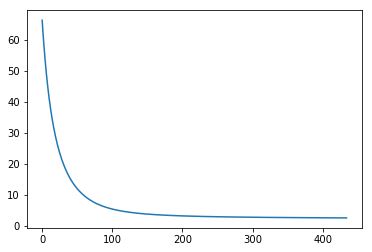

In [54]:
plt.plot(reg_res[1])
plt.show()

In [55]:
predicted_train_Y = []
train_X_ = np.append(train_X,np.ones([len(train_X[:,0]),1]),axis=1)
for i in range(len(train_X_[:,0])):
    predicted_train_Y.append(sum(reg_res[0]*train_X_[i,:]))

In [121]:
predicted_train_Y

[20.495356433501641,
 21.732832213886436,
 21.020224986145816,
 19.673736809594292,
 21.742166092039277,
 28.845055126575893,
 22.677502744002879,
 20.41200420200181,
 19.792880992150646,
 21.809877829634317,
 21.595241352992197,
 20.924201881539737,
 20.628840147635135,
 27.335680806699614,
 19.242784264322331,
 21.303461635657833,
 20.726357574891367,
 19.668267188533044,
 20.466561030411178,
 20.657596621887674,
 20.50855835779273,
 18.775358775890666,
 21.418102612816604,
 21.568049391291659,
 19.690334376636038,
 21.226837081333194,
 19.703317914465032,
 21.812790990218321,
 21.493931469151981,
 23.072058106210726,
 22.237406439988924,
 19.791863189873286,
 20.281015602800846,
 22.187478134565382,
 21.773458508846026,
 20.551738933199921,
 21.100832716586556,
 21.459231363482608,
 20.479191453333669,
 21.353897276206368,
 21.361161844980714,
 20.835671353636624,
 21.721188758730797,
 14.63192316139277,
 20.477852045032343,
 20.979050257550266,
 20.722601046648581,
 21.549850071720

In [122]:
train_Y

array([320, 370,  60, ...,  50,  50,  30])

In [110]:
#just for checking purpose
train_standard_X = train_X - train_X.mean(axis=0)
for i in range(len(train_standard_X[0,:])):
    train_standard_X[:,i] = train_standard_X[:,i]/np.max(train_standard_X[:,i])
train_standard_Y = (train_Y - train_Y.mean())/np.max(train_Y)

In [123]:
predicted_standard_Y = []
for i in range(len(train_standard_X[:,0])):
    predicted_standard_Y.append(sum(reg_res[0]*train_standard_X[1,:]))


In [115]:
train_standard_Y

array([ 0.24454889,  0.29949394, -0.0411654 , ..., -0.05215441,
       -0.05215441, -0.07413243])

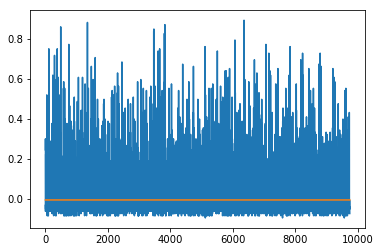

In [124]:
plt.plot(train_standard_Y)
plt.plot(predicted_standard_Y)
plt.show()